# Ofset free MPC using matric C

# Ofset free MPC using matric C

In [2]:
import numpy as np
from numpy.linalg import inv
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
#from torch.utils.data import DataLoader
import torch
#from sklearn.preprocessing import StandardScaler
import os
import sys

from neuromancer.system import Node, System
#from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
#from neuromancer.dataset import DictDataset
#from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

Models imported succesfully
Helper imported succesfully


Load matrices, model, scalers and load process

In [3]:
matrix_C = False

# Load matrices A, B, and C 
A = np.load('../data/A_C_' + str(matrix_C) + '.npy')
B = np.load('../data/B_C_' + str(matrix_C) + '.npy')
C = np.load('../data/C_C_' + str(matrix_C) + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [4]:
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))


Close to block diagonal? True
Backtransformation equals original A? True


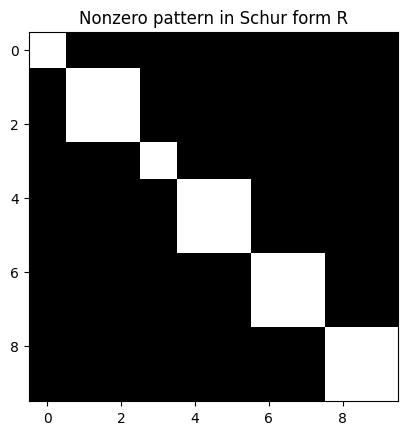

In [5]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(A_transformed) > 1e-6, cmap='gray')
plt.title("Nonzero pattern in Schur form R")
plt.show()

In [6]:
A = A_block
B = inv(T_real) @ B
C = C @ T_real


In [7]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [8]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

# no loss function because only using the model not training it
loss = PenaltyLoss([], constraints=[])

problem = Problem(nodes, loss)

problem.load_state_dict(torch.load('../data/model_C_' + str(matrix_C) + '.pth'),strict=False)



<All keys matched successfully>

In [9]:
# load scalers
scaler = joblib.load('../data/scaler.pkl')
scalerU = joblib.load('../data/scalerU.pkl')


In [10]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

In [11]:
# probably yes
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1)

## Optimal control problem

Observer - Kalman filter

In [12]:
loaded_setup = joblib.load("sim_setup.pkl")

In [13]:
y_start = loaded_setup['y_start']

y_setpoint = loaded_setup['reference'][:,0]

u_previous = loaded_setup['u_previous']

z_est_ = np.hstack(((inv(T_real)@get_x(y_start)).T, np.zeros((1,nd))))

P0 = loaded_setup['P0']

# Noise covariances
Q = loaded_setup['Q']  # process noise
R = loaded_setup['R']  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

EKF = helper.EEKF(A_,B_,z_est_,P0, problem, Q, R, 2, T_real)


Target calculation

In [14]:
target_estimation = helper.TaylorTargetEstimation(A, B)

In [15]:
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real@z_est_[0,:nz]).float(),
)@T_real

In [16]:

z_s, y_s = target_estimation.get_target(z_est_[:,nz:],y_setpoint, get_y(T_real@z_est_[0,:nz]) ,z_est_[0,:nz],J)
print(target_estimation.te.status)
print("Optimal y:", scaler.inverse_transform(y_s.reshape(1,-1)))
print("Desired y:", scaler.inverse_transform(y_setpoint.reshape(1,-1)))
print("Optimal u:", scalerU.inverse_transform(target_estimation.u_s.value.reshape(1,-1)))
z_ref = z_s

Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05
optimal
Optimal y: [[0.50000001 0.49999999]]
Desired y: [[0.5 0.5]]
Optimal u: [[0.05012233 0.53753521]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


MPC problem formulation


In [17]:
Qy = loaded_setup['Qy']
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real@z_s).float(),
)@T_real
Qz = J.T@Qy@J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

In [18]:
# sanity check and problem formulation
mpc = helper.TaylorMPC(A,B)
mpc.build_problem(Qz_psd)
u_opt = mpc.get_u_optimal(z_est_[0,:nz], z_est_[:,nz:],u_previous, z_ref, get_y(T_real@z_s),z_s,J)
print(u_opt)
print(mpc.mpc.status)

[-0.96274535  0.11312753]
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [19]:
import time

sim_time = loaded_setup['sim_time']
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))
us_sim = np.zeros((nu, sim_time+1))

total_time_target = 0
total_time_mpc = 0

start_time_target = time.time()
z_s, y_s = target_estimation.get_target(z_est_[:,nz:],y_setpoint, get_y(T_real@z_s) ,z_s,J)
end_time_target = time.time()
total_time_target += end_time_target - start_time_target

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value
u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1,-1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]

for k in range(sim_time):
    y_setpoint = loaded_setup['reference'][:,k]
    
    J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real@z_sim[:nz, k]).float(),
    )@T_real
    z_s = z_sim[:nz, k]
    if k>0:# abs(sum(ys_sim[:, k-1]-ys_sim[:, k])) > 0.01 and k > 0: #k in [50,51,52,53]:
        J_t = helper.evaluate_jacobian(
            problem.nodes[4],
            torch.from_numpy(T_real@zs_sim[:nz, k]).float(),
        )@T_real
        Qz = J_t.T@Qy@J_t
        Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
        mpc.build_problem(Qz_psd)
    # solve MPC
    start_time_mpc = time.time()
    u_opt = mpc.get_u_optimal(z_sim[:nz,k], z_sim[nz:,k], u_prev, zs_sim[:, k], get_y(T_real@z_s),z_s,J)
    end_time_mpc = time.time()
    total_time_mpc += end_time_mpc - start_time_mpc
    
    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()

    # estimate target
    J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real@zs_sim[:, k]).float(),
    )@T_real
    z_s = zs_sim[:, k]
    start_time_target = time.time()
    zs_sim[:, k+1], ys_sim[:, k+1] = target_estimation.get_target(z_sim[nz:,k+1],y_setpoint, get_y(T_real@zs_sim[:, k]) ,zs_sim[:, k],J)
    
    end_time_target = time.time()
    total_time_target += end_time_target - start_time_target
    
    u_prev = u_sim[:, k]
    
print(f"Total time spent in target estimation: {total_time_target:.4f} seconds")
print(f"Total time spent in MPC solve: {total_time_mpc:.4f} seconds")

[[ 0.48433347]
 [-0.27637082]
 [ 0.0712128 ]
 [-0.41224913]
 [-0.58040183]
 [ 0.01130872]
 [ 1.68375436]
 [-2.76580777]
 [-1.25468726]
 [-2.46210071]
 [-0.00714652]
 [ 0.01296242]]
[[ 0.4912462 ]
 [ 0.07230009]
 [-0.04628303]
 [-0.3175059 ]
 [ 0.25787815]
 [ 0.20582154]
 [-0.24141021]
 [-1.0493548 ]
 [-0.11824676]
 [ 0.37258106]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48349645]
 [-0.28293908]
 [ 0.06691423]
 [-0.39571236]
 [-0.54865048]
 [-0.02105573]
 [ 1.58143448]
 [-2.58242622]
 [-1.14731958]
 [-2.37029447]
 [-0.00706254]
 [ 0.01373397]]
[[ 0.48965803]
 [ 0.07136233]
 [-0.04600886]
 [-0.31649965]
 [ 0.25558922]
 [ 0.20496179]
 [-0.23851815]
 [-1.0494981 ]
 [-0.12152863]
 [ 0.37049615]]
[[ 0.48131374]
 [-0.28318744]
 [ 0.07261589]
 [-0.3962453 ]
 [-0.56460129]
 [-0.00743289]
 [ 1.55771437]
 [-2.59151271]
 [-1.19927738]
 [-2.30887535]
 [-0.00590445]
 [ 0.0159586 ]]
[[ 0.4848462 ]
 [ 0.06913102]
 [-0.04560965]
 [-0.31316406]
 [ 0.25101706]
 [ 0.20285805]
 [-0.23295206]
 [-1.0456057 ]
 [-0.12652697]
 [ 0.3659034 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.47752912]
 [-0.28385293]
 [ 0.08029036]
 [-0.39747652]
 [-0.58865731]
 [ 0.00868414]
 [ 1.54209396]
 [-2.60950318]
 [-1.26721296]
 [-2.25470912]
 [-0.00436123]
 [ 0.0180476 ]]
[[ 0.4820344 ]
 [ 0.06853987]
 [-0.04625992]
 [-0.31051934]
 [ 0.25201747]
 [ 0.20225698]
 [-0.23466101]
 [-1.0365918 ]
 [-0.12200527]
 [ 0.36564064]]
[[ 0.47589327]
 [-0.28486931]
 [ 0.08709212]
 [-0.39856965]
 [-0.60829352]
 [ 0.02028132]
 [ 1.5258929 ]
 [-2.61899116]
 [-1.32231543]
 [-2.20783462]
 [-0.00283084]
 [ 0.01999561]]
[[ 0.4821252 ]
 [ 0.06899318]
 [-0.04704147]
 [-0.30993056]
 [ 0.254856  ]
 [ 0.20268893]
 [-0.23848139]
 [-1.0316058 ]
 [-0.11646   ]
 [ 0.367407  ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 4.76530754e-01]
 [-2.85304038e-01]
 [ 9.17026652e-02]
 [-3.99328738e-01]
 [-6.19916669e-01]
 [ 2.73602835e-02]
 [ 1.50810898e+00]
 [-2.61787991e+00]
 [-1.35675232e+00]
 [-2.16822596e+00]
 [-1.41223463e-03]
 [ 2.16842090e-02]]
[[ 0.48381704]
 [ 0.07020382]
 [-0.04823015]
 [-0.31019458]
 [ 0.25990596]
 [ 0.2038624 ]
 [-0.24508314]
 [-1.0266407 ]
 [-0.1079766 ]
 [ 0.37102547]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 4.78161575e-01]
 [-2.85276493e-01]
 [ 9.46104777e-02]
 [-3.99294821e-01]
 [-6.25048804e-01]
 [ 3.04710822e-02]
 [ 1.48986883e+00]
 [-2.60772896e+00]
 [-1.37386195e+00]
 [-2.13553861e+00]
 [-1.62983943e-04]
 [ 2.31805072e-02]]
[[ 0.48552784]
 [ 0.07127576]
 [-0.04882391]
 [-0.31100798]
 [ 0.26322207]
 [ 0.20486812]
 [-0.2493447 ]
 [-1.0249188 ]
 [-0.10282451]
 [ 0.37371865]]
[[ 4.79579099e-01]
 [-2.84781556e-01]
 [ 9.63839714e-02]
 [-3.99092920e-01]
 [-6.27223593e-01]
 [ 3.26575160e-02]
 [ 1.47283880e+00]
 [-2.59591089e+00]
 [-1.38335476e+00]
 [-2.10694509e+00]
 [ 9.39820690e-04]
 [ 2.45068094e-02]]
[[ 0.4867745 ]
 [ 0.07209341]
 [-0.04916148]
 [-0.311698  ]
 [ 0.26549014]
 [ 0.2056173 ]
 [-0.25225148]
 [-1.0239403 ]
 [-0.09930304]
 [ 0.37565508]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 4.80546907e-01]
 [-2.84180585e-01]
 [ 9.77995294e-02]
 [-3.98821129e-01]
 [-6.28878039e-01]
 [ 3.47574255e-02]
 [ 1.45774968e+00]
 [-2.58529299e+00]
 [-1.39117652e+00]
 [-2.08141665e+00]
 [ 1.93562374e-03]
 [ 2.56973826e-02]]
[[ 0.4876022 ]
 [ 0.07267672]
 [-0.04944615]
 [-0.3121068 ]
 [ 0.26722956]
 [ 0.20615157]
 [-0.25449672]
 [-1.0228621 ]
 [-0.09649697]
 [ 0.37708932]]
[[ 0.48117738]
 [-0.28366188]
 [ 0.09919919]
 [-0.3985722 ]
 [-0.63090757]
 [ 0.03697704]
 [ 1.44465708]
 [-2.57680567]
 [-1.39953682]
 [-2.05844814]
 [ 0.00285811]
 [ 0.02678502]]
[[ 0.4881143 ]
 [ 0.07308583]
 [-0.04969467]
 [-0.31230074]
 [ 0.26858428]
 [ 0.20652598]
 [-0.256262  ]
 [-1.0216835 ]
 [-0.09420235]
 [ 0.37815398]]
[[ 0.48158283]
 [-0.28328077]
 [ 0.10065094]
 [-0.39842795]
 [-0.63350023]
 [ 0.03936765]
 [ 1.43340532]
 [-2.57058091]
 [-1.40897021]
 [-2.03773364]
 [ 0.00372549]
 [ 0.02778594]]
[[ 0.4884499 ]
 [ 0.07340534]
 [-0.04993466]
 [-0.312365  ]
 [ 0.2697692 ]
 [ 0.20681833]
 [-0.2578201 ]
 [

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48247078]
 [-0.28291051]
 [ 0.10488878]
 [-0.39853964]
 [-0.64245637]
 [ 0.04606157]
 [ 1.40814301]
 [-2.56022677]
 [-1.43839974]
 [-1.9884811 ]
 [ 0.0060366 ]
 [ 0.03025709]]
[[ 0.48928106]
 [ 0.07437707]
 [-0.05079964]
 [-0.3123035 ]
 [ 0.27374542]
 [ 0.20770629]
 [-0.26308593]
 [-1.0151869 ]
 [-0.08481444]
 [ 0.38189957]]
[[ 0.4828037 ]
 [-0.28293293]
 [ 0.10606808]
 [-0.39866349]
 [-0.64504898]
 [ 0.04777381]
 [ 1.40188712]
 [-2.55804877]
 [-1.4466416 ]
 [-1.97612958]
 [ 0.00669239]
 [ 0.03091411]]
[[ 0.48960656]
 [ 0.07469734]
 [-0.051048  ]
 [-0.31235313]
 [ 0.2749545 ]
 [ 0.20799921]
 [-0.26467806]
 [-1.0137986 ]
 [-0.08265816]
 [ 0.38279766]]
[[ 0.48315694]
 [-0.28296876]
 [ 0.10707927]
 [-0.39880125]
 [-0.64726714]
 [ 0.04921678]
 [ 1.39647723]
 [-2.55616387]
 [-1.45370237]
 [-1.96553109]
 [ 0.00728459]
 [ 0.0314992 ]]
[[ 0.4899439 ]
 [ 0.07499572]
 [-0.05125504]
 [-0.3124456 ]
 [ 0.27601385]
 [ 0.20827222]
 [-0.26606628]
 [-1.0127153 ]
 [-0.08081181]
 [ 0.38360515]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48351263]
 [-0.28300396]
 [ 0.10793223]
 [-0.39894281]
 [-0.6491311 ]
 [ 0.05042929]
 [ 1.39181172]
 [-2.55451893]
 [-1.4596651 ]
 [-1.95647045]
 [ 0.00781436]
 [ 0.03202023]]
[[ 0.49027446]
 [ 0.07526552]
 [-0.05142401]
 [-0.31256387]
 [ 0.27692124]
 [ 0.2085191 ]
 [-0.26725033]
 [-1.0118941 ]
 [-0.07926462]
 [ 0.38431332]]
[[ 0.48385452]
 [-0.28303506]
 [ 0.10865009]
 [-0.3990825 ]
 [-0.65069857]
 [ 0.05145529]
 [ 1.38780133]
 [-2.55310205]
 [-1.46470452]
 [-1.94873201]
 [ 0.00828538]
 [ 0.03248446]]
[[ 0.4905844 ]
 [ 0.07550507]
 [-0.05156222]
 [-0.31269115]
 [ 0.2776944 ]
 [ 0.20873839]
 [-0.26825556]
 [-1.0112664 ]
 [-0.07796954]
 [ 0.38492796]]
[[ 0.48417207]
 [-0.28306384]
 [ 0.10925881]
 [-0.39921773]
 [-0.65203407]
 [ 0.0523331 ]
 [ 1.38436579]
 [-2.55191039]
 [-1.4690081 ]
 [-1.94211934]
 [ 0.00870268]
 [ 0.03289828]]
[[ 0.49086663]
 [ 0.07571585]
 [-0.05167719]
 [-0.31281593]
 [ 0.27835616]
 [ 0.20893137]
 [-0.26911396]
 [-1.0107726 ]
 [-0.07687498]
 [ 0.3854607 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48446076]
 [-0.28309283]
 [ 0.10978078]
 [-0.39934725]
 [-0.65319041]
 [ 0.05309184]
 [ 1.38142896]
 [-2.55093182]
 [-1.4727301 ]
 [-1.93646024]
 [ 0.0090715 ]
 [ 0.03326738]]
[[ 0.49111974]
 [ 0.07590067]
 [-0.05177402]
 [-0.31293303]
 [ 0.2789256 ]
 [ 0.20910054]
 [-0.2698513 ]
 [-1.010374  ]
 [-0.07594156]
 [ 0.38592303]]
[[ 0.48472057]
 [-0.2831233 ]
 [ 0.11023258]
 [-0.39947086]
 [-0.65420478]
 [ 0.05375309]
 [ 1.37892002]
 [-2.55014454]
 [-1.47598303]
 [-1.93160725]
 [ 0.00939688]
 [ 0.03359667]]
[[ 0.49134558]
 [ 0.07606302]
 [-0.05185647]
 [-0.3130406 ]
 [ 0.27941862]
 [ 0.20924932]
 [-0.2704888 ]
 [-1.0100455 ]
 [-0.07513886]
 [ 0.38632622]]
[[ 0.48495369]
 [-0.28315537]
 [ 0.11062598]
 [-0.39958801]
 [-0.65510079]
 [ 0.05433168]
 [ 1.37677473]
 [-2.54951871]
 [-1.47884273]
 [-1.92743694]
 [ 0.00968344]
 [ 0.03389047]]
[[ 0.4915476 ]
 [ 0.07620624]
 [-0.05192731]
 [-0.31313938]
 [ 0.27984807]
 [ 0.2093805 ]
 [-0.2710434 ]
 [-1.0097735 ]
 [-0.07444409]
 [ 0.38667935]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48516328]
 [-0.28318804]
 [ 0.1109691 ]
 [-0.39969807]
 [-0.65589208]
 [ 0.05483777]
 [ 1.3749345 ]
 [-2.54901918]
 [-1.48135752]
 [-1.92384493]
 [ 0.00993529]
 [ 0.03415249]]
[[ 0.4917288 ]
 [ 0.07633304]
 [-0.05198827]
 [-0.31322998]
 [ 0.28022364]
 [ 0.20949657]
 [-0.27152795]
 [-1.0095469 ]
 [-0.07384031]
 [ 0.38699004]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48535177]
 [-0.28322003]
 [ 0.11126822]
 [-0.39980005]
 [-0.65658864]
 [ 0.05527976]
 [ 1.37334927]
 [-2.54861423]
 [-1.48356473]
 [-1.92074241]
 [ 0.01015622]
 [ 0.03438605]]
[[ 0.49189168]
 [ 0.0764456 ]
 [-0.05204096]
 [-0.31331316]
 [ 0.28055322]
 [ 0.20959972]
 [-0.27195245]
 [-1.0093584 ]
 [-0.07331374]
 [ 0.38726416]]
[[ 0.4855213 ]
 [-0.28325017]
 [ 0.11152865]
 [-0.39989332]
 [-0.65719883]
 [ 0.05566487]
 [ 1.3719768 ]
 [-2.54827776]
 [-1.48549584]
 [-1.9180545 ]
 [ 0.01034963]
 [ 0.03459411]]
[[ 0.49203807]
 [ 0.07654565]
 [-0.05208666]
 [-0.3133892 ]
 [ 0.28084275]
 [ 0.20969139]
 [-0.27232507]
 [-1.0092007 ]
 [-0.07285374]
 [ 0.38750634]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48567341]
 [-0.28327766]
 [ 0.1117553 ]
 [-0.3999774 ]
 [-0.65773132]
 [ 0.0560002 ]
 [ 1.37078182]
 [-2.54798979]
 [-1.48718144]
 [-1.91571648]
 [ 0.01051868]
 [ 0.03477937]]
[[ 0.49216905]
 [ 0.07663434]
 [-0.05212628]
 [-0.31345832]
 [ 0.28109705]
 [ 0.20977265]
 [-0.27265227]
 [-1.0090684 ]
 [-0.07245158]
 [ 0.38772   ]]
[[ 0.48580919]
 [-0.28330209]
 [ 0.11195285]
 [-0.40005255]
 [-0.65819597]
 [ 0.05629298]
 [ 1.36973601]
 [-2.54773867]
 [-1.488654  ]
 [-1.91367373]
 [ 0.01066623]
 [ 0.03494425]]
[[ 0.49228594]
 [ 0.07671291]
 [-0.05216077]
 [-0.31352067]
 [ 0.28132075]
 [ 0.2098446 ]
 [-0.27293965]
 [-1.0089563 ]
 [-0.07209925]
 [ 0.3879085 ]]
[[ 0.48592992]
 [-0.28332322]
 [ 0.11212531]
 [-0.40011883]
 [-0.65860083]
 [ 0.05654895]
 [ 1.3688149 ]
 [-2.54751324]
 [-1.48994007]
 [-1.91187952]
 [ 0.01079497]
 [ 0.03509097]]
[[ 0.49238974]
 [ 0.07678231]
 [-0.05219093]
 [-0.31357658]
 [ 0.28151745]
 [ 0.20990817]
 [-0.27319217]
 [-1.0088608 ]
 [-0.07179043]
 [ 0.38807458]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48603672]
 [-0.28334113]
 [ 0.11227636]
 [-0.40017685]
 [-0.65895421]
 [ 0.05677362]
 [ 1.36799957]
 [-2.54730808]
 [-1.49106575]
 [-1.91029591]
 [ 0.0109073 ]
 [ 0.03522154]]
[[ 0.49248135]
 [ 0.07684349]
 [-0.05221744]
 [-0.31362578]
 [ 0.28169054]
 [ 0.20996425]
 [-0.2734146 ]
 [-1.0087769 ]
 [-0.07151861]
 [ 0.38822106]]
[[ 0.48613073]
 [-0.28335621]
 [ 0.11240953]
 [-0.40022734]
 [-0.65926477]
 [ 0.05697239]
 [ 1.36727439]
 [-2.54712071]
 [-1.49205752]
 [-1.90888995]
 [ 0.01100535]
 [ 0.03533776]]
[[ 0.49256188]
 [ 0.07689741]
 [-0.05224069]
 [-0.31366917]
 [ 0.28184286]
 [ 0.21001351]
 [-0.2736102 ]
 [-1.008703  ]
 [-0.07127951]
 [ 0.3883499 ]]
[[ 0.48621315]
 [-0.28336865]
 [ 0.11252732]
 [-0.40027111]
 [-0.65953832]
 [ 0.05714894]
 [ 1.36662596]
 [-2.54694735]
 [-1.49293351]
 [-1.90763522]
 [ 0.01109098]
 [ 0.03544122]]
[[ 0.49263257]
 [ 0.07694472]
 [-0.05226143]
 [-0.31370708]
 [ 0.2819774 ]
 [ 0.21005696]
 [-0.27378306]
 [-1.0086366 ]
 [-0.07106791]
 [ 0.38846347]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48628529]
 [-0.28337862]
 [ 0.11263201]
 [-0.40030868]
 [-0.6597797 ]
 [ 0.05730622]
 [ 1.36604318]
 [-2.54678487]
 [-1.4937092 ]
 [-1.90651011]
 [ 0.01116587]
 [ 0.03553335]]
[[ 0.49269447]
 [ 0.07698645]
 [-0.05227976]
 [-0.31374007]
 [ 0.28209627]
 [ 0.21009523]
 [-0.27393565]
 [-1.008577  ]
 [-0.07088088]
 [ 0.38856354]]
[[ 0.48634827]
 [-0.28338657]
 [ 0.11272535]
 [-0.40034089]
 [-0.65999378]
 [ 0.05744711]
 [ 1.36551755]
 [-2.5466329 ]
 [-1.49439929]
 [-1.90549694]
 [ 0.0112315 ]
 [ 0.03561542]]
[[ 0.4927486 ]
 [ 0.0770231 ]
 [-0.05229624]
 [-0.31376848]
 [ 0.28220165]
 [ 0.21012871]
 [-0.27407128]
 [-1.0085217 ]
 [-0.07071397]
 [ 0.388652  ]]
[[ 0.48640319]
 [-0.28339271]
 [ 0.11280905]
 [-0.40036826]
 [-0.66018441]
 [ 0.05757382]
 [ 1.36504147]
 [-2.54648957]
 [-1.49501544]
 [-1.90458063]
 [ 0.01128912]
 [ 0.03568859]]
[[ 0.49279588]
 [ 0.07705535]
 [-0.05231091]
 [-0.31379318]
 [ 0.2822948 ]
 [ 0.21015845]
 [-0.27419108]
 [-1.0084714 ]
 [-0.07056601]
 [ 0.38873017]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48649267]
 [-0.28340049]
 [ 0.11295197]
 [-0.40041113]
 [-0.66050614]
 [ 0.05779134]
 [ 1.36421432]
 [-2.5462251 ]
 [-1.49606089]
 [-1.9029923 ]
 [ 0.01138452]
 [ 0.03581208]]
[[ 0.4928732 ]
 [ 0.077109  ]
 [-0.05233622]
 [-0.3138324 ]
 [ 0.28245237]
 [ 0.21020754]
 [-0.2743943 ]
 [-1.0083795 ]
 [-0.07031365]
 [ 0.38886094]]
[[ 0.48652894]
 [-0.28340265]
 [ 0.11301326]
 [-0.40042772]
 [-0.66064258]
 [ 0.05788503]
 [ 1.36385448]
 [-2.54610405]
 [-1.4965061 ]
 [-1.90230262]
 [ 0.01142403]
 [ 0.03586407]]
[[ 0.49290472]
 [ 0.07713126]
 [-0.05234721]
 [-0.31384787]
 [ 0.28251904]
 [ 0.21022786]
 [-0.2744802 ]
 [-1.0083379 ]
 [-0.07020599]
 [ 0.38891575]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48656053]
 [-0.28340384]
 [ 0.11306864]
 [-0.40044142]
 [-0.66076446]
 [ 0.05796963]
 [ 1.36352493]
 [-2.54598785]
 [-1.49690543]
 [-1.90167269]
 [ 0.01145904]
 [ 0.03591052]]
[[ 0.49293226]
 [ 0.0771509 ]
 [-0.0523569 ]
 [-0.3138612 ]
 [ 0.282578  ]
 [ 0.21024579]
 [-0.27455652]
 [-1.0082997 ]
 [-0.07011053]
 [ 0.38896418]]
[[ 0.48658805]
 [-0.28340429]
 [ 0.11311878]
 [-0.40045299]
 [-0.66087432]
 [ 0.05804685]
 [ 1.36322369]
 [-2.54587916]
 [-1.49726644]
 [-1.90109688]
 [ 0.01149018]
 [ 0.03595202]]
[[ 0.49295628]
 [ 0.07716832]
 [-0.05236599]
 [-0.31387246]
 [ 0.2826314 ]
 [ 0.21026179]
 [-0.2746256 ]
 [-1.0082632 ]
 [-0.07002316]
 [ 0.3890077 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.486612  ]
 [-0.28340428]
 [ 0.11316451]
 [-0.40046263]
 [-0.66097365]
 [ 0.05811702]
 [ 1.36294807]
 [-2.54577716]
 [-1.49759329]
 [-1.9005704 ]
 [ 0.01151791]
 [ 0.03598917]]
[[ 0.49297726]
 [ 0.07718372]
 [-0.052374  ]
 [-0.31388223]
 [ 0.28267875]
 [ 0.21027595]
 [-0.2746869 ]
 [-1.00823   ]
 [-0.06994566]
 [ 0.3890462 ]]
[[ 0.48663289]
 [-0.2834038 ]
 [ 0.11320598]
 [-0.40047083]
 [-0.66106343]
 [ 0.05818115]
 [ 1.36269598]
 [-2.54568218]
 [-1.49788952]
 [-1.90008879]
 [ 0.01154269]
 [ 0.0360224 ]]
[[ 0.49299574]
 [ 0.07719743]
 [-0.05238157]
 [-0.31389028]
 [ 0.28272212]
 [ 0.21028852]
 [-0.27474323]
 [-1.0081973 ]
 [-0.06987365]
 [ 0.38908103]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48665123]
 [-0.28340306]
 [ 0.11324382]
 [-0.40047747]
 [-0.66114459]
 [ 0.05823922]
 [ 1.3624653 ]
 [-2.54559275]
 [-1.49815746]
 [-1.89964871]
 [ 0.01156484]
 [ 0.03605219]]
[[ 0.49301186]
 [ 0.07720954]
 [-0.05238814]
 [-0.31389743]
 [ 0.28276017]
 [ 0.21029945]
 [-0.27479252]
 [-1.008169  ]
 [-0.06981071]
 [ 0.38911143]]
[[ 0.48666722]
 [-0.283402  ]
 [ 0.1132781 ]
 [-0.40048323]
 [-0.66121808]
 [ 0.05829254]
 [ 1.36225432]
 [-2.54551033]
 [-1.49840079]
 [-1.89924607]
 [ 0.01158476]
 [ 0.03607883]]
[[ 0.4930262 ]
 [ 0.0772206 ]
 [-0.05239448]
 [-0.31390342]
 [ 0.28279552]
 [ 0.21030958]
 [-0.27483845]
 [-1.0081406 ]
 [-0.06975182]
 [ 0.3891397 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48668136]
 [-0.28340093]
 [ 0.1133094 ]
 [-0.40048784]
 [-0.66128438]
 [ 0.05834055]
 [ 1.36206122]
 [-2.5454324 ]
 [-1.49862048]
 [-1.89887812]
 [ 0.01160264]
 [ 0.03610277]]
[[ 0.49303865]
 [ 0.07723011]
 [-0.05239988]
 [-0.31390867]
 [ 0.28282607]
 [ 0.21031837]
 [-0.27487805]
 [-1.0081164 ]
 [-0.06970093]
 [ 0.3891641 ]]
[[ 0.48669368]
 [-0.28339958]
 [ 0.11333779]
 [-0.40049191]
 [-0.66134462]
 [ 0.05838493]
 [ 1.36188506]
 [-2.54536164]
 [-1.49882082]
 [-1.89854193]
 [ 0.01161879]
 [ 0.03612416]]
[[ 0.49304977]
 [ 0.077239  ]
 [-0.05240539]
 [-0.31391284]
 [ 0.28285548]
 [ 0.2103266 ]
 [-0.2749164 ]
 [-1.0080909 ]
 [-0.0696509 ]
 [ 0.38918734]]
[[ 0.48670463]
 [-0.28339855]
 [ 0.11336386]
 [-0.40049513]
 [-0.66139944]
 [ 0.05842455]
 [ 1.36172491]
 [-2.54529594]
 [-1.49900226]
 [-1.89823663]
 [ 0.01163331]
 [ 0.03614345]]
[[ 0.49305958]
 [ 0.07724649]
 [-0.05240953]
 [-0.31391695]
 [ 0.28287932]
 [ 0.21033333]
 [-0.27494758]
 [-1.0080718 ]
 [-0.06961088]
 [ 0.3892062 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48671435]
 [-0.28339713]
 [ 0.11338723]
 [-0.40049827]
 [-0.66144911]
 [ 0.05846171]
 [ 1.36157877]
 [-2.54523696]
 [-1.49916774]
 [-1.89795733]
 [ 0.01164649]
 [ 0.03616063]]
[[ 0.49306828]
 [ 0.07725377]
 [-0.05241425]
 [-0.31391987]
 [ 0.28290445]
 [ 0.21033998]
 [-0.27498025]
 [-1.0080482 ]
 [-0.06956813]
 [ 0.38922563]]
[[ 0.48672288]
 [-0.2833962 ]
 [ 0.11340876]
 [-0.40050043]
 [-0.66149404]
 [ 0.05849384]
 [ 1.36144654]
 [-2.54518106]
 [-1.49931604]
 [-1.8977055 ]
 [ 0.01165831]
 [ 0.03617622]]
[[ 0.49307615]
 [ 0.0772596 ]
 [-0.05241735]
 [-0.31392342]
 [ 0.28292254]
 [ 0.21034534]
 [-0.27500373]
 [-1.008035  ]
 [-0.0695382 ]
 [ 0.38924038]]
[[ 0.48673069]
 [-0.28339482]
 [ 0.11342791]
 [-0.4005031 ]
 [-0.66153492]
 [ 0.05852506]
 [ 1.3613261 ]
 [-2.54513334]
 [-1.49945281]
 [-1.89747465]
 [ 0.01166915]
 [ 0.03619001]]
[[ 0.49308288]
 [ 0.07726575]
 [-0.05242183]
 [-0.31392497]
 [ 0.28294498]
 [ 0.21035099]
 [-0.27503327]
 [-1.008011  ]
 [-0.06949865]
 [ 0.3892573 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48673729]
 [-0.28339426]
 [ 0.11344598]
 [-0.40050436]
 [-0.66157223]
 [ 0.05855088]
 [ 1.36121739]
 [-2.54508608]
 [-1.49957485]
 [-1.89726771]
 [ 0.01167877]
 [ 0.03620269]]
[[ 0.49308932]
 [ 0.07727004]
 [-0.05242367]
 [-0.31392848]
 [ 0.28295705]
 [ 0.2103549 ]
 [-0.27504867]
 [-1.0080053 ]
 [-0.06947997]
 [ 0.3892675 ]]
[[ 0.48674372]
 [-0.28339265]
 [ 0.11346125]
 [-0.40050684]
 [-0.66160498]
 [ 0.05857729]
 [ 1.36111805]
 [-2.54504729]
 [-1.49968616]
 [-1.89707731]
 [ 0.01168772]
 [ 0.03621366]]
[[ 0.49309462]
 [ 0.07727564]
 [-0.05242822]
 [-0.3139288 ]
 [ 0.28297904]
 [ 0.21036011]
 [-0.27507773]
 [-1.0079786 ]
 [-0.06944009]
 [ 0.38928363]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48674885]
 [-0.28339269]
 [ 0.11347647]
 [-0.40050724]
 [-0.66163595]
 [ 0.05859698]
 [ 1.3610299 ]
 [-2.54500714]
 [-1.49978541]
 [-1.8969098 ]
 [ 0.01169548]
 [ 0.0362241 ]]
[[ 0.49310002]
 [ 0.07727832]
 [-0.0524285 ]
 [-0.3139329 ]
 [ 0.28298357]
 [ 0.2103625 ]
 [-0.2750832 ]
 [-1.0079839 ]
 [-0.06943536]
 [ 0.3892887 ]]
[[ 0.48675431]
 [-0.28339067]
 [ 0.11348815]
 [-0.40051   ]
 [-0.66166153]
 [ 0.05862017]
 [ 1.36094872]
 [-2.54497766]
 [-1.49987538]
 [-1.89675391]
 [ 0.01170298]
 [ 0.0362327 ]]
[[ 0.493104  ]
 [ 0.07728403]
 [-0.05243416]
 [-0.31393132]
 [ 0.28300875]
 [ 0.21036774]
 [-0.27511662]
 [-1.0079478 ]
 [-0.06938827]
 [ 0.38930622]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48675808]
 [-0.28339181]
 [ 0.11350171]
 [-0.40050926]
 [-0.66168843]
 [ 0.05863386]
 [ 1.36087803]
 [-2.54494266]
 [-1.49995731]
 [-1.89661949]
 [ 0.01170911]
 [ 0.03624154]]
[[ 0.49310872]
 [ 0.0772844 ]
 [-0.05243139]
 [-0.31393728]
 [ 0.28300154]
 [ 0.21036802]
 [-0.2751063 ]
 [-1.0079733 ]
 [-0.06940655]
 [ 0.38930354]]
[[ 0.48676304]
 [-0.2833887 ]
 [ 0.11350981]
 [-0.40051331]
 [-0.66170819]
 [ 0.05865688]
 [ 1.36081098]
 [-2.54492453]
 [-1.50003239]
 [-1.89648903]
 [ 0.01171558]
 [ 0.03624792]]
[[ 0.49311143]
 [ 0.07729152]
 [-0.05244012]
 [-0.31393218]
 [ 0.2830373 ]
 [ 0.2103746 ]
 [-0.27515438]
 [-1.0079144 ]
 [-0.06933717]
 [ 0.38932744]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48676533]
 [-0.28339174]
 [ 0.1135229 ]
 [-0.4005102 ]
 [-0.66173203]
 [ 0.05866226]
 [ 1.36075535]
 [-2.5448888 ]
 [-1.50009728]
 [-1.89638521]
 [ 0.0117201 ]
 [ 0.03625591]]
[[ 0.49311614]
 [ 0.07728814]
 [-0.05243167]
 [-0.31394267]
 [ 0.28300866]
 [ 0.21037154]
 [-0.27511504]
 [-1.0079792 ]
 [-0.0693984 ]
 [ 0.38931105]]
[[ 0.48677052]
 [-0.28338606]
 [ 0.11352631]
 [-0.40051702]
 [-0.66174479]
 [ 0.05868904]
 [ 1.36069867]
 [-2.54488455]
 [-1.50015919]
 [-1.89627214]
 [ 0.01172606]
 [ 0.03626   ]]
[[ 0.49311712]
 [ 0.07729886]
 [-0.05244704]
 [-0.313931  ]
 [ 0.2830686 ]
 [ 0.21038122]
 [-0.27519587]
 [-1.0078716 ]
 [-0.06927912]
 [ 0.38934952]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48677071]
 [-0.28339286]
 [ 0.11354124]
 [-0.40050961]
 [-0.66176887]
 [ 0.05868208]
 [ 1.36065757]
 [-2.54484203]
 [-1.50020993]
 [-1.89619851]
 [ 0.01172863]
 [ 0.03626835]]
[[ 0.4931229 ]
 [ 0.07728845]
 [-0.05242724]
 [-0.31395152]
 [ 0.28299698]
 [ 0.21037185]
 [-0.27509832]
 [-1.008018  ]
 [-0.06942744]
 [ 0.3893063 ]]
[[ 0.48677746]
 [-0.28338173]
 [ 0.11353767]
 [-0.40052265]
 [-0.66177316]
 [ 0.0587214 ]
 [ 1.36060618]
 [-2.5448615 ]
 [-1.50026439]
 [-1.89608958]
 [ 0.01173481]
 [ 0.03626963]]
[[ 0.4931214 ]
 [ 0.07730708]
 [-0.05245636]
 [-0.31392667]
 [ 0.28310782]
 [ 0.21038878]
 [-0.27524826]
 [-1.0078105 ]
 [-0.06920388]
 [ 0.3893762 ]]
[[ 0.4867741 ]
 [-0.28339584]
 [ 0.11355873]
 [-0.40050604]
 [-0.66180235]
 [ 0.05869256]
 [ 1.3605795 ]
 [-2.54479769]
 [-1.50030057]
 [-1.8960478 ]
 [ 0.01173434]
 [ 0.03628096]]
[[ 0.49313027]
 [ 0.07728104]
 [-0.052411  ]
 [-0.3139705 ]
 [ 0.28294003]
 [ 0.21036518]
 [-0.2750206 ]
 [-1.0081412 ]
 [-0.06954768]
 [ 0.389273  ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48678488]
 [-0.28337171]
 [ 0.11354172]
 [-0.40053303]
 [-0.66179232]
 [ 0.05876407]
 [ 1.36052385]
 [-2.54486282]
 [-1.5003532 ]
 [-1.89591674]
 [ 0.01174192]
 [ 0.03627829]]
[[ 0.49312413]
 [ 0.07731695]
 [-0.05246922]
 [-0.3139183 ]
 [ 0.28315943]
 [ 0.2103978 ]
 [-0.2753176 ]
 [-1.0077226 ]
 [-0.06910268]
 [ 0.38941002]]
[[ 0.48677528]
 [-0.28340043]
 [ 0.11357688]
 [-0.4004986 ]
 [-0.66183501]
 [ 0.05869486]
 [ 1.360511  ]
 [-2.54474706]
 [-1.50037697]
 [-1.89591526]
 [ 0.01173725]
 [ 0.03629518]]
[[ 0.49313834]
 [ 0.07726606]
 [-0.05238273]
 [-0.31399974]
 [ 0.28283748]
 [ 0.21035154]
 [-0.27488115]
 [-1.0083501 ]
 [-0.06975973]
 [ 0.38921088]]
[[ 0.48679252]
 [-0.28335579]
 [ 0.11354031]
 [-0.40054732]
 [-0.66180644]
 [ 0.05881942]
 [ 1.36044179]
 [-2.54488492]
 [-1.50043572]
 [-1.89573138]
 [ 0.01174695]
 [ 0.0362886 ]]
[[ 0.49312633]
 [ 0.07732474]
 [-0.05247933]
 [-0.31391174]
 [ 0.28320003]
 [ 0.21040489]
 [-0.2753722 ]
 [-1.0076535 ]
 [-0.06902312]
 [ 0.3894367 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48677861]
 [-0.28340044]
 [ 0.11358946]
 [-0.40049804]
 [-0.66185706]
 [ 0.05871   ]
 [ 1.36042753]
 [-2.54468966]
 [-1.50046527]
 [-1.89577746]
 [ 0.01174483]
 [ 0.03629855]]
[[ 0.49313644]
 [ 0.07728695]
 [-0.05241549]
 [-0.31397164]
 [ 0.28296202]
 [ 0.21037044]
 [-0.27504945]
 [-1.0081166 ]
 [-0.06950857]
 [ 0.38928926]]
[[ 0.48679101]
 [-0.28336975]
 [ 0.11356437]
 [-0.40053389]
 [-0.66183772]
 [ 0.05879923]
 [ 1.36038063]
 [-2.54479981]
 [-1.50050735]
 [-1.89564421]
 [ 0.01175176]
 [ 0.03629414]]
[[ 0.49313006]
 [ 0.0773225 ]
 [-0.05247319]
 [-0.31391963]
 [ 0.2831796 ]
 [ 0.21040282]
 [-0.2753441 ]
 [-1.0077006 ]
 [-0.06906704]
 [ 0.3894252 ]]
[[ 0.48678097]
 [-0.28339797]
 [ 0.11359744]
 [-0.40049896]
 [-0.6618767 ]
 [ 0.05872766]
 [ 1.36037712]
 [-2.54468542]
 [-1.50051849]
 [-1.89566093]
 [ 0.01174652]
 [ 0.03630928]]
[[ 0.4931437 ]
 [ 0.07727179]
 [-0.05238749]
 [-0.31400007]
 [ 0.28286004]
 [ 0.21035689]
 [-0.27491093]
 [-1.0083226 ]
 [-0.06971905]
 [ 0.38922748]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679757]
 [-0.2833538 ]
 [ 0.1135596 ]
 [-0.40054688]
 [-0.66184429]
 [ 0.05884787]
 [ 1.36031749]
 [-2.54482397]
 [-1.50056354]
 [-1.89549735]
 [ 0.0117555 ]
 [ 0.03630133]]
[[ 0.49313137]
 [ 0.07732943]
 [-0.05248276]
 [-0.31391278]
 [ 0.28321716]
 [ 0.21040909]
 [-0.2753948 ]
 [-1.0076349 ]
 [-0.06899276]
 [ 0.3894497 ]]
[[ 0.48678331]
 [-0.283398  ]
 [ 0.11360664]
 [-0.40049782]
 [-0.66189082]
 [ 0.05873706]
 [ 1.36031218]
 [-2.54463359]
 [-1.50058107]
 [-1.89556035]
 [ 0.01175283]
 [ 0.03630991]]
[[ 0.49314082]
 [ 0.07729162]
 [-0.05241925]
 [-0.3139719 ]
 [ 0.28297997]
 [ 0.21037471]
 [-0.2750733 ]
 [-1.0080948 ]
 [-0.0694761 ]
 [ 0.38930258]]
[[ 0.48679506]
 [-0.28336775]
 [ 0.11358035]
 [-0.40053323]
 [-0.66186872]
 [ 0.05882313]
 [ 1.36027516]
 [-2.54474692]
 [-1.50061276]
 [-1.89544612]
 [ 0.01175911]
 [ 0.03630444]]
[[ 0.49313408]
 [ 0.07732623]
 [-0.05247607]
 [-0.31392044]
 [ 0.2831934 ]
 [ 0.21040621]
 [-0.27536225]
 [-1.0076857 ]
 [-0.06904279]
 [ 0.38943565]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48678469]
 [-0.28339577]
 [ 0.11361179]
 [-0.40049861]
 [-0.66190468]
 [ 0.05875028]
 [ 1.36028051]
 [-2.54463812]
 [-1.5006145 ]
 [-1.89547895]
 [ 0.01175337]
 [ 0.03631852]]
[[ 0.4931473 ]
 [ 0.07727537]
 [-0.0523903 ]
 [-0.31400055]
 [ 0.28287354]
 [ 0.21035995]
 [-0.2749286 ]
 [-1.008307  ]
 [-0.06969505]
 [ 0.38923734]]
[[ 0.48680092]
 [-0.28335201]
 [ 0.11357285]
 [-0.40054652]
 [-0.66187044]
 [ 0.05886839]
 [ 1.36023007]
 [-2.54478149]
 [-1.50065227]
 [-1.89533212]
 [ 0.01176188]
 [ 0.03630966]]
[[ 0.49313456]
 [ 0.07733259]
 [-0.0524853 ]
 [-0.3139133 ]
 [ 0.28322938]
 [ 0.21041203]
 [-0.2754108 ]
 [-1.0076208 ]
 [-0.06897102]
 [ 0.3894587 ]]
[[ 0.48678635]
 [-0.28339643]
 [ 0.11361867]
 [-0.40049777]
 [-0.66191471]
 [ 0.05875582]
 [ 1.36023362]
 [-2.54459624]
 [-1.50066238]
 [-1.89541167]
 [ 0.01175882]
 [ 0.03631728]]
[[ 0.4931436 ]
 [ 0.07729493]
 [-0.05242232]
 [-0.31397164]
 [ 0.28299373]
 [ 0.21037774]
 [-0.27509147]
 [-1.0080765 ]
 [-0.0694511 ]
 [ 0.38931236]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679775]
 [-0.28336694]
 [ 0.11359182]
 [-0.40053298]
 [-0.66189158]
 [ 0.05883943]
 [ 1.36020536]
 [-2.54471392]
 [-1.50068823]
 [-1.8953132 ]
 [ 0.01176459]
 [ 0.03631118]]
[[ 0.49313676]
 [ 0.07732863]
 [-0.05247777]
 [-0.3139211 ]
 [ 0.28320202]
 [ 0.21040836]
 [-0.27537364]
 [-1.0076765 ]
 [-0.06902759]
 [ 0.3894421 ]]
[[ 0.48678731]
 [-0.28339469]
 [ 0.11362178]
 [-0.40049888]
 [-0.66192537]
 [ 0.05876611]
 [ 1.3602182 ]
 [-2.54461128]
 [-1.50068302]
 [-1.89535873]
 [ 0.01175834]
 [ 0.03632473]]
[[ 0.4931499 ]
 [ 0.07727734]
 [-0.05239136]
 [-0.3140017 ]
 [ 0.2828797 ]
 [ 0.21036169]
 [-0.2749366 ]
 [-1.0083025 ]
 [-0.06968488]
 [ 0.3892422 ]]
[[ 0.48680347]
 [-0.28335079]
 [ 0.11358154]
 [-0.40054711]
 [-0.66188875]
 [ 0.05888322]
 [ 1.36017373]
 [-2.54475802]
 [-1.50071392]
 [-1.89522348]
 [ 0.0117665 ]
 [ 0.03631519]]
[[ 0.4931369 ]
 [ 0.07733496]
 [-0.05248711]
 [-0.31391364]
 [ 0.2832381 ]
 [ 0.21041419]
 [-0.27542228]
 [-1.0076107 ]
 [-0.06895552]
 [ 0.38946515]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679982]
 [-0.2833669 ]
 [ 0.11359948]
 [-0.40053282]
 [-0.66190668]
 [ 0.05884901]
 [ 1.36016126]
 [-2.54469268]
 [-1.50073714]
 [-1.89522988]
 [ 0.01176848]
 [ 0.03631559]]
[[ 0.49313885]
 [ 0.07733015]
 [-0.05247853]
 [-0.31392208]
 [ 0.28320694]
 [ 0.21040992]
 [-0.27537993]
 [-1.0076731 ]
 [-0.06901964]
 [ 0.38944614]]
[[ 0.48678931]
 [-0.28339408]
 [ 0.11362804]
 [-0.40049937]
 [-0.66193865]
 [ 0.05877615]
 [ 1.36017934]
 [-2.54459586]
 [-1.50072654]
 [-1.89528315]
 [ 0.01176176]
 [ 0.03632897]]
[[ 0.493152  ]
 [ 0.07727823]
 [-0.05239116]
 [-0.3140035 ]
 [ 0.2828806 ]
 [ 0.21036252]
 [-0.27493763]
 [-1.008306  ]
 [-0.06968477]
 [ 0.38924366]]
[[ 0.48680555]
 [-0.28334979]
 [ 0.11358669]
 [-0.40054818]
 [-0.66190043]
 [ 0.05889363]
 [ 1.36013879]
 [-2.54474614]
 [-1.5007537 ]
 [-1.89515486]
 [ 0.01176968]
 [ 0.03631892]]
[[ 0.49313858]
 [ 0.07733663]
 [-0.05248841]
 [-0.31391394]
 [ 0.28324437]
 [ 0.21041578]
 [-0.2754306 ]
 [-1.0076036 ]
 [-0.06894421]
 [ 0.38947   ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679046]
 [-0.28339552]
 [ 0.11363192]
 [-0.4004986 ]
 [-0.66194209]
 [ 0.05877611]
 [ 1.3601519 ]
 [-2.54456049]
 [-1.50075415]
 [-1.89525615]
 [ 0.01176615]
 [ 0.03632516]]
[[ 0.49314708]
 [ 0.07729968]
 [-0.05242698]
 [-0.31397048]
 [ 0.2830145 ]
 [ 0.21038212]
 [-0.2751191 ]
 [-1.0080473 ]
 [-0.06941198]
 [ 0.3893269 ]]
[[ 0.48680125]
 [-0.28336727]
 [ 0.11360459]
 [-0.40053272]
 [-0.66191684]
 [ 0.05885457]
 [ 1.36013403]
 [-2.54467946]
 [-1.50076897]
 [-1.89517854]
 [ 0.01177105]
 [ 0.03631852]]
[[ 0.49314046]
 [ 0.07733119]
 [-0.05247887]
 [-0.3139231 ]
 [ 0.28320935]
 [ 0.21041077]
 [-0.27538309]
 [-1.0076727 ]
 [-0.06901603]
 [ 0.38944834]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679086]
 [-0.28339382]
 [ 0.11363196]
 [-0.40049989]
 [-0.6619472 ]
 [ 0.05878249]
 [ 1.36015561]
 [-2.54458738]
 [-1.50075382]
 [-1.89523636]
 [ 0.0117639 ]
 [ 0.03633195]]
[[ 0.49315372]
 [ 0.07727824]
 [-0.05239008]
 [-0.31400567]
 [ 0.28287756]
 [ 0.21036264]
 [-0.27493325]
 [-1.0083158 ]
 [-0.06969207]
 [ 0.3892424 ]]
[[ 0.48680723]
 [-0.28334871]
 [ 0.1135895 ]
 [-0.40054936]
 [-0.66190742]
 [ 0.05890131]
 [ 1.36011666]
 [-2.54474058]
 [-1.50077866]
 [-1.89511058]
 [ 0.01177172]
 [ 0.03632148]]
[[ 0.49313983]
 [ 0.07733785]
 [-0.05248933]
 [-0.313914  ]
 [ 0.28324917]
 [ 0.21041684]
 [-0.27543694]
 [-1.0075978 ]
 [-0.06893547]
 [ 0.38947335]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679174]
 [-0.28339534]
 [ 0.11363515]
 [-0.40049884]
 [-0.66194874]
 [ 0.05878088]
 [ 1.36013147]
 [-2.54455083]
 [-1.50077674]
 [-1.89521818]
 [ 0.01176812]
 [ 0.03632721]]
[[ 0.493148  ]
 [ 0.0773013 ]
 [-0.05242881]
 [-0.31396976]
 [ 0.28302225]
 [ 0.21038362]
 [-0.27512935]
 [-1.0080355 ]
 [-0.06939744]
 [ 0.3893322 ]]
[[ 0.48680216]
 [-0.28336769]
 [ 0.11360804]
 [-0.40053243]
 [-0.66192323]
 [ 0.05885744]
 [ 1.36011631]
 [-2.54466956]
 [-1.5007887 ]
 [-1.89514587]
 [ 0.01177272]
 [ 0.03632052]]
[[ 0.4931416 ]
 [ 0.07733169]
 [-0.05247883]
 [-0.31392398]
 [ 0.28321016]
 [ 0.21041128]
 [-0.2753839 ]
 [-1.0076741 ]
 [-0.06901535]
 [ 0.3894492 ]]
[[ 0.48679187]
 [-0.28339359]
 [ 0.11363454]
 [-0.40050023]
 [-0.66195303]
 [ 0.05878684]
 [ 1.36014019]
 [-2.54458267]
 [-1.50077197]
 [-1.89520507]
 [ 0.01176522]
 [ 0.03633418]]
[[ 0.49315494]
 [ 0.07727777]
 [-0.05238838]
 [-0.31400803]
 [ 0.28287202]
 [ 0.21036212]
 [-0.2749257 ]
 [-1.0083292 ]
 [-0.06970428]
 [ 0.38923943]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48680275]
 [-0.28336829]
 [ 0.11361064]
 [-0.40053219]
 [-0.6619283 ]
 [ 0.05885924]
 [ 1.36010476]
 [-2.54466345]
 [-1.50080369]
 [-1.89512431]
 [ 0.0117738 ]
 [ 0.03632197]]
[[ 0.49314243]
 [ 0.07733192]
 [-0.05247866]
 [-0.31392482]
 [ 0.28320986]
 [ 0.21041161]
 [-0.27538338]
 [-1.0076767 ]
 [-0.06901681]
 [ 0.38944954]]
[[ 0.48679259]
 [-0.28339334]
 [ 0.11363622]
 [-0.40050044]
 [-0.66195672]
 [ 0.05878976]
 [ 1.36012975]
 [-2.54457945]
 [-1.50078329]
 [-1.89518368]
 [ 0.01176597]
 [ 0.03633592]]
[[ 0.49315596]
 [ 0.07727688]
 [-0.0523863 ]
 [-0.3140105 ]
 [ 0.28286505]
 [ 0.21036133]
 [-0.27491608]
 [-1.0083444 ]
 [-0.06971903]
 [ 0.3892353 ]]
[[ 0.48680935]
 [-0.28334632]
 [ 0.11359162]
 [-0.40055182]
 [-0.66191484]
 [ 0.05891305]
 [ 1.36009102]
 [-2.54473883]
 [-1.50080758]
 [-1.89505665]
 [ 0.01177389]
 [ 0.03632479]]
[[ 0.49314117]
 [ 0.07733937]
 [-0.05249072]
 [-0.31391397]
 [ 0.28325552]
 [ 0.21041837]
 [-0.27544516]
 [-1.0075896 ]
 [-0.06892408]
 [ 0.38947794]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679315]
 [-0.28339515]
 [ 0.11363907]
 [-0.40049916]
 [-0.66195685]
 [ 0.05878667]
 [ 1.36010721]
 [-2.54453929]
 [-1.50080454]
 [-1.89517308]
 [ 0.01177031]
 [ 0.03632973]]
[[ 0.49314883]
 [ 0.0773038 ]
 [-0.0524318 ]
 [-0.31396794]
 [ 0.2830346 ]
 [ 0.21038583]
 [-0.27514607]
 [-1.008015  ]
 [-0.06937329]
 [ 0.3893404 ]]
[[ 0.48680302]
 [-0.28336875]
 [ 0.11361268]
 [-0.40053174]
 [-0.66193188]
 [ 0.0588602 ]
 [ 1.36009565]
 [-2.54465744]
 [-1.50081411]
 [-1.89510781]
 [ 0.01177451]
 [ 0.03632311]]
[[ 0.49314296]
 [ 0.07733196]
 [-0.05247832]
 [-0.31392547]
 [ 0.28320912]
 [ 0.2104116 ]
 [-0.27538222]
 [-1.0076797 ]
 [-0.06901869]
 [ 0.38944918]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.48679307]
 [-0.28339308]
 [ 0.1136375 ]
 [-0.40050071]
 [-0.66195984]
 [ 0.0587925 ]
 [ 1.36012146]
 [-2.54457764]
 [-1.50079321]
 [-1.89516647]
 [ 0.01176655]
 [ 0.03633718]]
[[ 0.49315655]
 [ 0.07727651]
 [-0.05238539]
 [-0.3140117 ]
 [ 0.28286192]
 [ 0.21036094]
 [-0.2749118 ]
 [-1.0083518 ]
 [-0.06972583]
 [ 0.3892335 ]]
[[ 0.48680992]
 [-0.2833456 ]
 [ 0.11359246]
 [-0.4005524 ]
 [-0.66191734]
 [ 0.0589166 ]
 [ 1.36008239]
 [-2.54473739]
 [-1.50081697]
 [-1.89503891]
 [ 0.01177448]
 [ 0.03632584]]
[[ 0.49314153]
 [ 0.07733981]
 [-0.05249111]
 [-0.3139139 ]
 [ 0.28325725]
 [ 0.21041873]
 [-0.2754475 ]
 [-1.0075874 ]
 [-0.06892099]
 [ 0.38947916]]
[[ 0.48679353]
 [-0.2833951 ]
 [ 0.1136404 ]
 [-0.40049925]
 [-0.66195972]
 [ 0.05878874]
 [ 1.36009933]
 [-2.54453601]
 [-1.50081412]
 [-1.89515805]
 [ 0.01177092]
 [ 0.03633057]]
[[ 0.4931491 ]
 [ 0.07730447]
 [-0.05243269]
 [-0.31396744]
 [ 0.283038  ]
 [ 0.21038656]
 [-0.27515057]
 [-1.0080096 ]
 [-0.06936667]
 [ 0.38934278]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.4868033 ]
 [-0.283369  ]
 [ 0.1136142 ]
 [-0.40053155]
 [-0.6619347 ]
 [ 0.05886137]
 [ 1.36008862]
 [-2.54465365]
 [-1.50082266]
 [-1.89509461]
 [ 0.011775  ]
 [ 0.03632395]]
[[ 0.4931433 ]
 [ 0.07733208]
 [-0.05247826]
 [-0.3139257 ]
 [ 0.28320906]
 [ 0.21041156]
 [-0.27538225]
 [-1.0076803 ]
 [-0.06901888]
 [ 0.3894493 ]]
[[ 0.48679349]
 [-0.28339272]
 [ 0.11363825]
 [-0.40050101]
 [-0.66196135]
 [ 0.05879467]
 [ 1.36011412]
 [-2.54457426]
 [-1.50080016]
 [-1.89515339]
 [ 0.0117672 ]
 [ 0.0363375 ]]
[[ 0.49315664]
 [ 0.07727794]
 [-0.05238758]
 [-0.31400996]
 [ 0.28287035]
 [ 0.21036232]
 [-0.27492306]
 [-1.0083365 ]
 [-0.06970911]
 [ 0.38923883]]
[[ 0.48680999]
 [-0.28334637]
 [ 0.11359411]
 [-0.40055146]
 [-0.6619193 ]
 [ 0.05891541]
 [ 1.36007667]
 [-2.54473023]
 [-1.50082192]
 [-1.8950306 ]
 [ 0.01177497]
 [ 0.03632625]]
[[ 0.49314183]
 [ 0.07733991]
 [-0.052491  ]
 [-0.3139142 ]
 [ 0.2832572 ]
 [ 0.21041873]
 [-0.27544746]
 [-1.0075884 ]
 [-0.06892128]
 [ 0.3894793 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.48679376]
 [-0.28339495]
 [ 0.11364111]
 [-0.40049927]
 [-0.66196112]
 [ 0.05878999]
 [ 1.36009416]
 [-2.54453391]
 [-1.5008187 ]
 [-1.89514803]
 [ 0.0117713 ]
 [ 0.0363311 ]]
[[ 0.49314946]
 [ 0.07730417]
 [-0.05243203]
 [-0.3139682 ]
 [ 0.28303587]
 [ 0.21038619]
 [-0.27514747]
 [-1.0080143 ]
 [-0.06937132]
 [ 0.38934138]]
[[ 0.48680363]
 [-0.28336843]
 [ 0.11361447]
 [-0.40053186]
 [-0.66193556]
 [ 0.0588633 ]
 [ 1.36008363]
 [-2.54465222]
 [-1.50082677]
 [-1.89508483]
 [ 0.01177543]
 [ 0.03632428]]
[[ 0.49314338]
 [ 0.0773325 ]
 [-0.0524788 ]
 [-0.31392545]
 [ 0.2832112 ]
 [ 0.21041211]
 [-0.27538502]
 [-1.0076771 ]
 [-0.06901506]
 [ 0.38945073]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.33874502]
 [ 0.56703518]
 [-0.55271587]
 [ 0.50348307]
 [ 2.73393817]
 [-1.18887173]
 [-2.9498696 ]
 [ 6.21593036]
 [ 6.73043913]
 [ 1.68577711]
 [-0.06982335]
 [-0.03087817]]
[[ 0.49315718]
 [ 0.0772766 ]
 [-0.05238514]
 [-0.3140124 ]
 [ 0.2828613 ]
 [ 0.21036115]
 [-0.27491084]
 [-1.0083548 ]
 [-0.06972772]
 [ 0.38923344]]
[[ 0.28183589]
 [ 0.48054626]
 [-0.38424142]
 [ 0.42020485]
 [ 2.07944568]
 [-0.74277369]
 [-2.91208478]
 [ 4.90834889]
 [ 4.80975718]
 [ 2.58156552]
 [-0.07110231]
 [-0.02893598]]
[[ 0.09040734]
 [-0.09981925]
 [ 0.02970869]
 [-0.07249785]
 [-0.13064128]
 [ 0.07583841]
 [ 0.24572973]
 [-0.722199  ]
 [-0.5148387 ]
 [-0.00503024]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.04370536]
 [ 0.41074563]
 [-0.09144232]
 [ 0.33031839]
 [ 0.93600672]
 [-0.04215887]
 [-2.65614101]
 [ 3.24968066]
 [ 1.79129087]
 [ 3.63752888]
 [-0.070774  ]
 [-0.01907636]]
[[-0.13905591]
 [-0.12079156]
 [ 0.02299267]
 [ 0.10927039]
 [-0.12837458]
 [-0.02670745]
 [ 0.1819545 ]
 [ 0.01909546]
 [-0.17674634]
 [-0.12747145]]
[[-0.18342813]
 [ 0.29150752]
 [ 0.11232065]
 [ 0.25446718]
 [ 0.1344219 ]
 [ 0.29926002]
 [-2.28517181]
 [ 2.14750135]
 [-0.18387264]
 [ 3.85174608]
 [-0.0720801 ]
 [-0.01290372]]
[[-0.22602896]
 [-0.067385  ]
 [-0.03941718]
 [ 0.22302787]
 [ 0.11439209]
 [-0.11597205]
 [-0.17334165]
 [ 0.80592877]
 [ 0.48599187]
 [-0.09539019]]
[[-0.22900175]
 [ 0.18093329]
 [ 0.21825252]
 [ 0.22143996]
 [-0.27091991]
 [ 0.36607908]
 [-1.99900146]
 [ 1.66837494]
 [-1.07991849]
 [ 3.6509311 ]
 [-0.07144467]
 [-0.01265859]]
[[-0.23990425]
 [-0.04128187]
 [-0.09861641]
 [ 0.2806288 ]
 [ 0.29013082]
 [-0.13125704]
 [-0.437485  ]
 [ 1.2282907 ]
 [ 0.8971769 ]
 [-0.01064676]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.23174143]
 [ 0.12900157]
 [ 0.26212829]
 [ 0.22049193]
 [-0.38673215]
 [ 0.34008121]
 [-1.87848195]
 [ 1.56207883]
 [-1.30919378]
 [ 3.46588131]
 [-0.0682125 ]
 [-0.01620239]]
[[-0.23171116]
 [-0.02717732]
 [-0.12713765]
 [ 0.3049954 ]
 [ 0.38924745]
 [-0.13180746]
 [-0.5838615 ]
 [ 1.4187169 ]
 [ 1.1114869 ]
 [ 0.04463533]]
[[-0.22408015]
 [ 0.1120583 ]
 [ 0.26923057]
 [ 0.23033753]
 [-0.38500301]
 [ 0.29704501]
 [-1.84445669]
 [ 1.60226971]
 [-1.27231943]
 [ 3.35095357]
 [-0.0639118 ]
 [-0.02068957]]
[[-0.22443353]
 [-0.02313048]
 [-0.13681798]
 [ 0.309844  ]
 [ 0.4222133 ]
 [-0.12755255]
 [-0.6312539 ]
 [ 1.4658256 ]
 [ 1.1749172 ]
 [ 0.06755721]]
[[-0.21920153]
 [ 0.10995542]
 [ 0.26483746]
 [ 0.2366801 ]
 [-0.35725648]
 [ 0.26931732]
 [-1.83347997]
 [ 1.64450075]
 [-1.1903969 ]
 [ 3.28730698]
 [-0.05956348]
 [-0.02477788]]
[[-0.22241306]
 [-0.02385993]
 [-0.13616118]
 [ 0.30760384]
 [ 0.41920462]
 [-0.12571986]
 [-0.6263645 ]
 [ 1.452517  ]
 [ 1.1647865 ]
 [ 0.06790087]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21818931]
 [ 0.11146984]
 [ 0.25884482]
 [ 0.23796864]
 [-0.33774949]
 [ 0.25843723]
 [-1.81853656]
 [ 1.65229814]
 [-1.13641417]
 [ 3.24522113]
 [-0.05559894]
 [-0.02817513]]
[[-0.22297557]
 [-0.02569955]
 [-0.13265714]
 [ 0.30427402]
 [ 0.40663615]
 [-0.12551208]
 [-0.607831  ]
 [ 1.4271326 ]
 [ 1.1370258 ]
 [ 0.06116861]]
[[-0.21859968]
 [ 0.11268367]
 [ 0.25402143]
 [ 0.23679605]
 [-0.32794107]
 [ 0.2550569 ]
 [-1.79863886]
 [ 1.63998691]
 [-1.10795484]
 [ 3.20934137]
 [-0.05208286]
 [-0.03097645]]
[[-0.22377737]
 [-0.0273516 ]
 [-0.12941372]
 [ 0.3014056 ]
 [ 0.39508817]
 [-0.12555696]
 [-0.59086245]
 [ 1.4047664 ]
 [ 1.1119804 ]
 [ 0.05472449]]
[[-0.21887943]
 [ 0.11326506]
 [ 0.25030169]
 [ 0.23513182]
 [-0.32219476]
 [ 0.25322934]
 [-1.77867751]
 [ 1.62373852]
 [-1.08970083]
 [ 3.17643733]
 [-0.04897905]
 [-0.033338  ]]
[[-0.22395654]
 [-0.02866212]
 [-0.1269899 ]
 [ 0.2989427 ]
 [ 0.3863297 ]
 [-0.125236  ]
 [-0.5779025 ]
 [ 1.3863634 ]
 [ 1.0922911 ]
 [ 0.05022618]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21860944]
 [ 0.11369867]
 [ 0.24716726]
 [ 0.23375421]
 [-0.31688784]
 [ 0.25103571]
 [-1.76184283]
 [ 1.61091899]
 [-1.07290607]
 [ 3.14744998]
 [-0.04624599]
 [-0.03537326]]
[[-0.22353017]
 [-0.02975579]
 [-0.12515524]
 [ 0.29665124]
 [ 0.3795274 ]
 [-0.12451899]
 [-0.56771827]
 [ 1.3701727 ]
 [ 1.0760845 ]
 [ 0.04724551]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21791907]
 [ 0.11428684]
 [ 0.24433028]
 [ 0.23277865]
 [-0.31100774]
 [ 0.24842511]
 [-1.74887074]
 [ 1.60273692]
 [-1.05535752]
 [ 3.12320505]
 [-0.04385086]
 [-0.03715235]]
[[-0.22276783]
 [-0.03072316]
 [-0.12365819]
 [ 0.2944665 ]
 [ 0.37384957]
 [-0.12358423]
 [-0.5591324 ]
 [ 1.3552947 ]
 [ 1.0619003 ]
 [ 0.04512651]]
[[-0.21704428]
 [ 0.11505937]
 [ 0.24172636]
 [ 0.23211194]
 [-0.30479624]
 [ 0.24575304]
 [-1.73919011]
 [ 1.59808376]
 [-1.0376787 ]
 [ 3.10352752]
 [-0.04176285]
 [-0.03871962]]
[[-0.22190693]
 [-0.03159112]
 [-0.12237275]
 [ 0.2924338 ]
 [ 0.36891133]
 [-0.12260757]
 [-0.55162305]
 [ 1.3416903 ]
 [ 1.0492431 ]
 [ 0.0434629 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21616045]
 [ 0.11592349]
 [ 0.23937381]
 [ 0.23164697]
 [-0.29873729]
 [ 0.24326857]
 [-1.73188868]
 [ 1.59557831]
 [-1.02092475]
 [ 3.08762222]
 [-0.03994924]
 [-0.04010637]]
[[-0.22108865]
 [-0.03235947]
 [-0.12125308]
 [ 0.2906112 ]
 [ 0.36458892]
 [-0.12169913]
 [-0.5450366 ]
 [ 1.3295653 ]
 [ 1.0380601 ]
 [ 0.04206541]]
[[-0.21536121]
 [ 0.11677894]
 [ 0.23728998]
 [ 0.23130949]
 [-0.29316764]
 [ 0.24106348]
 [-1.72616633]
 [ 1.59420722]
 [-1.00575408]
 [ 3.07456597]
 [-0.03837594]
 [-0.04133656]]
[[-0.22037677]
 [-0.03302764]
 [-0.12027966]
 [ 0.28902635]
 [ 0.3608306 ]
 [-0.12090894]
 [-0.5393099 ]
 [ 1.3190219 ]
 [ 1.0283359 ]
 [ 0.04085081]]
[[-0.21468177]
 [ 0.11756055]
 [ 0.23546969]
 [ 0.23105254]
 [-0.28823546]
 [ 0.23914207]
 [-1.72145038]
 [ 1.59334843]
 [-0.99239462]
 [ 3.06357581]
 [-0.03701002]
 [-0.04242943]]
[[-0.21978873]
 [-0.03360183]
 [-0.11943527]
 [ 0.2876739 ]
 [ 0.3575797 ]
 [-0.12024821]
 [-0.53436214]
 [ 1.3099946 ]
 [ 1.0199691 ]
 [ 0.03977514]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21412503]
 [ 0.11823963]
 [ 0.23388989]
 [ 0.23084627]
 [-0.28395931]
 [ 0.23747646]
 [-1.71737491]
 [ 1.59265805]
 [-0.98080315]
 [ 3.05408235]
 [-0.0358216 ]
 [-0.04340063]]
[[-0.2193176 ]
 [-0.03409366]
 [-0.11870148]
 [ 0.28652897]
 [ 0.35476702]
 [-0.11970778]
 [-0.530089  ]
 [ 1.3023102 ]
 [ 1.012791  ]
 [ 0.03881016]]
[[-0.21367775]
 [ 0.11881282]
 [ 0.23251998]
 [ 0.23067176]
 [-0.28028935]
 [ 0.23603253]
 [-1.71372819]
 [ 1.59197033]
 [-0.97080747]
 [ 3.04571023]
 [-0.03478488]
 [-0.04426339]]
[[-0.21894556]
 [-0.03451597]
 [-0.11806087]
 [ 0.2855591 ]
 [ 0.35232282]
 [-0.11926913]
 [-0.52638376]
 [ 1.2957587 ]
 [ 1.006614  ]
 [ 0.03793767]]
[[-0.21332064]
 [ 0.1192897 ]
 [ 0.23132954]
 [ 0.23051727]
 [-0.27714967]
 [ 0.23477894]
 [-1.71040052]
 [ 1.59122397]
 [-0.96219725]
 [ 3.03822942]
 [-0.03387817]
 [-0.04502905]]
[[-0.21865232]
 [-0.03488089]
 [-0.11749784]
 [ 0.28473255]
 [ 0.35018578]
 [-0.11891214]
 [-0.5231507 ]
 [ 1.2901375 ]
 [ 1.0012649 ]
 [ 0.03714573]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21303417]
 [ 0.11968564]
 [ 0.23029065]
 [ 0.23037655]
 [-0.27445775]
 [ 0.23368746]
 [-1.70734289]
 [ 1.59041899]
 [-0.95476008]
 [ 3.03150103]
 [-0.03308354]
 [-0.04570786]]
[[-0.21841843]
 [-0.03519852]
 [-0.11700082]
 [ 0.2840219 ]
 [ 0.34830686]
 [-0.11861811]
 [-0.5203134 ]
 [ 1.2852756 ]
 [ 0.9966006 ]
 [ 0.03642778]]
[[-0.21280101]
 [ 0.12001645]
 [ 0.22938042]
 [ 0.23024699]
 [-0.27213797]
 [ 0.23273423]
 [-1.70454015]
 [ 1.58958477]
 [-0.94830742]
 [ 3.02544508]
 [-0.03238612]
 [-0.04630902]]
[[-0.2182278 ]
 [-0.03547685]
 [-0.11656084]
 [ 0.28340515]
 [ 0.34664837]
 [-0.11837155]
 [-0.51781195]
 [ 1.2810371 ]
 [ 0.9925092 ]
 [ 0.03577966]]
[[-0.21260726]
 [ 0.12029729]
 [ 0.22857943]
 [ 0.23012879]
 [-0.27012169]
 [ 0.23189764]
 [-1.70199501]
 [ 1.588769  ]
 [-0.9426704 ]
 [ 3.02001372]
 [-0.03177365]
 [-0.04684111]]
[[-0.21806838]
 [-0.0357219 ]
 [-0.11617061]
 [ 0.28286555]
 [ 0.34518048]
 [-0.11816099]
 [-0.51560026]
 [ 1.2773173 ]
 [ 0.9889031 ]
 [ 0.03519765]]
[[-0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21217778]
 [ 0.12093287]
 [ 0.22669556]
 [ 0.22983877]
 [-0.26544309]
 [ 0.22994052]
 [-1.6958227 ]
 [ 1.58664313]
 [-0.92952501]
 [ 3.0070044 ]
 [-0.03034775]
 [-0.04809619]]
[[-0.21770951]
 [-0.03629931]
 [-0.11524577]
 [ 0.281601  ]
 [ 0.34170717]
 [-0.11767802]
 [-0.5103705 ]
 [ 1.2685766 ]
 [ 0.9803996 ]
 [ 0.03380392]]
[[-0.21206929]
 [ 0.1210961 ]
 [ 0.22620655]
 [ 0.22976298]
 [-0.26423384]
 [ 0.22943435]
 [-1.69420953]
 [ 1.58607822]
 [-0.92612322]
 [ 3.00361575]
 [-0.0299833 ]
 [-0.04842176]]
[[-0.21761745]
 [-0.0364492 ]
 [-0.11500511]
 [ 0.28127304]
 [ 0.34080404]
 [-0.11755352]
 [-0.5090109 ]
 [ 1.266308  ]
 [ 0.9781907 ]
 [ 0.03344024]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21197371]
 [ 0.12124108]
 [ 0.22577384]
 [ 0.22969662]
 [-0.263163  ]
 [ 0.22898697]
 [-1.69278862]
 [ 1.58558531]
 [-0.92311251]
 [ 3.00062719]
 [-0.02966352]
 [-0.04870977]]
[[-0.21753603]
 [-0.03658189]
 [-0.11479241]
 [ 0.280983  ]
 [ 0.34000546]
 [-0.11744332]
 [-0.50780874]
 [ 1.2643019 ]
 [ 0.97623736]
 [ 0.03311893]]
[[-0.21188963]
 [ 0.12137017]
 [ 0.22539108]
 [ 0.22963892]
 [-0.26221395]
 [ 0.22859134]
 [-1.69153947]
 [ 1.58515867]
 [-0.92044655]
 [ 2.99799467]
 [-0.02938303]
 [-0.04896463]]
[[-0.21746424]
 [-0.03669896]
 [-0.11460444]
 [ 0.28072688]
 [ 0.33929995]
 [-0.11734622]
 [-0.5067466 ]
 [ 1.2625302 ]
 [ 0.9745118 ]
 [ 0.03283471]]
[[-0.21181594]
 [ 0.12148499]
 [ 0.22505259]
 [ 0.22958902]
 [-0.26137324]
 [ 0.22824161]
 [-1.69044246]
 [ 1.58479085]
 [-0.91808683]
 [ 2.99567788]
 [-0.02913708]
 [-0.0491902 ]]
[[-0.2174012 ]
 [-0.0368023 ]
 [-0.11443843]
 [ 0.280501  ]
 [ 0.33867708]
 [-0.11726074]
 [-0.50580907]
 [ 1.2609673 ]
 [ 0.97298926]
 [ 0.03258356]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21175158]
 [ 0.12158701]
 [ 0.22475347]
 [ 0.2295459 ]
 [-0.26062923]
 [ 0.22793264]
 [-1.68947885]
 [ 1.58447325]
 [-0.91599991]
 [ 2.99363907]
 [-0.0289215 ]
 [-0.0493899 ]]
[[-0.21734627]
 [-0.03689354]
 [-0.11429182]
 [ 0.28030196]
 [ 0.338127  ]
 [-0.11718579]
 [-0.5049811 ]
 [ 1.2595891 ]
 [ 0.9716455 ]
 [ 0.03236108]]
[[-0.21169572]
 [ 0.12167746]
 [ 0.22448934]
 [ 0.22950852]
 [-0.2599717 ]
 [ 0.22766011]
 [-1.6886316 ]
 [ 1.58419749]
 [-0.91415644]
 [ 2.9918447 ]
 [-0.02873257]
 [-0.04956674]]
[[-0.21729852]
 [-0.0369739 ]
 [-0.11416236]
 [ 0.2801269 ]
 [ 0.3376417 ]
 [-0.11712027]
 [-0.504251  ]
 [ 1.2583758 ]
 [ 0.97046113]
 [ 0.03216423]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21164736]
 [ 0.12175746]
 [ 0.22425608]
 [ 0.22947626]
 [-0.25939091]
 [ 0.22741956]
 [-1.68788599]
 [ 1.5839579 ]
 [-0.91252837]
 [ 2.99026431]
 [-0.02856699]
 [-0.04972334]]
[[-0.21725726]
 [-0.03704464]
 [-0.11404806]
 [ 0.27997297]
 [ 0.3372135 ]
 [-0.11706333]
 [-0.5036067 ]
 [ 1.2573081 ]
 [ 0.9694177 ]
 [ 0.03198946]]
[[-0.21160565]
 [ 0.12182811]
 [ 0.22405013]
 [ 0.2294483 ]
 [-0.25887823]
 [ 0.2272073 ]
 [-1.68722895]
 [ 1.58374889]
 [-0.91109109]
 [ 2.98887135]
 [-0.02842193]
 [-0.04986208]]
[[-0.21722162]
 [-0.0371071 ]
 [-0.11394712]
 [ 0.27983767]
 [ 0.33683547]
 [-0.11701346]
 [-0.50303835]
 [ 1.2563685 ]
 [ 0.9684977 ]
 [ 0.03183477]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21156972]
 [ 0.12189043]
 [ 0.22386842]
 [ 0.22942403]
 [-0.25842614]
 [ 0.22702024]
 [-1.68664938]
 [ 1.5835652 ]
 [-0.90982356]
 [ 2.98764333]
 [-0.02829482]
 [-0.04998497]]
[[-0.217191  ]
 [-0.03716196]
 [-0.11385797]
 [ 0.27971882]
 [ 0.3365019 ]
 [-0.11697026]
 [-0.50253695]
 [ 1.2555419 ]
 [ 0.96768725]
 [ 0.03169747]]
[[-0.21153886]
 [ 0.12194531]
 [ 0.22370803]
 [ 0.22940294]
 [-0.25802755]
 [ 0.22685535]
 [-1.68613817]
 [ 1.58340401]
 [-0.90870565]
 [ 2.98656051]
 [-0.02818348]
 [-0.05009385]]
[[-0.2171647 ]
 [-0.03721037]
 [-0.11377919]
 [ 0.27961424]
 [ 0.3362074 ]
 [-0.11693265]
 [-0.50209415]
 [ 1.2548144 ]
 [ 0.96697265]
 [ 0.03157557]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21151243]
 [ 0.12199373]
 [ 0.22356637]
 [ 0.22938463]
 [-0.25767575]
 [ 0.2267098 ]
 [-1.68568684]
 [ 1.5832626 ]
 [-0.90771873]
 [ 2.98560499]
 [-0.02808594]
 [-0.05019031]]
[[-0.21714205]
 [-0.03725296]
 [-0.11370969]
 [ 0.2795225 ]
 [ 0.33594763]
 [-0.11690009]
 [-0.501704  ]
 [ 1.254175  ]
 [ 0.96634376]
 [ 0.03146751]]
[[-0.21148968]
 [ 0.12203634]
 [ 0.22344138]
 [ 0.2293688 ]
 [-0.25736569]
 [ 0.22658144]
 [-1.68528837]
 [ 1.58313828]
 [-0.90684836]
 [ 2.98476189]
 [-0.02800052]
 [-0.05027576]]
[[-0.21712266]
 [-0.03729058]
 [-0.11364822]
 [ 0.27944183]
 [ 0.3357181 ]
 [-0.11687171]
 [-0.5013592 ]
 [ 1.2536113 ]
 [ 0.96578854]
 [ 0.03137148]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21147025]
 [ 0.12207396]
 [ 0.22333089]
 [ 0.22935502]
 [-0.25709181]
 [ 0.22646812]
 [-1.68493632]
 [ 1.58302887]
 [-0.9060796 ]
 [ 2.98401713]
 [-0.02792568]
 [-0.05035152]]
[[-0.217106  ]
 [-0.03732365]
 [-0.11359386]
 [ 0.27937093]
 [ 0.33551547]
 [-0.11684715]
 [-0.50105506]
 [ 1.2531159 ]
 [ 0.96529955]
 [ 0.03128621]]
[[-0.21145357]
 [ 0.12210696]
 [ 0.2232335 ]
 [ 0.22934297]
 [-0.25685104]
 [ 0.22636848]
 [-1.68462516]
 [ 1.58293155]
 [-0.90540312]
 [ 2.98336036]
 [-0.02786015]
 [-0.05041862]]
[[-0.21709178]
 [-0.03735293]
 [-0.11354574]
 [ 0.27930853]
 [ 0.33533612]
 [-0.1168257 ]
 [-0.50078595]
 [ 1.2526791 ]
 [ 0.9648675 ]
 [ 0.03121041]]
[[-0.21143934]
 [ 0.12213624]
 [ 0.22314737]
 [ 0.22933255]
 [-0.25663805]
 [ 0.22628052]
 [-1.68435087]
 [ 1.58284695]
 [-0.90480494]
 [ 2.98278109]
 [-0.02780279]
 [-0.0504781 ]]
[[-0.21707943]
 [-0.03737866]
 [-0.11350336]
 [ 0.27925372]
 [ 0.33517802]
 [-0.11680705]
 [-0.50054884]
 [ 1.252295  ]
 [ 0.9644871 ]
 [ 0.0311433 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21142703]
 [ 0.12216203]
 [ 0.22307135]
 [ 0.22932359]
 [-0.25645007]
 [ 0.22620282]
 [-1.68410894]
 [ 1.58277301]
 [-0.90427683]
 [ 2.98227011]
 [-0.02775258]
 [-0.05053081]]
[[-0.21706893]
 [-0.03740132]
 [-0.11346587]
 [ 0.27920547]
 [ 0.33503848]
 [-0.11679097]
 [-0.5003394 ]
 [ 1.2519567 ]
 [ 0.9641515 ]
 [ 0.03108375]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21141659]
 [ 0.1221848 ]
 [ 0.22300414]
 [ 0.2293158 ]
 [-0.25628406]
 [ 0.22613417]
 [-1.68389534]
 [ 1.58270822]
 [-0.90381025]
 [ 2.981819  ]
 [-0.02770863]
 [-0.05057755]]
[[-0.21705991]
 [-0.03742135]
 [-0.11343267]
 [ 0.27916303]
 [ 0.33491504]
 [-0.11677682]
 [-0.5001544 ]
 [ 1.2516587 ]
 [ 0.9638555 ]
 [ 0.03103081]]
[[-0.21140767]
 [ 0.12220498]
 [ 0.22294467]
 [ 0.22930915]
 [-0.25613712]
 [ 0.22607346]
 [-1.6837069 ]
 [ 1.58265195]
 [-0.90339737]
 [ 2.9814208 ]
 [-0.02767019]
 [-0.05061898]]
[[-0.21705216]
 [-0.03743897]
 [-0.11340334]
 [ 0.27912572]
 [ 0.334806  ]
 [-0.11676469]
 [-0.49999097]
 [ 1.2513962 ]
 [ 0.9635942 ]
 [ 0.03098387]]
[[-0.21140004]
 [ 0.12222268]
 [ 0.2228923 ]
 [ 0.2293033 ]
 [-0.25600807]
 [ 0.22602026]
 [-1.68354066]
 [ 1.58260171]
 [-0.90303458]
 [ 2.98107025]
 [-0.02763655]
 [-0.0506557 ]]
[[-0.21704568]
 [-0.03745458]
 [-0.11337734]
 [ 0.2790929 ]
 [ 0.33470955]
 [-0.11675404]
 [-0.4998464 ]
 [ 1.251165  ]
 [ 0.9633637 ]
 [ 0.03094205]]
[[-0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21138818]
 [ 0.12225225]
 [ 0.22280495]
 [ 0.22929398]
 [-0.25579277]
 [ 0.22593144]
 [-1.68326434]
 [ 1.58252026]
 [-0.90242936]
 [ 2.9804871 ]
 [-0.0275814 ]
 [-0.05071715]]
[[-0.21703528]
 [-0.03748041]
 [-0.11333418]
 [ 0.27903876]
 [ 0.3345493 ]
 [-0.11673683]
 [-0.49960664]
 [ 1.2507826 ]
 [ 0.96298146]
 [ 0.03087223]]
[[-0.21138353]
 [ 0.12226451]
 [ 0.22276873]
 [ 0.22929033]
 [-0.25570356]
 [ 0.22589472]
 [-1.68315012]
 [ 1.5824871 ]
 [-0.90217854]
 [ 2.98024599]
 [-0.0275589 ]
 [-0.05074277]]
[[-0.21703124]
 [-0.03749106]
 [-0.11331629]
 [ 0.27901644]
 [ 0.33448288]
 [-0.11672991]
 [-0.49950713]
 [ 1.2506248 ]
 [ 0.9628234 ]
 [ 0.03084292]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.2113796 ]
 [ 0.1222753 ]
 [ 0.2227368 ]
 [ 0.22928709]
 [-0.25562497]
 [ 0.22586239]
 [-1.68304938]
 [ 1.58245784]
 [-0.90195756]
 [ 2.98003355]
 [-0.02753924]
 [-0.05076549]]
[[-0.21702789]
 [-0.03750037]
 [-0.1133004 ]
 [ 0.27899688]
 [ 0.33442432]
 [-0.11672407]
 [-0.49941942]
 [ 1.2504863 ]
 [ 0.96268433]
 [ 0.03081708]]
[[-0.21137636]
 [ 0.12228476]
 [ 0.22270859]
 [ 0.22928431]
 [-0.25555589]
 [ 0.22583391]
 [-1.68296027]
 [ 1.58243188]
 [-0.90176293]
 [ 2.97984603]
 [-0.02752207]
 [-0.05078564]]
[[-0.21702503]
 [-0.03750874]
 [-0.11328639]
 [ 0.27897975]
 [ 0.3343723 ]
 [-0.11671904]
 [-0.49934182]
 [ 1.2503643 ]
 [ 0.96256137]
 [ 0.03079375]]
[[-0.21137361]
 [ 0.12229325]
 [ 0.2226836 ]
 [ 0.22928202]
 [-0.25549441]
 [ 0.22580867]
 [-1.6828818 ]
 [ 1.58240997]
 [-0.90159001]
 [ 2.97968043]
 [-0.02750708]
 [-0.05080354]]
[[-0.21702255]
 [-0.03751602]
 [-0.11327401]
 [ 0.27896452]
 [ 0.33432662]
 [-0.11671444]
 [-0.49927342]
 [ 1.2502565 ]
 [ 0.96245265]
 [ 0.03077347]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21137127]
 [ 0.12230068]
 [ 0.22266155]
 [ 0.22927997]
 [-0.25544025]
 [ 0.22578637]
 [-1.68281264]
 [ 1.58239049]
 [-0.90143763]
 [ 2.97953464]
 [-0.02749398]
 [-0.0508194 ]]
[[-0.21702057]
 [-0.03752245]
 [-0.11326302]
 [ 0.27895126]
 [ 0.33428606]
 [-0.11671065]
 [-0.49921283]
 [ 1.2501619 ]
 [ 0.9623571 ]
 [ 0.03075517]]
[[-0.21136942]
 [ 0.1223072 ]
 [ 0.22264208]
 [ 0.22927824]
 [-0.25539264]
 [ 0.22576683]
 [-1.68275133]
 [ 1.58237303]
 [-0.90130357]
 [ 2.97940576]
 [-0.02748253]
 [-0.05083347]]
[[-0.21701887]
 [-0.03752822]
 [-0.1132533 ]
 [ 0.27893957]
 [ 0.3342502 ]
 [-0.11670721]
 [-0.49915928]
 [ 1.2500786 ]
 [ 0.96227264]
 [ 0.03073909]]
[[-0.21136781]
 [ 0.12231306]
 [ 0.2226249 ]
 [ 0.22927676]
 [-0.25535048]
 [ 0.2257496 ]
 [-1.68269765]
 [ 1.58235827]
 [-0.90118499]
 [ 2.9792927 ]
 [-0.02747255]
 [-0.05084596]]
[[-0.2170174 ]
 [-0.03753316]
 [-0.11324476]
 [ 0.2789292 ]
 [ 0.33421868]
 [-0.11670429]
 [-0.49911207]
 [ 1.250005  ]
 [ 0.96219814]
 [ 0.03072481]]
[[-0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136542]
 [ 0.12232267]
 [ 0.22259626]
 [ 0.2292744 ]
 [-0.25528042]
 [ 0.22572085]
 [-1.6826083 ]
 [ 1.58233398]
 [-0.90098767]
 [ 2.97910447]
 [-0.02745625]
 [-0.05086687]]
[[-0.21701528]
 [-0.03754145]
 [-0.11323053]
 [ 0.27891237]
 [ 0.3341663 ]
 [-0.11669982]
 [-0.4990338 ]
 [ 1.2498842 ]
 [ 0.96207523]
 [ 0.0307007 ]]
[[-0.21136454]
 [ 0.12232672]
 [ 0.22258433]
 [ 0.22927359]
 [-0.25525105]
 [ 0.22570876]
 [-1.68257147]
 [ 1.58232484]
 [-0.90090502]
 [ 2.97902649]
 [-0.02744962]
 [-0.05087562]]
[[-0.21701446]
 [-0.03754485]
 [-0.11322458]
 [ 0.27890545]
 [ 0.3341446 ]
 [-0.11669797]
 [-0.49900153]
 [ 1.2498342 ]
 [ 0.9620244 ]
 [ 0.03069065]]
[[-0.21136383]
 [ 0.12233029]
 [ 0.22257379]
 [ 0.22927288]
 [-0.25522523]
 [ 0.22569817]
 [-1.68253907]
 [ 1.5823166 ]
 [-0.90083237]
 [ 2.97895789]
 [-0.02744385]
 [-0.05088339]]
[[-0.21701388]
 [-0.03754789]
 [-0.11321937]
 [ 0.2788993 ]
 [ 0.33412513]
 [-0.11669652]
 [-0.4989726 ]
 [ 1.2497902 ]
 [ 0.9619792 ]
 [ 0.03068159]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136332]
 [ 0.12233336]
 [ 0.22256456]
 [ 0.22927216]
 [-0.2552028 ]
 [ 0.22568904]
 [-1.68250992]
 [ 1.58230851]
 [-0.90076901]
 [ 2.97889704]
 [-0.02743882]
 [-0.05089028]]
[[-0.21701339]
 [-0.03755053]
 [-0.11321468]
 [ 0.2788939 ]
 [ 0.3341081 ]
 [-0.11669519]
 [-0.49894705]
 [ 1.2497516 ]
 [ 0.96193933]
 [ 0.03067348]]
[[-0.21136291]
 [ 0.12233612]
 [ 0.22255631]
 [ 0.22927161]
 [-0.25518273]
 [ 0.22568081]
 [-1.68248447]
 [ 1.58230209]
 [-0.90071244]
 [ 2.97884352]
 [-0.02743444]
 [-0.05089641]]
[[-0.21701294]
 [-0.03755289]
 [-0.11321055]
 [ 0.27888918]
 [ 0.33409306]
 [-0.11669398]
 [-0.4989247 ]
 [ 1.2497175 ]
 [ 0.9619044 ]
 [ 0.03066652]]
[[-0.21136255]
 [ 0.12233856]
 [ 0.22254901]
 [ 0.22927117]
 [-0.25516492]
 [ 0.22567351]
 [-1.68246193]
 [ 1.58229643]
 [-0.90066229]
 [ 2.978796  ]
 [-0.02743063]
 [-0.05090184]]
[[-0.21701267]
 [-0.03755493]
 [-0.11320698]
 [ 0.27888507]
 [ 0.33407968]
 [-0.11669303]
 [-0.49890482]
 [ 1.2496878 ]
 [ 0.9618737 ]
 [ 0.03066015]]
[[-0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21136215]
 [ 0.1223426 ]
 [ 0.22253686]
 [ 0.22927047]
 [-0.2551354 ]
 [ 0.22566147]
 [-1.6824243 ]
 [ 1.58228702]
 [-0.90057897]
 [ 2.97871696]
 [-0.0274244 ]
 [-0.05091095]]
[[-0.21701224]
 [-0.03755844]
 [-0.1132008 ]
 [ 0.27887818]
 [ 0.33405724]
 [-0.11669148]
 [-0.49887145]
 [ 1.2496375 ]
 [ 0.9618216 ]
 [ 0.03064945]]
[[-0.21136202]
 [ 0.12234424]
 [ 0.22253195]
 [ 0.22927009]
 [-0.25512364]
 [ 0.22565677]
 [-1.68240873]
 [ 1.58228233]
 [-0.90054577]
 [ 2.97868487]
 [-0.0274219 ]
 [-0.05091475]]
[[-0.21701215]
 [-0.03755986]
 [-0.11319824]
 [ 0.27887538]
 [ 0.33404797]
 [-0.11669087]
 [-0.49885762]
 [ 1.249617  ]
 [ 0.9618004 ]
 [ 0.03064491]]
[[-0.211362  ]
 [ 0.12234579]
 [ 0.22252737]
 [ 0.22926993]
 [-0.25511239]
 [ 0.22565214]
 [-1.68239498]
 [ 1.58227962]
 [-0.90051416]
 [ 2.97865554]
 [-0.02741972]
 [-0.05091816]]
[[-0.21701203]
 [-0.03756108]
 [-0.1131961 ]
 [ 0.278873  ]
 [ 0.33404008]
 [-0.11669039]
 [-0.49884593]
 [ 1.2495996 ]
 [ 0.9617821 ]
 [ 0.03064113]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136194]
 [ 0.12234705]
 [ 0.22252352]
 [ 0.22926979]
 [-0.25510305]
 [ 0.22564827]
 [-1.68238294]
 [ 1.5822767 ]
 [-0.90048763]
 [ 2.97863039]
 [-0.02741782]
 [-0.05092116]]
[[-0.21701199]
 [-0.03756219]
 [-0.11319408]
 [ 0.27887073]
 [ 0.33403286]
 [-0.11668988]
 [-0.49883506]
 [ 1.2495835 ]
 [ 0.96176547]
 [ 0.03063764]]
[[-0.21136196]
 [ 0.12234827]
 [ 0.22251997]
 [ 0.22926964]
 [-0.25509436]
 [ 0.22564474]
 [-1.68237253]
 [ 1.58227468]
 [-0.90046328]
 [ 2.97860818]
 [-0.02741618]
 [-0.05092384]]
[[-0.21701197]
 [-0.03756319]
 [-0.11319231]
 [ 0.27886888]
 [ 0.33402634]
 [-0.1166895 ]
 [-0.49882555]
 [ 1.2495694 ]
 [ 0.9617507 ]
 [ 0.03063452]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21136197]
 [ 0.12234927]
 [ 0.222517  ]
 [ 0.22926948]
 [-0.25508727]
 [ 0.22564197]
 [-1.68236321]
 [ 1.58227199]
 [-0.90044324]
 [ 2.97858897]
 [-0.02741476]
 [-0.05092622]]
[[-0.217012  ]
 [-0.03756405]
 [-0.11319076]
 [ 0.27886721]
 [ 0.33402082]
 [-0.11668926]
 [-0.4988172 ]
 [ 1.2495575 ]
 [ 0.96173805]
 [ 0.03063161]]
[[-0.21136203]
 [ 0.12235016]
 [ 0.22251429]
 [ 0.22926937]
 [-0.2550808 ]
 [ 0.22563926]
 [-1.68235469]
 [ 1.58226996]
 [-0.90042481]
 [ 2.97857133]
 [-0.02741353]
 [-0.05092832]]
[[-0.21701199]
 [-0.03756478]
 [-0.11318943]
 [ 0.27886578]
 [ 0.3340158 ]
 [-0.11668906]
 [-0.4988099 ]
 [ 1.2495469 ]
 [ 0.9617267 ]
 [ 0.03062909]]
[[-0.21136206]
 [ 0.12235096]
 [ 0.22251189]
 [ 0.22926934]
 [-0.25507492]
 [ 0.22563689]
 [-1.68234748]
 [ 1.58226861]
 [-0.90040821]
 [ 2.97855606]
 [-0.02741247]
 [-0.05093019]]
[[-0.21701197]
 [-0.03756544]
 [-0.11318823]
 [ 0.27886447]
 [ 0.33401144]
 [-0.11668876]
 [-0.4988034 ]
 [ 1.2495372 ]
 [ 0.9617167 ]
 [ 0.030627  ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136211]
 [ 0.12235168]
 [ 0.22250971]
 [ 0.22926929]
 [-0.25506958]
 [ 0.22563472]
 [-1.68234112]
 [ 1.58226744]
 [-0.90039328]
 [ 2.97854241]
 [-0.02741153]
 [-0.05093187]]
[[-0.21701202]
 [-0.03756604]
 [-0.11318713]
 [ 0.27886334]
 [ 0.33400744]
 [-0.11668873]
 [-0.49879748]
 [ 1.2495288 ]
 [ 0.96170765]
 [ 0.0306249 ]]
[[-0.21136219]
 [ 0.12235231]
 [ 0.22250785]
 [ 0.22926924]
 [-0.25506516]
 [ 0.22563294]
 [-1.68233536]
 [ 1.58226603]
 [-0.90038063]
 [ 2.97853053]
 [-0.02741073]
 [-0.05093335]]
[[-0.21701209]
 [-0.03756661]
 [-0.11318619]
 [ 0.2788624 ]
 [ 0.33400384]
 [-0.11668847]
 [-0.49879238]
 [ 1.2495214 ]
 [ 0.9616999 ]
 [ 0.03062317]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21136228]
 [ 0.12235292]
 [ 0.22250615]
 [ 0.22926927]
 [-0.25506092]
 [ 0.22563126]
 [-1.68233041]
 [ 1.58226533]
 [-0.90036876]
 [ 2.97851992]
 [-0.02741005]
 [-0.05093466]]
[[-0.21701212]
 [-0.03756705]
 [-0.11318531]
 [ 0.2788615 ]
 [ 0.33400103]
 [-0.11668841]
 [-0.49878794]
 [ 1.2495149 ]
 [ 0.9616932 ]
 [ 0.03062161]]
[[-0.21136236]
 [ 0.12235347]
 [ 0.22250456]
 [ 0.22926929]
 [-0.25505702]
 [ 0.22562959]
 [-1.68232616]
 [ 1.58226509]
 [-0.90035781]
 [ 2.97851043]
 [-0.02740946]
 [-0.05093584]]
[[-0.21701224]
 [-0.03756744]
 [-0.11318459]
 [ 0.27886075]
 [ 0.33399826]
 [-0.11668826]
 [-0.49878395]
 [ 1.2495095 ]
 [ 0.96168715]
 [ 0.03062027]]
[[-0.21136251]
 [ 0.12235379]
 [ 0.22250339]
 [ 0.2292692 ]
 [-0.25505439]
 [ 0.22562858]
 [-1.68232189]
 [ 1.58226329]
 [-0.90035025]
 [ 2.97850231]
 [-0.02740894]
 [-0.05093686]]
[[-0.21701227]
 [-0.03756785]
 [-0.1131839 ]
 [ 0.2788601 ]
 [ 0.33399564]
 [-0.1166883 ]
 [-0.49878028]
 [ 1.2495042 ]
 [ 0.9616814 ]
 [ 0.03061884]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136256]
 [ 0.12235422]
 [ 0.22250222]
 [ 0.22926921]
 [-0.25505158]
 [ 0.22562751]
 [-1.68231856]
 [ 1.58226277]
 [-0.90034229]
 [ 2.97849521]
 [-0.02740849]
 [-0.05093778]]
[[-0.21701238]
 [-0.03756807]
 [-0.1131833 ]
 [ 0.2788595 ]
 [ 0.33399376]
 [-0.11668819]
 [-0.4987772 ]
 [ 1.2494999 ]
 [ 0.9616768 ]
 [ 0.0306179 ]]
[[-0.21136267]
 [ 0.12235448]
 [ 0.22250124]
 [ 0.22926915]
 [-0.25504937]
 [ 0.22562657]
 [-1.68231544]
 [ 1.58226181]
 [-0.90033597]
 [ 2.97848896]
 [-0.02740811]
 [-0.05093859]]
[[-0.21701244]
 [-0.03756841]
 [-0.11318281]
 [ 0.27885902]
 [ 0.33399186]
 [-0.11668815]
 [-0.49877456]
 [ 1.2494962 ]
 [ 0.96167284]
 [ 0.0306169 ]]
[[-0.21136274]
 [ 0.12235481]
 [ 0.22250037]
 [ 0.22926917]
 [-0.2550472 ]
 [ 0.22562571]
 [-1.68231282]
 [ 1.58226143]
 [-0.90032985]
 [ 2.97848336]
 [-0.02740778]
 [-0.05093932]]
[[-0.21701251]
 [-0.03756864]
 [-0.11318232]
 [ 0.2788585 ]
 [ 0.33399004]
 [-0.1166881 ]
 [-0.49877182]
 [ 1.2494928 ]
 [ 0.96166897]
 [ 0.03061596]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136281]
 [ 0.12235507]
 [ 0.22249958]
 [ 0.22926911]
 [-0.25504537]
 [ 0.22562506]
 [-1.6823104 ]
 [ 1.58226081]
 [-0.90032472]
 [ 2.97847851]
 [-0.0274075 ]
 [-0.05093998]]
[[-0.21701248]
 [-0.0375688 ]
 [-0.11318196]
 [ 0.27885816]
 [ 0.33398882]
 [-0.11668808]
 [-0.49876994]
 [ 1.2494898 ]
 [ 0.9616658 ]
 [ 0.03061531]]
[[-0.21136284]
 [ 0.12235523]
 [ 0.22249893]
 [ 0.22926912]
 [-0.25504389]
 [ 0.22562439]
 [-1.68230828]
 [ 1.58226013]
 [-0.90032041]
 [ 2.97847419]
 [-0.02740724]
 [-0.05094056]]
[[-0.21701257]
 [-0.03756907]
 [-0.11318167]
 [ 0.27885786]
 [ 0.33398747]
 [-0.11668805]
 [-0.4987681 ]
 [ 1.2494875 ]
 [ 0.9616632 ]
 [ 0.03061454]]
[[-0.21136293]
 [ 0.12235551]
 [ 0.22249827]
 [ 0.22926921]
 [-0.25504207]
 [ 0.22562362]
 [-1.68230643]
 [ 1.58226043]
 [-0.90031528]
 [ 2.97847001]
 [-0.02740704]
 [-0.05094107]]
[[-0.21701258]
 [-0.03756919]
 [-0.11318126]
 [ 0.27885753]
 [ 0.3339865 ]
 [-0.11668781]
 [-0.49876648]
 [ 1.249485  ]
 [ 0.9616606 ]
 [ 0.03061423]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136295]
 [ 0.12235568]
 [ 0.2224977 ]
 [ 0.22926918]
 [-0.25504081]
 [ 0.22562313]
 [-1.68230493]
 [ 1.58225996]
 [-0.90031191]
 [ 2.97846686]
 [-0.02740687]
 [-0.05094153]]
[[-0.21701269]
 [-0.03756935]
 [-0.11318099]
 [ 0.27885726]
 [ 0.33398536]
 [-0.11668804]
 [-0.4987648 ]
 [ 1.2494829 ]
 [ 0.96165836]
 [ 0.03061342]]
[[-0.21136307]
 [ 0.12235588]
 [ 0.22249721]
 [ 0.22926921]
 [-0.25503963]
 [ 0.22562268]
 [-1.68230362]
 [ 1.58225995]
 [-0.90030843]
 [ 2.97846403]
 [-0.02740673]
 [-0.05094195]]
[[-0.21701275]
 [-0.03756946]
 [-0.11318069]
 [ 0.27885705]
 [ 0.3339845 ]
 [-0.11668801]
 [-0.49876347]
 [ 1.2494813 ]
 [ 0.9616564 ]
 [ 0.03061292]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.21136317]
 [ 0.12235604]
 [ 0.22249668]
 [ 0.22926929]
 [-0.25503834]
 [ 0.22562212]
 [-1.68230225]
 [ 1.5822601 ]
 [-0.90030485]
 [ 2.97846102]
 [-0.02740659]
 [-0.05094232]]
[[-0.21701272]
 [-0.03756955]
 [-0.11318057]
 [ 0.27885687]
 [ 0.3339838 ]
 [-0.11668804]
 [-0.4987626 ]
 [ 1.2494798 ]
 [ 0.9616551 ]
 [ 0.03061259]]
[[-0.21136317]
 [ 0.12235613]
 [ 0.22249634]
 [ 0.22926932]
 [-0.25503748]
 [ 0.22562174]
 [-1.68230117]
 [ 1.58225989]
 [-0.90030231]
 [ 2.97845863]
 [-0.02740647]
 [-0.05094263]]
[[-0.21701285]
 [-0.03756966]
 [-0.11318033]
 [ 0.27885666]
 [ 0.3339829 ]
 [-0.11668807]
 [-0.49876133]
 [ 1.2494783 ]
 [ 0.9616532 ]
 [ 0.03061203]]
[[-0.21136326]
 [ 0.12235626]
 [ 0.22249602]
 [ 0.22926928]
 [-0.25503675]
 [ 0.22562152]
 [-1.68230016]
 [ 1.58225961]
 [-0.90030026]
 [ 2.97845674]
 [-0.0274064 ]
 [-0.05094292]]
[[-0.21701291]
 [-0.03756975]
 [-0.11318013]
 [ 0.27885655]
 [ 0.3339823 ]
 [-0.11668806]
 [-0.49876043]
 [ 1.2494771 ]
 [ 0.9616518 ]
 [ 0.03061168]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136334]
 [ 0.12235639]
 [ 0.22249562]
 [ 0.22926935]
 [-0.25503575]
 [ 0.22562108]
 [-1.68229922]
 [ 1.58225984]
 [-0.90029748]
 [ 2.97845448]
 [-0.02740632]
 [-0.05094318]]
[[-0.21701285]
 [-0.03756989]
 [-0.11318001]
 [ 0.2788564 ]
 [ 0.33398172]
 [-0.11668801]
 [-0.4987596 ]
 [ 1.249476  ]
 [ 0.9616505 ]
 [ 0.0306114 ]]
[[-0.21136335]
 [ 0.12235654]
 [ 0.22249533]
 [ 0.22926944]
 [-0.25503488]
 [ 0.22562075]
 [-1.68229866]
 [ 1.58226018]
 [-0.90029516]
 [ 2.97845303]
 [-0.02740624]
 [-0.05094341]]
[[-0.21701299]
 [-0.03756998]
 [-0.11317983]
 [ 0.27885628]
 [ 0.33398116]
 [-0.11668804]
 [-0.49875873]
 [ 1.249475  ]
 [ 0.9616494 ]
 [ 0.03061111]]
[[-0.21136346]
 [ 0.12235662]
 [ 0.22249512]
 [ 0.22926941]
 [-0.25503447]
 [ 0.22562065]
 [-1.68229799]
 [ 1.58225987]
 [-0.90029398]
 [ 2.97845184]
 [-0.02740619]
 [-0.05094361]]
[[-0.21701306]
 [-0.03757   ]
 [-0.11317966]
 [ 0.27885616]
 [ 0.33398068]
 [-0.11668805]
 [-0.49875802]
 [ 1.2494742 ]
 [ 0.96164846]
 [ 0.03061076]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136352]
 [ 0.12235659]
 [ 0.22249496]
 [ 0.22926932]
 [-0.25503437]
 [ 0.2256206 ]
 [-1.68229689]
 [ 1.58225881]
 [-0.90029351]
 [ 2.97845019]
 [-0.02740613]
 [-0.05094378]]
[[-0.2170131 ]
 [-0.03757007]
 [-0.11317953]
 [ 0.27885607]
 [ 0.33398035]
 [-0.11668807]
 [-0.4987575 ]
 [ 1.2494736 ]
 [ 0.9616475 ]
 [ 0.03061058]]
[[-0.21136357]
 [ 0.12235666]
 [ 0.22249472]
 [ 0.22926934]
 [-0.2550338 ]
 [ 0.22562031]
 [-1.68229618]
 [ 1.58225886]
 [-0.90029187]
 [ 2.97844865]
 [-0.02740609]
 [-0.05094394]]
[[-0.21701312]
 [-0.03757005]
 [-0.11317948]
 [ 0.27885595]
 [ 0.3339799 ]
 [-0.11668817]
 [-0.49875692]
 [ 1.249473  ]
 [ 0.96164685]
 [ 0.03061025]]
[[-0.21136359]
 [ 0.12235672]
 [ 0.22249452]
 [ 0.22926938]
 [-0.25503325]
 [ 0.2256201 ]
 [-1.68229584]
 [ 1.58225923]
 [-0.90029028]
 [ 2.97844773]
 [-0.02740606]
 [-0.05094407]]
[[-0.21701318]
 [-0.03757014]
 [-0.11317932]
 [ 0.27885592]
 [ 0.33397964]
 [-0.11668812]
 [-0.49875647]
 [ 1.249472  ]
 [ 0.9616461 ]
 [ 0.0306101 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136365]
 [ 0.1223568 ]
 [ 0.22249439]
 [ 0.2292694 ]
 [-0.25503299]
 [ 0.22562004]
 [-1.68229561]
 [ 1.58225902]
 [-0.90028963]
 [ 2.97844721]
 [-0.02740604]
 [-0.0509442 ]]
[[-0.21701321]
 [-0.03757017]
 [-0.11317924]
 [ 0.2788558 ]
 [ 0.33397925]
 [-0.1166881 ]
 [-0.49875593]
 [ 1.2494715 ]
 [ 0.96164525]
 [ 0.03060998]]
[[-0.21136366]
 [ 0.12235679]
 [ 0.22249433]
 [ 0.2292693 ]
 [-0.25503298]
 [ 0.22562011]
 [-1.68229508]
 [ 1.58225841]
 [-0.90028958]
 [ 2.97844659]
 [-0.02740602]
 [-0.05094432]]
[[-0.21701322]
 [-0.03757025]
 [-0.11317919]
 [ 0.27885583]
 [ 0.33397907]
 [-0.11668805]
 [-0.49875557]
 [ 1.2494713 ]
 [ 0.9616449 ]
 [ 0.03060988]]
[[-0.21136366]
 [ 0.12235685]
 [ 0.22249428]
 [ 0.22926934]
 [-0.25503282]
 [ 0.22562006]
 [-1.6822949 ]
 [ 1.58225843]
 [-0.90028914]
 [ 2.97844628]
 [-0.02740602]
 [-0.05094443]]
[[-0.21701322]
 [-0.03757028]
 [-0.11317919]
 [ 0.27885583]
 [ 0.33397892]
 [-0.11668811]
 [-0.49875557]
 [ 1.2494711 ]
 [ 0.9616449 ]
 [ 0.03060982]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136367]
 [ 0.12235691]
 [ 0.22249418]
 [ 0.2292694 ]
 [-0.25503247]
 [ 0.22561991]
 [-1.68229486]
 [ 1.58225883]
 [-0.90028816]
 [ 2.97844577]
 [-0.02740603]
 [-0.05094454]]
[[-0.21701324]
 [-0.03757028]
 [-0.11317909]
 [ 0.2788557 ]
 [ 0.33397868]
 [-0.11668802]
 [-0.49875507]
 [ 1.2494706 ]
 [ 0.9616442 ]
 [ 0.03060967]]
[[-0.21136374]
 [ 0.12235694]
 [ 0.22249405]
 [ 0.22926942]
 [-0.25503214]
 [ 0.22561979]
 [-1.68229467]
 [ 1.58225896]
 [-0.90028733]
 [ 2.97844543]
 [-0.02740602]
 [-0.05094461]]
[[-0.21701324]
 [-0.03757029]
 [-0.11317911]
 [ 0.27885562]
 [ 0.3339786 ]
 [-0.11668801]
 [-0.49875492]
 [ 1.2494702 ]
 [ 0.961644  ]
 [ 0.03060972]]
[[-0.21136375]
 [ 0.12235697]
 [ 0.22249398]
 [ 0.22926942]
 [-0.25503189]
 [ 0.2256197 ]
 [-1.68229461]
 [ 1.58225912]
 [-0.9002867 ]
 [ 2.97844509]
 [-0.027406  ]
 [-0.05094469]]
[[-0.21701322]
 [-0.03757026]
 [-0.11317907]
 [ 0.27885568]
 [ 0.33397862]
 [-0.1166881 ]
 [-0.49875507]
 [ 1.2494702 ]
 [ 0.96164405]
 [ 0.03060964]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.21136377]
 [ 0.12235703]
 [ 0.22249381]
 [ 0.22926956]
 [-0.25503138]
 [ 0.2256194 ]
 [-1.6822946 ]
 [ 1.58225989]
 [-0.90028525]
 [ 2.97844448]
 [-0.02740597]
 [-0.05094476]]
[[-0.21701325]
 [-0.03757032]
 [-0.11317905]
 [ 0.27885562]
 [ 0.33397844]
 [-0.11668805]
 [-0.49875474]
 [ 1.2494698 ]
 [ 0.96164364]
 [ 0.03060954]]
[[-0.21136378]
 [ 0.122357  ]
 [ 0.22249385]
 [ 0.22926947]
 [-0.25503158]
 [ 0.22561952]
 [-1.68229422]
 [ 1.58225906]
 [-0.90028575]
 [ 2.97844421]
 [-0.02740596]
 [-0.0509448 ]]
[[-0.21701333]
 [-0.03757031]
 [-0.11317896]
 [ 0.27885565]
 [ 0.33397835]
 [-0.11668813]
 [-0.49875456]
 [ 1.2494698 ]
 [ 0.9616432 ]
 [ 0.03060936]]
[[-0.2138265 ]
 [ 0.04887255]
 [ 0.17264159]
 [ 0.17042625]
 [-0.25648876]
 [ 0.13363058]
 [-0.88365406]
 [ 0.85759191]
 [-0.77924763]
 [ 1.64534213]
 [-0.01210352]
 [-0.05388592]]
[[-0.21701331]
 [-0.03757033]
 [-0.11317899]
 [ 0.27885562]
 [ 0.3339784 ]
 [-0.11668812]
 [-0.4987546 ]
 [ 1.2494698 ]
 [ 0.9616433 ]
 [ 0.03060944]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.20272863]
 [-0.01284258]
 [ 0.15893112]
 [ 0.12132189]
 [-0.33355799]
 [ 0.09460807]
 [-0.31629095]
 [ 0.26795118]
 [-0.83870294]
 [ 0.77992847]
 [ 0.00281604]
 [-0.04936432]]
[[-0.2068044 ]
 [-0.05632996]
 [-0.07566041]
 [ 0.23767415]
 [ 0.21311894]
 [-0.10356808]
 [-0.31681225]
 [ 0.9545135 ]
 [ 0.67409086]
 [-0.02392753]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.18076415]
 [-0.03124885]
 [ 0.12599073]
 [ 0.07080407]
 [-0.33250014]
 [ 0.08412595]
 [ 0.05002918]
 [-0.14544994]
 [-0.78016873]
 [ 0.21332074]
 [ 0.01371247]
 [-0.04432155]]
[[-0.17251253]
 [-0.07171899]
 [-0.04953822]
 [ 0.1937055 ]
 [ 0.13095927]
 [-0.07768235]
 [-0.18913634]
 [ 0.66941977]
 [ 0.44116548]
 [-0.04191007]]
[[-0.14272152]
 [-0.0306679 ]
 [ 0.08438543]
 [ 0.04133377]
 [-0.25644302]
 [ 0.04184709]
 [ 0.28180241]
 [-0.33929094]
 [-0.55345783]
 [-0.22813354]
 [ 0.02107858]
 [-0.04036036]]
[[-0.12491011]
 [-0.08251126]
 [-0.03460912]
 [ 0.14845754]
 [ 0.08473869]
 [-0.04462685]
 [-0.10884038]
 [ 0.41111875]
 [ 0.26314104]
 [-0.03139886]]
[[-0.09947854]
 [-0.01900863]
 [ 0.03683484]
 [ 0.02824308]
 [-0.12374202]
 [-0.02836375]
 [ 0.42141744]
 [-0.37143759]
 [-0.19449239]
 [-0.58892499]
 [ 0.02568349]
 [-0.03725508]]
[[-0.07221951]
 [-0.09094057]
 [-0.02430117]
 [ 0.0965358 ]
 [ 0.04906639]
 [-0.00570214]
 [-0.03613795]
 [ 0.14271718]
 [ 0.09046713]
 [-0.01129495]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-5.74537484e-02]
 [ 2.02449375e-04]
 [-1.51154388e-02]
 [ 2.41162189e-02]
 [ 4.53629588e-02]
 [-1.11235965e-01]
 [ 4.98404103e-01]
 [-3.07177003e-01]
 [ 2.43436979e-01]
 [-8.82140566e-01]
 [ 2.89871113e-02]
 [-3.41791434e-02]]
[[-0.02551406]
 [-0.10284592]
 [-0.01531622]
 [ 0.04718637]
 [ 0.00288051]
 [ 0.03648196]
 [ 0.04599646]
 [-0.12665951]
 [-0.09565791]
 [ 0.0075474 ]]
[[-0.02299489]
 [ 0.02299915]
 [-0.0627816 ]
 [ 0.02375487]
 [ 0.21166639]
 [-0.18287292]
 [ 0.54341344]
 [-0.2242882 ]
 [ 0.65976724]
 [-1.10851728]
 [ 0.03190932]
 [-0.03055959]]
[[-5.7851928e-05]
 [-1.0845256e-01]
 [ 2.2132730e-03]
 [ 1.3510667e-02]
 [-5.8145709e-02]
 [ 5.0551351e-02]
 [ 1.3329864e-01]
 [-3.2355875e-01]
 [-2.5711495e-01]
 [-6.4139571e-03]]
[[-0.00497972]
 [ 0.03728894]
 [-0.0991424 ]
 [ 0.02007899]
 [ 0.31229902]
 [-0.21688426]
 [ 0.59426638]
 [-0.20451279]
 [ 0.9159858 ]
 [-1.27051808]
 [ 0.03389933]
 [-0.02627271]]
[[ 0.01065027]
 [-0.11298724]
 [ 0.01818555]
 [-0.00669483]
 [-0.11208688]
 [

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.00291073]
 [ 0.0435119 ]
 [-0.12055026]
 [ 0.01325491]
 [ 0.35626823]
 [-0.22568316]
 [ 0.64862094]
 [-0.23966743]
 [ 1.02962277]
 [-1.38301162]
 [ 0.03535639]
 [-0.02161364]]
[[ 0.01431328]
 [-0.11652845]
 [ 0.02820372]
 [-0.01719677]
 [-0.14678337]
 [ 0.05681729]
 [ 0.2525031 ]
 [-0.53055567]
 [-0.453966  ]
 [-0.04206869]]
[[ 0.00645497]
 [ 0.0442026 ]
 [-0.13027923]
 [ 0.00577868]
 [ 0.36680833]
 [-0.2242198 ]
 [ 0.69817719]
 [-0.29554135]
 [ 1.05916567]
 [-1.46172821]
 [ 0.03655724]
 [-0.01689873]]
[[ 0.01579419]
 [-0.11856203]
 [ 0.03363147]
 [-0.02252848]
 [-0.16572405]
 [ 0.05774905]
 [ 0.27767384]
 [-0.57015544]
 [-0.49407658]
 [-0.05030459]]
[[ 8.93701185e-03]
 [ 4.22686770e-02]
 [-1.33752262e-01]
 [-1.02784867e-03]
 [ 3.63095662e-01]
 [-2.20181580e-01]
 [ 7.37487183e-01]
 [-3.49011445e-01]
 [ 1.05272036e+00]
 [-1.51642445e+00]
 [ 3.75644953e-02]
 [-1.24148776e-02]]
[[ 0.01756718]
 [-0.1192081 ]
 [ 0.03603642]
 [-0.02568507]
 [-0.17380051]
 [ 0.05843865]
 [ 0.28862342]
 [

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.01505979]
 [ 0.03828881]
 [-0.13544577]
 [-0.01001997]
 [ 0.35407193]
 [-0.21643353]
 [ 0.77912777]
 [-0.41020683]
 [ 1.03416357]
 [-1.57520832]
 [ 0.03877298]
 [-0.00438803]]
[[ 0.02352828]
 [-0.11871439]
 [ 0.03802034]
 [-0.03148825]
 [-0.17919134]
 [ 0.06012291]
 [ 0.2968387 ]
 [-0.6177789 ]
 [-0.53080624]
 [-0.05356779]]
[[ 1.84667452e-02]
 [ 3.77266000e-02]
 [-1.36251814e-01]
 [-1.22709808e-02]
 [ 3.54546282e-01]
 [-2.16742511e-01]
 [ 7.83721898e-01]
 [-4.17862749e-01]
 [ 1.03544298e+00]
 [-1.58490218e+00]
 [ 3.90386278e-02]
 [-9.50181375e-04]]
[[ 0.02675595]
 [-0.11806066]
 [ 0.03821005]
 [-0.03393305]
 [-0.17895539]
 [ 0.06094274]
 [ 0.297141  ]
 [-0.6267436 ]
 [-0.53429544]
 [-0.05220557]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.02148563]
 [ 0.03792859]
 [-0.13699613]
 [-0.01336835]
 [ 0.35693349]
 [-0.21750404]
 [ 0.78091804]
 [-0.41565574]
 [ 1.04041458]
 [-1.58447811]
 [ 0.03916442]
 [ 0.00213842]]
[[ 0.02946346]
 [-0.11744469]
 [ 0.03821451]
 [-0.03586204]
 [-0.17820612]
 [ 0.06161441]
 [ 0.29667008]
 [-0.63323647]
 [-0.53610766]
 [-0.05080634]]
[[ 0.02383183]
 [ 0.03855577]
 [-0.13737292]
 [-0.01374542]
 [ 0.35934115]
 [-0.21778027]
 [ 0.77334446]
 [-0.40852614]
 [ 1.04449048]
 [-1.57588384]
 [ 0.0392274 ]
 [ 0.00493009]]
[[ 0.03144445]
 [-0.11693766]
 [ 0.03808889]
 [-0.03717187]
 [-0.17719826]
 [ 0.06209243]
 [ 0.29572156]
 [-0.637131  ]
 [-0.5365045 ]
 [-0.04956874]]
[[ 0.0254553 ]
 [ 0.03929522]
 [-0.13715734]
 [-0.01374956]
 [ 0.36045909]
 [-0.21711472]
 [ 0.76308995]
 [-0.39997247]
 [ 1.04465827]
 [-1.56119504]
 [ 0.03929254]
 [ 0.00747254]]
[[ 0.03273135]
 [-0.1165297 ]
 [ 0.0378273 ]
 [-0.03788086]
 [-0.17590149]
 [ 0.06238436]
 [ 0.29426172]
 [-0.6384648 ]
 [-0.5354642 ]
 [-0.04846608]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.02647319]
 [ 0.0399448 ]
 [-0.13630014]
 [-0.01360697]
 [ 0.35980329]
 [-0.2154932 ]
 [ 0.75160916]
 [-0.3918796 ]
 [ 1.04000239]
 [-1.54246826]
 [ 0.03940195]
 [ 0.00980296]]
[[ 0.03349119]
 [-0.11618285]
 [ 0.0374304 ]
 [-0.03810833]
 [-0.17427105]
 [ 0.06253131]
 [ 0.29226327]
 [-0.63764125]
 [-0.53310174]
 [-0.04741293]]
[[ 0.02707507]
 [ 0.04042289]
 [-0.13490649]
 [-0.01344254]
 [ 0.35754014]
 [-0.21315343]
 [ 0.73980815]
 [-0.38492078]
 [ 1.03117828]
 [-1.52153025]
 [ 0.03957601]
 [ 0.01194479]]
[[ 0.03392425]
 [-0.11585361]
 [ 0.03690314]
 [-0.03800065]
 [-0.1722679 ]
 [ 0.06258389]
 [ 0.28971314]
 [-0.6351715 ]
 [-0.52958435]
 [-0.04631299]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.02744498]
 [ 0.04072617]
 [-0.13315423]
 [-0.01330063]
 [ 0.35416824]
 [-0.21043893]
 [ 0.72820814]
 [-0.37903426]
 [ 1.01962357]
 [-1.49987664]
 [ 0.03981738]
 [ 0.01391158]]
[[ 0.03419882]
 [-0.11551385]
 [ 0.03626888]
 [-0.03769594]
 [-0.16992797]
 [ 0.06258602]
 [ 0.28669044]
 [-0.6316125 ]
 [-0.5251913 ]
 [-0.04511793]]
[[ 0.02771955]
 [ 0.04089112]
 [-0.13122946]
 [-0.01318569]
 [ 0.35024464]
 [-0.20765864]
 [ 0.71710284]
 [-0.37390957]
 [ 1.00685787]
 [-1.47861176]
 [ 0.04011786]
 [ 0.01571215]]
[[ 0.03442495]
 [-0.11515499]
 [ 0.03556562]
 [-0.03730243]
 [-0.1673559 ]
 [ 0.06256885]
 [ 0.28335345]
 [-0.6274799 ]
 [-0.5202695 ]
 [-0.04383378]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.02797929]
 [ 0.04096068]
 [-0.12927984]
 [-0.01309367]
 [ 0.3462    ]
 [-0.2050132 ]
 [ 0.70667075]
 [-0.36930104]
 [ 0.99402495]
 [-1.45845356]
 [ 0.04046439]
 [ 0.01735485]]
[[ 0.03465772]
 [-0.11478291]
 [ 0.03483561]
 [-0.03689257]
 [-0.16468644]
 [ 0.06255074]
 [ 0.2798896 ]
 [-0.62318504]
 [-0.51515883]
 [-0.04250158]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.02825887]
 [ 0.04097311]
 [-0.12740847]
 [-0.01301927]
 [ 0.34232036]
 [-0.20260977]
 [ 0.69702258]
 [-0.36506248]
 [ 0.98186684]
 [-1.43982593]
 [ 0.04084273]
 [ 0.01884872]]
[[ 0.0349151 ]
 [-0.11440915]
 [ 0.03411461]
 [-0.03650722]
 [-0.162042  ]
 [ 0.06253949]
 [ 0.2764635 ]
 [-0.61900866]
 [-0.5101291 ]
 [-0.04117172]]
[[ 0.02856492]
 [ 0.04095424]
 [-0.12567396]
 [-0.01296043]
 [ 0.33875295]
 [-0.20048385]
 [ 0.68822403]
 [-0.36115103]
 [ 0.97075423]
 [-1.42293078]
 [ 0.04123976]
 [ 0.02020398]]
[[ 0.03519442]
 [-0.11404582]
 [ 0.03342903]
 [-0.03616548]
 [-0.15951778]
 [ 0.06253745]
 [ 0.2731995 ]
 [-0.61512023]
 [-0.50536937]
 [-0.0398891 ]]
[[ 0.02889057]
 [ 0.04091741]
 [-0.12409923]
 [-0.01291994]
 [ 0.33553836]
 [-0.19862266]
 [ 0.68030556]
 [-0.35759935]
 [ 0.96077539]
 [-1.4078107 ]
 [ 0.04164462]
 [ 0.02143184]]
[[ 0.0354853 ]
 [-0.11370235]
 [ 0.03279483]
 [-0.03587241]
 [-0.15717356]
 [ 0.06254362]
 [ 0.27017418]
 [-0.61160064]
 [-0.5009877 ]
 [-0.03868575]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.02922533]
 [ 0.04086806]
 [-0.12268564]
 [-0.01290167]
 [ 0.33266063]
 [-0.19699418]
 [ 0.67326509]
 [-0.3544565 ]
 [ 0.95187108]
 [-1.39441355]
 [ 0.0420488 ]
 [ 0.02254365]]
[[ 0.03577798]
 [-0.11338388]
 [ 0.03221878]
 [-0.03562657]
 [-0.1550365 ]
 [ 0.06255635]
 [ 0.26742142]
 [-0.6084724 ]
 [-0.49702716]
 [-0.03757791]]
[[ 0.02956064]
 [ 0.04080807]
 [-0.12142403]
 [-0.01290796]
 [ 0.33008458]
 [-0.19556506]
 [ 0.66706913]
 [-0.35174951]
 [ 0.94393224]
 [-1.38263226]
 [ 0.04244573]
 [ 0.02355029]]
[[ 0.0360663 ]
 [-0.11309214]
 [ 0.0317017 ]
 [-0.0354239 ]
 [-0.15311047]
 [ 0.06257394]
 [ 0.26494512]
 [-0.6057242 ]
 [-0.49348754]
 [-0.03657025]]
[[ 0.02989127]
 [ 0.04073879]
 [-0.12030212]
 [-0.01293843]
 [ 0.32777621]
 [-0.19430813]
 [ 0.66166013]
 [-0.34947107]
 [ 0.9368531 ]
 [-1.3723334 ]
 [ 0.04283041]
 [ 0.02446177]]
[[ 0.03634758]
 [-0.11282649]
 [ 0.03124059]
 [-0.03526051]
 [-0.1513865 ]
 [ 0.0625957 ]
 [ 0.26273304]
 [-0.6033321 ]
 [-0.49034798]
 [-0.03565918]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0302146 ]
 [ 0.04066217]
 [-0.11930747]
 [-0.01299044]
 [ 0.32570947]
 [-0.1932029 ]
 [ 0.65696462]
 [-0.34758546]
 [ 0.93054796]
 [-1.36337172]
 [ 0.04319915]
 [ 0.02528717]]
[[ 0.03662094]
 [-0.11258536]
 [ 0.03083144]
 [-0.03513237]
 [-0.14984986]
 [ 0.06262093]
 [ 0.26076564]
 [-0.6012661 ]
 [-0.48757744]
 [-0.03483822]]
[[ 0.03052925]
 [ 0.04058103]
 [-0.11842873]
 [-0.01305971]
 [ 0.32386484]
 [-0.19223337]
 [ 0.65290216]
 [-0.34604018]
 [ 0.92494849]
 [-1.35559998]
 [ 0.04354922]
 [ 0.02603465]]
[[ 0.03688623]
 [-0.11236664]
 [ 0.03046947]
 [-0.03503574]
 [-0.1484839 ]
 [ 0.06264904]
 [ 0.259021  ]
 [-0.59949434]
 [-0.485142  ]
 [-0.03409994]]
[[ 0.03083418]
 [ 0.04049828]
 [-0.11765506]
 [-0.01314168]
 [ 0.32222578]
 [-0.19138572]
 [ 0.64939216]
 [-0.34477826]
 [ 0.9199945 ]
 [-1.34887421]
 [ 0.04387879]
 [ 0.02671155]]
[[ 0.03714292]
 [-0.11216866]
 [ 0.03015037]
 [-0.03496668]
 [-0.14727311]
 [ 0.06267955]
 [ 0.25747862]
 [-0.5979867 ]
 [-0.48300958]
 [-0.03343705]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03112811]
 [ 0.04041666]
 [-0.11697613]
 [-0.01323198]
 [ 0.32077619]
 [-0.19064669]
 [ 0.64635969]
 [-0.34374784]
 [ 0.91562804]
 [-1.34305959]
 [ 0.04418681]
 [ 0.02732455]]
[[ 0.03739022]
 [-0.11198948]
 [ 0.02986951]
 [-0.03492122]
 [-0.14620136]
 [ 0.06271169]
 [ 0.25611722]
 [-0.59671086]
 [-0.48114693]
 [-0.03284252]]
[[ 0.03140976]
 [ 0.04033822]
 [-0.11638172]
 [-0.01332677]
 [ 0.31949928]
 [-0.19000374]
 [ 0.64373587]
 [-0.34290232]
 [ 0.9117913 ]
 [-1.33803093]
 [ 0.04447286]
 [ 0.02787966]]
[[ 0.03762699]
 [-0.11182769]
 [ 0.02962283]
 [-0.03489514]
 [-0.14525494]
 [ 0.06274464]
 [ 0.25491837]
 [-0.5956373 ]
 [-0.4795244 ]
 [-0.03231041]]
[[ 0.03167777]
 [ 0.04026427]
 [-0.11586185]
 [-0.01342309]
 [ 0.31837666]
 [-0.18944396]
 [ 0.64146144]
 [-0.34220671]
 [ 0.90842391]
 [-1.33367629]
 [ 0.04473706]
 [ 0.02838238]]
[[ 0.03785186]
 [-0.11168181]
 [ 0.02940646]
 [-0.03488454]
 [-0.14441954]
 [ 0.06277786]
 [ 0.25386336]
 [-0.5947365 ]
 [-0.47811204]
 [-0.03183457]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03216824]
 [ 0.04013221]
 [-0.1150089 ]
 [-0.01361183]
 [ 0.31652274]
 [-0.18852932]
 [ 0.63776206]
 [-0.34115522]
 [ 0.90287089]
 [-1.32660845]
 [ 0.04520243]
 [ 0.02925011]]
[[ 0.03826257]
 [-0.11143228]
 [ 0.02904993]
 [-0.03489555]
 [-0.14303175]
 [ 0.06284264]
 [ 0.25211754]
 [-0.59334785]
 [-0.47581115]
 [-0.03102958]]
[[ 0.0323895 ]
 [ 0.04007427]
 [-0.11465933]
 [-0.01370142]
 [ 0.31575826]
 [-0.18815485]
 [ 0.63625508]
 [-0.34075821]
 [ 0.9005827 ]
 [-1.32373571]
 [ 0.04540553]
 [ 0.02962375]]
[[ 0.03844748]
 [-0.11132599]
 [ 0.0289033 ]
 [-0.03491145]
 [-0.14245641]
 [ 0.06287315]
 [ 0.2513966 ]
 [-0.5928148 ]
 [-0.47487515]
 [-0.03069033]]
[[ 0.03259471]
 [ 0.04002145]
 [-0.1143516 ]
 [-0.01378657]
 [ 0.31508273]
 [-0.18782489]
 [ 0.63493232]
 [-0.3404259 ]
 [ 0.89856122]
 [-1.32121717]
 [ 0.04559046]
 [ 0.02996229]]
[[ 0.03861868]
 [-0.11123049]
 [ 0.02877408]
 [-0.0349313 ]
 [-0.14194706]
 [ 0.06290221]
 [ 0.2507597 ]
 [-0.5923647 ]
 [-0.47405577]
 [-0.03038683]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03278412]
 [ 0.03997347]
 [-0.11407985]
 [-0.01386684]
 [ 0.31448403]
 [-0.18753282]
 [ 0.63376682]
 [-0.34014649]
 [ 0.89676959]
 [-1.31900011]
 [ 0.04575848]
 [ 0.03026907]]
[[ 0.03877674]
 [-0.11114448]
 [ 0.02865976]
 [-0.0349536 ]
 [-0.1414947 ]
 [ 0.0629295 ]
 [ 0.25019532]
 [-0.5919824 ]
 [-0.47333553]
 [-0.03011509]]
[[ 0.03295842]
 [ 0.03993   ]
 [-0.1138392 ]
 [-0.0139418 ]
 [ 0.31395246]
 [-0.18727378]
 [ 0.63273562]
 [-0.33990855]
 [ 0.89517858]
 [-1.31704083]
 [ 0.04591088]
 [ 0.03054712]]
[[ 0.03892195]
 [-0.11106703]
 [ 0.02855845]
 [-0.03497702]
 [-0.14109232]
 [ 0.06295501]
 [ 0.24969408]
 [-0.59165597]
 [-0.47270054]
 [-0.02987151]]
[[ 0.0331182 ]
 [ 0.03989066]
 [-0.11362536]
 [-0.01401143]
 [ 0.3134788 ]
 [-0.18704286]
 [ 0.63181975]
 [-0.33970497]
 [ 0.89376046]
 [-1.31530208]
 [ 0.04604892]
 [ 0.03079914]]
[[ 0.03905502]
 [-0.11099733]
 [ 0.02846831]
 [-0.03500062]
 [-0.14073329]
 [ 0.06297856]
 [ 0.24924757]
 [-0.5913747 ]
 [-0.4721382 ]
 [-0.02965297]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03326432]
 [ 0.03985518]
 [-0.11343475]
 [-0.01407568]
 [ 0.31305581]
 [-0.18683656]
 [ 0.6310032 ]
 [-0.33952841]
 [ 0.89249369]
 [-1.31375318]
 [ 0.04617379]
 [ 0.03102761]]
[[ 0.03917675]
 [-0.11093444]
 [ 0.02838801]
 [-0.03502386]
 [-0.14041238]
 [ 0.06300042]
 [ 0.24884892]
 [-0.59113157]
 [-0.47163898]
 [-0.02945641]]
[[ 0.03339771]
 [ 0.03982322]
 [-0.11326449]
 [-0.01413471]
 [ 0.31267742]
 [-0.18665174]
 [ 0.63027265]
 [-0.33937393]
 [ 0.89135971]
 [-1.31236878]
 [ 0.04628666]
 [ 0.03123474]]
[[ 0.03928772]
 [-0.11087772]
 [ 0.0283161 ]
 [-0.03504611]
 [-0.14012463]
 [ 0.06302037]
 [ 0.24849181]
 [-0.5909189 ]
 [-0.47119364]
 [-0.02927957]]
[[ 0.03351915]
 [ 0.03979443]
 [-0.11311187]
 [-0.01418871]
 [ 0.31233791]
 [-0.18648568]
 [ 0.62961699]
 [-0.3392374 ]
 [ 0.89034179]
 [-1.31112723]
 [ 0.04638861]
 [ 0.03142253]]
[[ 0.03938878]
 [-0.11082652]
 [ 0.02825178]
 [-0.03506723]
 [-0.13986644]
 [ 0.06303883]
 [ 0.24817175]
 [-0.5907326 ]
 [-0.470796  ]
 [-0.02912013]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03372982]
 [ 0.03974531]
 [-0.11285139]
 [-0.01428271]
 [ 0.31175806]
 [-0.18620109]
 [ 0.62849402]
 [-0.33900623]
 [ 0.88860133]
 [-1.30900269]
 [ 0.04656373]
 [ 0.0317472 ]]
[[ 0.03956408]
 [-0.11073843]
 [ 0.02814176]
 [-0.0351052 ]
 [-0.13942462]
 [ 0.06307077]
 [ 0.24762443]
 [-0.59042007]
 [-0.47011808]
 [-0.0288467 ]]
[[ 0.0338208 ]
 [ 0.03972442]
 [-0.11274012]
 [-0.01432329]
 [ 0.31151043]
 [-0.18607909]
 [ 0.62801213]
 [-0.3389068 ]
 [ 0.88785721]
 [-1.30809206]
 [ 0.04663871]
 [ 0.0318872 ]]
[[ 0.03963969]
 [-0.11070062]
 [ 0.02809473]
 [-0.03512192]
 [-0.13923553]
 [ 0.06308469]
 [ 0.24739029]
 [-0.5902881 ]
 [-0.46982875]
 [-0.02872932]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03390317]
 [ 0.03970566]
 [-0.11263952]
 [-0.01436003]
 [ 0.31128664]
 [-0.18596859]
 [ 0.62757543]
 [-0.33881633]
 [ 0.88718428]
 [-1.30726706]
 [ 0.04670636]
 [ 0.03201416]]
[[ 0.03970819]
 [-0.11066649]
 [ 0.02805232]
 [-0.03513722]
 [-0.13906482]
 [ 0.06309728]
 [ 0.24717896]
 [-0.5901698 ]
 [-0.46956784]
 [-0.02862329]]
[[ 0.03397773]
 [ 0.03968886]
 [-0.11254852]
 [-0.01439325]
 [ 0.31108424]
 [-0.18586831]
 [ 0.6271791 ]
 [-0.33873375]
 [ 0.88657518]
 [-1.30651858]
 [ 0.04676742]
 [ 0.0321293 ]]
[[ 0.03977025]
 [-0.11063552]
 [ 0.02801393]
 [-0.03515102]
 [-0.13891016]
 [ 0.06310862]
 [ 0.2469875 ]
 [-0.59006256]
 [-0.46933147]
 [-0.02852731]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03404523]
 [ 0.03967371]
 [-0.11246605]
 [-0.01442322]
 [ 0.31090087]
 [-0.18577731]
 [ 0.626819  ]
 [-0.33865799]
 [ 0.88602313]
 [-1.30583871]
 [ 0.04682255]
 [ 0.03223372]]
[[ 0.03982635]
 [-0.11060749]
 [ 0.02797901]
 [-0.03516346]
 [-0.13877006]
 [ 0.06311899]
 [ 0.24681403]
 [-0.58996487]
 [-0.46911713]
 [-0.02844031]]
[[ 0.03410627]
 [ 0.03966002]
 [-0.11239111]
 [-0.01445033]
 [ 0.31073443]
 [-0.18569454]
 [ 0.62649178]
 [-0.33858883]
 [ 0.88552181]
 [-1.30522071]
 [ 0.04687232]
 [ 0.03232843]]
[[ 0.03987711]
 [-0.11058213]
 [ 0.02794744]
 [-0.03517466]
 [-0.1386431 ]
 [ 0.06312827]
 [ 0.24665679]
 [-0.5898763 ]
 [-0.4689228 ]
 [-0.02836155]]
[[ 0.03416146]
 [ 0.03964777]
 [-0.11232314]
 [-0.01447472]
 [ 0.31058358]
 [-0.18561931]
 [ 0.6261937 ]
 [-0.33852477]
 [ 0.88506713]
 [-1.30465807]
 [ 0.04691727]
 [ 0.03241432]]
[[ 0.03992302]
 [-0.11055908]
 [ 0.02791873]
 [-0.0351847 ]
 [-0.13852778]
 [ 0.06313661]
 [ 0.24651402]
 [-0.58979523]
 [-0.46874616]
 [-0.02829011]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03421136]
 [ 0.03963672]
 [-0.11226142]
 [-0.0144967 ]
 [ 0.31044675]
 [-0.185551  ]
 [ 0.62592238]
 [-0.33846556]
 [ 0.88465457]
 [-1.30414611]
 [ 0.04695787]
 [ 0.03249221]]
[[ 0.03996448]
 [-0.11053824]
 [ 0.02789271]
 [-0.0351937 ]
 [-0.13842331]
 [ 0.06314421]
 [ 0.24638458]
 [-0.5897215 ]
 [-0.46858597]
 [-0.0282254 ]]
[[ 0.03425644]
 [ 0.03962677]
 [-0.11220533]
 [-0.01451655]
 [ 0.31032244]
 [-0.18548877]
 [ 0.62567554]
 [-0.33841148]
 [ 0.88427956]
 [-1.3036802 ]
 [ 0.04699456]
 [ 0.03256286]]
[[ 0.04000203]
 [-0.11051935]
 [ 0.02786902]
 [-0.03520168]
 [-0.13832814]
 [ 0.06315099]
 [ 0.24626662]
 [-0.5896534 ]
 [-0.46843946]
 [-0.02816669]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03429722]
 [ 0.03961781]
 [-0.11215432]
 [-0.01453434]
 [ 0.31020953]
 [-0.18543225]
 [ 0.62545051]
 [-0.33836113]
 [ 0.8839389 ]
 [-1.30325563]
 [ 0.04702773]
 [ 0.03262694]]
[[ 0.04003592]
 [-0.11050222]
 [ 0.02784755]
 [-0.03520885]
 [-0.13824196]
 [ 0.0631571 ]
 [ 0.24615978]
 [-0.5895916 ]
 [-0.468307  ]
 [-0.02811345]]
[[ 0.0343341 ]
 [ 0.0396097 ]
 [-0.1121079 ]
 [-0.01455049]
 [ 0.31010673]
 [-0.18538062]
 [ 0.62524566]
 [-0.33831543]
 [ 0.88362867]
 [-1.30286883]
 [ 0.04705772]
 [ 0.03268505]]
[[ 0.04006656]
 [-0.11048667]
 [ 0.02782803]
 [-0.03521524]
 [-0.13816346]
 [ 0.06316275]
 [ 0.24606253]
 [-0.58953476]
 [-0.46818605]
 [-0.02806499]]
[[ 0.03436738]
 [ 0.0396024 ]
 [-0.11206571]
 [-0.01456499]
 [ 0.31001342]
 [-0.18533374]
 [ 0.62505897]
 [-0.33827303]
 [ 0.88334684]
 [-1.30251644]
 [ 0.04708486]
 [ 0.03273776]]
[[ 0.04009427]
 [-0.11047256]
 [ 0.02781018]
 [-0.03522095]
 [-0.1380922 ]
 [ 0.06316781]
 [ 0.24597417]
 [-0.58948284]
 [-0.4680761 ]
 [-0.02802105]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03439753]
 [ 0.03959573]
 [-0.11202723]
 [-0.01457813]
 [ 0.30992837]
 [-0.18529098]
 [ 0.62488914]
 [-0.33823459]
 [ 0.88309009]
 [-1.30219557]
 [ 0.04710941]
 [ 0.03278556]]
[[ 0.04011933]
 [-0.11045979]
 [ 0.02779403]
 [-0.035226  ]
 [-0.13802749]
 [ 0.06317241]
 [ 0.24589384]
 [-0.5894352 ]
 [-0.467976  ]
 [-0.02798116]]
[[ 0.03442479]
 [ 0.03958979]
 [-0.11199236]
 [-0.01458991]
 [ 0.30985143]
 [-0.18525224]
 [ 0.62473448]
 [-0.33819869]
 [ 0.88285762]
 [-1.30190375]
 [ 0.04713162]
 [ 0.03282892]]
[[ 0.04014197]
 [-0.11044814]
 [ 0.02777934]
 [-0.03523049]
 [-0.13796847]
 [ 0.06317639]
 [ 0.24582054]
 [-0.5893914 ]
 [-0.46788457]
 [-0.02794496]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03444942]
 [ 0.03958434]
 [-0.11196056]
 [-0.01460058]
 [ 0.30978107]
 [-0.18521687]
 [ 0.62459373]
 [-0.33816629]
 [ 0.88264532]
 [-1.30163785]
 [ 0.04715173]
 [ 0.03286825]]
[[ 0.04016248]
 [-0.11043766]
 [ 0.02776595]
 [-0.0352345 ]
 [-0.13791506]
 [ 0.06318005]
 [ 0.24575421]
 [-0.5893515 ]
 [-0.46780163]
 [-0.02791216]]
[[ 0.03447174]
 [ 0.03957948]
 [-0.11193167]
 [-0.01461018]
 [ 0.30971739]
 [-0.18518473]
 [ 0.62446554]
 [-0.33813618]
 [ 0.88245289]
 [-1.30139583]
 [ 0.04716993]
 [ 0.03290392]]
[[ 0.04018109]
 [-0.11042814]
 [ 0.02775378]
 [-0.03523816]
 [-0.13786648]
 [ 0.0631834 ]
 [ 0.24569394]
 [-0.58931506]
 [-0.46772635]
 [-0.02788242]]
[[ 0.03449196]
 [ 0.03957511]
 [-0.11190546]
 [-0.01461883]
 [ 0.30965974]
 [-0.18515563]
 [ 0.62434886]
 [-0.3381083 ]
 [ 0.88227857]
 [-1.30117572]
 [ 0.04718642]
 [ 0.03293626]]
[[ 0.04019783]
 [-0.11041946]
 [ 0.02774276]
 [-0.03524142]
 [-0.13782234]
 [ 0.06318637]
 [ 0.24563922]
 [-0.5892819 ]
 [-0.46765774]
 [-0.02785539]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03451018]
 [ 0.03957102]
 [-0.1118815 ]
 [-0.01462678]
 [ 0.30960666]
 [-0.18512885]
 [ 0.62424307]
 [-0.33808413]
 [ 0.88211842]
 [-1.30097538]
 [ 0.04720137]
 [ 0.03296559]]
[[ 0.04021306]
 [-0.11041161]
 [ 0.02773269]
 [-0.03524431]
 [-0.13778222]
 [ 0.0631892 ]
 [ 0.24558933]
 [-0.58925146]
 [-0.46759537]
 [-0.0278307 ]]
[[ 0.03452678]
 [ 0.03956739]
 [-0.11185977]
 [-0.01463389]
 [ 0.30955883]
 [-0.18510472]
 [ 0.62414669]
 [-0.33806127]
 [ 0.88197385]
 [-1.30079331]
 [ 0.04721491]
 [ 0.0329922 ]]
[[ 0.04022684]
 [-0.11040446]
 [ 0.02772358]
 [-0.03524693]
 [-0.13774586]
 [ 0.06319163]
 [ 0.24554408]
 [-0.58922356]
 [-0.4675386 ]
 [-0.0278085 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03454176]
 [ 0.03956408]
 [-0.11184005]
 [-0.01464031]
 [ 0.30951535]
 [-0.18508274]
 [ 0.6240591 ]
 [-0.33804039]
 [ 0.88184249]
 [-1.30062776]
 [ 0.04722718]
 [ 0.03301633]]
[[ 0.04023937]
 [-0.11039802]
 [ 0.02771525]
 [-0.0352492 ]
 [-0.13771266]
 [ 0.06319388]
 [ 0.2455028 ]
 [-0.5891982 ]
 [-0.46748677]
 [-0.0277882 ]]
[[ 0.03455539]
 [ 0.03956116]
 [-0.11182218]
 [-0.01464605]
 [ 0.30947616]
 [-0.18506296]
 [ 0.62397934]
 [-0.33802082]
 [ 0.88172392]
 [-1.30047747]
 [ 0.0472383 ]
 [ 0.03303821]]
[[ 0.04025065]
 [-0.11039212]
 [ 0.02770773]
 [-0.03525132]
 [-0.13768245]
 [ 0.06319591]
 [ 0.24546535]
 [-0.58917505]
 [-0.46743983]
 [-0.0277698 ]]
[[ 0.03456766]
 [ 0.03955848]
 [-0.11180598]
 [-0.01465127]
 [ 0.30944054]
 [-0.18504502]
 [ 0.62390693]
 [-0.33800307]
 [ 0.88161624]
 [-1.30034094]
 [ 0.04724837]
 [ 0.03305805]]
[[ 0.04026086]
 [-0.11038682]
 [ 0.02770094]
 [-0.03525325]
 [-0.13765532]
 [ 0.06319774]
 [ 0.2454316 ]
 [-0.58915436]
 [-0.46739757]
 [-0.02775315]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03457876]
 [ 0.03955603]
 [-0.11179122]
 [-0.01465604]
 [ 0.30940798]
 [-0.18502853]
 [ 0.62384137]
 [-0.33798755]
 [ 0.88151785]
 [-1.30021692]
 [ 0.04725752]
 [ 0.03307605]]
[[ 0.04027007]
 [-0.11038199]
 [ 0.0276947 ]
 [-0.03525488]
 [-0.1376306 ]
 [ 0.0631993 ]
 [ 0.24540083]
 [-0.5891348 ]
 [-0.46735874]
 [-0.02773815]]
[[ 0.03458882]
 [ 0.0395538 ]
 [-0.11177776]
 [-0.01466034]
 [ 0.30937834]
 [-0.18501355]
 [ 0.6237818 ]
 [-0.33797319]
 [ 0.8814284 ]
 [-1.30010419]
 [ 0.04726579]
 [ 0.03309238]]
[[ 0.04027851]
 [-0.1103776 ]
 [ 0.02768906]
 [-0.03525645]
 [-0.13760798]
 [ 0.06320085]
 [ 0.24537283]
 [-0.5891175 ]
 [-0.46732345]
 [-0.0277244 ]]
[[ 0.03459799]
 [ 0.03955181]
 [-0.11176561]
 [-0.01466422]
 [ 0.30935167]
 [-0.18500012]
 [ 0.62372751]
 [-0.33795984]
 [ 0.88134774]
 [-1.30000183]
 [ 0.0472733 ]
 [ 0.03310719]]
[[ 0.0402861 ]
 [-0.11037368]
 [ 0.02768392]
 [-0.03525781]
 [-0.13758774]
 [ 0.06320224]
 [ 0.24534753]
 [-0.5891018 ]
 [-0.46729183]
 [-0.02771187]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03460626]
 [ 0.03954995]
 [-0.11175448]
 [-0.01466779]
 [ 0.30932712]
 [-0.18498765]
 [ 0.6236785 ]
 [-0.33794848]
 [ 0.88127358]
 [-1.29990884]
 [ 0.04728012]
 [ 0.03312063]]
[[ 0.04029292]
 [-0.11037004]
 [ 0.02767931]
 [-0.03525899]
 [-0.1375691 ]
 [ 0.06320339]
 [ 0.24532445]
 [-0.5890871 ]
 [-0.46726263]
 [-0.02770063]]
[[ 0.03461372]
 [ 0.03954823]
 [-0.11174435]
 [-0.01467103]
 [ 0.30930458]
 [-0.18497631]
 [ 0.62363386]
 [-0.33793815]
 [ 0.88120573]
 [-1.29982406]
 [ 0.0472863 ]
 [ 0.03313282]]
[[ 0.04029927]
 [-0.1103668 ]
 [ 0.02767507]
 [-0.03526017]
 [-0.13755229]
 [ 0.06320455]
 [ 0.24530353]
 [-0.58907425]
 [-0.46723643]
 [-0.02769038]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03462064]
 [ 0.03954679]
 [-0.11173525]
 [-0.01467392]
 [ 0.3092847 ]
 [-0.18496624]
 [ 0.62359303]
 [-0.33792787]
 [ 0.88114552]
 [-1.29974719]
 [ 0.04729189]
 [ 0.03314387]]
[[ 0.04030494]
 [-0.11036377]
 [ 0.02767121]
 [-0.0352612 ]
 [-0.13753702]
 [ 0.06320552]
 [ 0.24528451]
 [-0.5890624 ]
 [-0.46721247]
 [-0.02768108]]
[[ 0.03462678]
 [ 0.03954545]
 [-0.11172708]
 [-0.01467646]
 [ 0.3092669 ]
 [-0.18495725]
 [ 0.6235562 ]
 [-0.33791833]
 [ 0.88109161]
 [-1.29967804]
 [ 0.04729697]
 [ 0.0331539 ]]
[[ 0.0403101 ]
 [-0.11036111]
 [ 0.02766774]
 [-0.03526212]
 [-0.13752319]
 [ 0.06320651]
 [ 0.24526733]
 [-0.5890515 ]
 [-0.46719086]
 [-0.0276726 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.0346324 ]
 [ 0.03954425]
 [-0.11171958]
 [-0.01467883]
 [ 0.30925047]
 [-0.18494892]
 [ 0.62352279]
 [-0.33791008]
 [ 0.88104189]
 [-1.29961488]
 [ 0.04730156]
 [ 0.03316299]]
[[ 0.04031472]
 [-0.11035864]
 [ 0.02766468]
 [-0.03526295]
 [-0.13751067]
 [ 0.06320731]
 [ 0.24525176]
 [-0.5890418 ]
 [-0.46717125]
 [-0.02766492]]
[[ 0.03463745]
 [ 0.03954311]
 [-0.11171281]
 [-0.01468102]
 [ 0.30923542]
 [-0.18494131]
 [ 0.62349267]
 [-0.33790303]
 [ 0.88099644]
 [-1.29955785]
 [ 0.04730572]
 [ 0.03317124]]
[[ 0.04031891]
 [-0.11035645]
 [ 0.02766182]
 [-0.03526376]
 [-0.1374995 ]
 [ 0.06320804]
 [ 0.24523789]
 [-0.5890333 ]
 [-0.46715388]
 [-0.02765812]]
[[ 0.03464202]
 [ 0.03954206]
 [-0.11170658]
 [-0.01468305]
 [ 0.3092216 ]
 [-0.18493426]
 [ 0.62346528]
 [-0.33789687]
 [ 0.88095473]
 [-1.29950573]
 [ 0.04730952]
 [ 0.03317872]]
[[ 0.0403228 ]
 [-0.11035452]
 [ 0.02765926]
 [-0.03526436]
 [-0.13748913]
 [ 0.06320877]
 [ 0.24522488]
 [-0.589025  ]
 [-0.4671374 ]
 [-0.02765184]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03464625]
 [ 0.03954119]
 [-0.11170098]
 [-0.01468476]
 [ 0.30920932]
 [-0.18492808]
 [ 0.62344035]
 [-0.33789065]
 [ 0.88091762]
 [-1.29945869]
 [ 0.04731296]
 [ 0.03318552]]
[[ 0.04032625]
 [-0.11035265]
 [ 0.02765688]
 [-0.03526505]
 [-0.13747993]
 [ 0.06320933]
 [ 0.2452135 ]
 [-0.589018  ]
 [-0.46712327]
 [-0.02764621]]
[[ 0.03465002]
 [ 0.03954033]
 [-0.11169587]
 [-0.01468644]
 [ 0.30919805]
 [-0.1849223 ]
 [ 0.62341769]
 [-0.33788532]
 [ 0.88088356]
 [-1.2994157 ]
 [ 0.04731607]
 [ 0.03319167]]
[[ 0.04032938]
 [-0.11035099]
 [ 0.02765469]
 [-0.03526557]
 [-0.13747123]
 [ 0.06320988]
 [ 0.24520268]
 [-0.58901095]
 [-0.4671095 ]
 [-0.02764098]]
[[ 0.03465344]
 [ 0.03953956]
 [-0.11169124]
 [-0.01468787]
 [ 0.30918793]
 [-0.18491726]
 [ 0.62339719]
 [-0.33788014]
 [ 0.88085304]
 [-1.29937704]
 [ 0.04731889]
 [ 0.03319725]]
[[ 0.0403323 ]
 [-0.11034951]
 [ 0.02765284]
 [-0.03526609]
 [-0.13746363]
 [ 0.06321049]
 [ 0.24519327]
 [-0.5890052 ]
 [-0.46709767]
 [-0.02763628]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0346566 ]
 [ 0.03953893]
 [-0.11168713]
 [-0.01468915]
 [ 0.30917894]
 [-0.18491268]
 [ 0.62337848]
 [-0.33787533]
 [ 0.88082573]
 [-1.29934182]
 [ 0.04732143]
 [ 0.03320232]]
[[ 0.0403349 ]
 [-0.11034812]
 [ 0.02765104]
 [-0.03526661]
 [-0.13745658]
 [ 0.06321094]
 [ 0.24518445]
 [-0.58899975]
 [-0.46708667]
 [-0.02763191]]
[[ 0.03465941]
 [ 0.03953827]
 [-0.1116833 ]
 [-0.01469039]
 [ 0.30917048]
 [-0.18490839]
 [ 0.62336157]
 [-0.33787141]
 [ 0.88080016]
 [-1.2993098 ]
 [ 0.04732377]
 [ 0.03320692]]
[[ 0.04033721]
 [-0.11034694]
 [ 0.02764945]
 [-0.03526702]
 [-0.13745047]
 [ 0.06321131]
 [ 0.24517685]
 [-0.588995  ]
 [-0.46707714]
 [-0.02762823]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03466194]
 [ 0.03953772]
 [-0.11167978]
 [-0.01469149]
 [ 0.30916273]
 [-0.18490439]
 [ 0.62334614]
 [-0.33786785]
 [ 0.88077681]
 [-1.29928033]
 [ 0.04732587]
 [ 0.03321111]]
[[ 0.04033933]
 [-0.1103458 ]
 [ 0.02764802]
 [-0.03526739]
 [-0.13744466]
 [ 0.06321162]
 [ 0.24516967]
 [-0.5889904 ]
 [-0.46706805]
 [-0.02762477]]
[[ 0.03466427]
 [ 0.03953718]
 [-0.11167661]
 [-0.01469252]
 [ 0.30915562]
 [-0.1849008 ]
 [ 0.62333214]
 [-0.33786467]
 [ 0.88075541]
 [-1.2992537 ]
 [ 0.04732777]
 [ 0.03321489]]
[[ 0.04034124]
 [-0.11034483]
 [ 0.02764679]
 [-0.03526771]
 [-0.13743937]
 [ 0.0632121 ]
 [ 0.24516311]
 [-0.58898634]
 [-0.46705967]
 [-0.02762146]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03466636]
 [ 0.03953675]
 [-0.11167377]
 [-0.01469341]
 [ 0.30914933]
 [-0.18489762]
 [ 0.62331942]
 [-0.33786163]
 [ 0.88073634]
 [-1.29922966]
 [ 0.0473295 ]
 [ 0.03321833]]
[[ 0.04034302]
 [-0.1103439 ]
 [ 0.02764559]
 [-0.03526798]
 [-0.13743472]
 [ 0.06321225]
 [ 0.24515723]
 [-0.5889825 ]
 [-0.46705228]
 [-0.02761874]]
[[ 0.03466829]
 [ 0.03953635]
 [-0.11167121]
 [-0.01469417]
 [ 0.30914372]
 [-0.18489476]
 [ 0.62330784]
 [-0.33785852]
 [ 0.88071947]
 [-1.29920784]
 [ 0.04733106]
 [ 0.03322145]]
[[ 0.04034466]
 [-0.11034302]
 [ 0.02764452]
 [-0.0352684 ]
 [-0.13743041]
 [ 0.06321265]
 [ 0.24515206]
 [-0.5889796 ]
 [-0.46704587]
 [-0.02761603]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03467004]
 [ 0.03953597]
 [-0.11166891]
 [-0.01469492]
 [ 0.30913872]
 [-0.1848922 ]
 [ 0.62329723]
 [-0.3378558 ]
 [ 0.88070418]
 [-1.29918791]
 [ 0.04733248]
 [ 0.03322428]]
[[ 0.04034612]
 [-0.11034232]
 [ 0.02764357]
 [-0.03526866]
 [-0.1374267 ]
 [ 0.06321289]
 [ 0.24514736]
 [-0.5889768 ]
 [-0.46704006]
 [-0.0276137 ]]
[[ 0.03467164]
 [ 0.03953565]
 [-0.11166681]
 [-0.0146956 ]
 [ 0.3091341 ]
 [-0.1848898 ]
 [ 0.62328794]
 [-0.33785368]
 [ 0.88069015]
 [-1.29917028]
 [ 0.04733378]
 [ 0.03322685]]
[[ 0.04034737]
 [-0.11034164]
 [ 0.02764269]
 [-0.03526886]
 [-0.13742317]
 [ 0.06321322]
 [ 0.24514298]
 [-0.5889739 ]
 [-0.46703446]
 [-0.02761154]]
[[ 0.034673  ]
 [ 0.03953536]
 [-0.11166492]
 [-0.01469617]
 [ 0.30913002]
 [-0.18488772]
 [ 0.62327935]
 [-0.33785133]
 [ 0.88067769]
 [-1.29915413]
 [ 0.04733496]
 [ 0.03322918]]
[[ 0.04034858]
 [-0.11034102]
 [ 0.0276419 ]
 [-0.03526905]
 [-0.13742001]
 [ 0.0632133 ]
 [ 0.24513903]
 [-0.5889714 ]
 [-0.46702954]
 [-0.02760972]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03467432]
 [ 0.03953508]
 [-0.11166317]
 [-0.01469671]
 [ 0.30912612]
 [-0.18488573]
 [ 0.62327152]
 [-0.33784942]
 [ 0.880666  ]
 [-1.29913929]
 [ 0.04733602]
 [ 0.0332313 ]]
[[ 0.04034965]
 [-0.11034043]
 [ 0.02764115]
 [-0.0352693 ]
 [-0.13741717]
 [ 0.06321349]
 [ 0.2451355 ]
 [-0.5889693 ]
 [-0.4670251 ]
 [-0.02760799]]
[[ 0.03467548]
 [ 0.03953482]
 [-0.11166157]
 [-0.01469722]
 [ 0.30912263]
 [-0.18488393]
 [ 0.62326431]
 [-0.33784762]
 [ 0.88065542]
 [-1.29912567]
 [ 0.04733698]
 [ 0.03323323]]
[[ 0.04035056]
 [-0.11033994]
 [ 0.02764055]
 [-0.03526946]
 [-0.13741456]
 [ 0.06321365]
 [ 0.2451323 ]
 [-0.58896726]
 [-0.46702105]
 [-0.02760641]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03467649]
 [ 0.0395346 ]
 [-0.11166011]
 [-0.01469768]
 [ 0.30911933]
 [-0.18488222]
 [ 0.62325778]
 [-0.33784616]
 [ 0.88064547]
 [-1.29911318]
 [ 0.04733785]
 [ 0.03323498]]
[[ 0.04035145]
 [-0.11033953]
 [ 0.02763997]
 [-0.03526962]
 [-0.13741231]
 [ 0.06321384]
 [ 0.24512942]
 [-0.5889655 ]
 [-0.46701744]
 [-0.027605  ]]
[[ 0.03467746]
 [ 0.03953442]
 [-0.11165879]
 [-0.0146981 ]
 [ 0.30911642]
 [-0.18488067]
 [ 0.62325189]
 [-0.33784479]
 [ 0.88063657]
 [-1.29910196]
 [ 0.04733865]
 [ 0.03323656]]
[[ 0.04035226]
 [-0.11033905]
 [ 0.02763933]
 [-0.03526972]
 [-0.13740985]
 [ 0.0632139 ]
 [ 0.24512644]
 [-0.58896345]
 [-0.46701363]
 [-0.02760361]]
[[ 0.03467835]
 [ 0.03953415]
 [-0.11165753]
 [-0.01469849]
 [ 0.3091136 ]
 [-0.18487938]
 [ 0.62324676]
 [-0.33784375]
 [ 0.88062833]
 [-1.29909213]
 [ 0.04733938]
 [ 0.033238  ]]
[[ 0.040353  ]
 [-0.11033872]
 [ 0.02763887]
 [-0.03526986]
 [-0.13740805]
 [ 0.06321409]
 [ 0.24512419]
 [-0.5889621 ]
 [-0.46701077]
 [-0.02760246]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0346799 ]
 [ 0.03953388]
 [-0.11165547]
 [-0.0146991 ]
 [ 0.30910918]
 [-0.18487703]
 [ 0.62323718]
 [-0.33784109]
 [ 0.88061479]
 [-1.2990741 ]
 [ 0.04734062]
 [ 0.0332405 ]]
[[ 0.04035429]
 [-0.11033802]
 [ 0.02763806]
 [-0.03527009]
 [-0.13740462]
 [ 0.06321433]
 [ 0.2451199 ]
 [-0.5889594 ]
 [-0.46700543]
 [-0.02760034]]
[[ 0.03468053]
 [ 0.03953374]
 [-0.11165459]
 [-0.01469937]
 [ 0.30910716]
 [-0.18487599]
 [ 0.62323315]
 [-0.33784016]
 [ 0.88060865]
 [-1.29906643]
 [ 0.04734117]
 [ 0.03324159]]
[[ 0.04035483]
 [-0.11033774]
 [ 0.02763768]
 [-0.03527017]
 [-0.13740315]
 [ 0.06321447]
 [ 0.245118  ]
 [-0.5889583 ]
 [-0.46700308]
 [-0.02759937]]
[[ 0.03468114]
 [ 0.0395336 ]
 [-0.11165379]
 [-0.01469963]
 [ 0.30910542]
 [-0.18487513]
 [ 0.6232297 ]
 [-0.33783939]
 [ 0.88060342]
 [-1.29905994]
 [ 0.04734164]
 [ 0.03324257]]
[[ 0.04035534]
 [-0.1103375 ]
 [ 0.02763733]
 [-0.03527033]
 [-0.13740194]
 [ 0.06321459]
 [ 0.24511653]
 [-0.5889575 ]
 [-0.46700132]
 [-0.0275986 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03468167]
 [ 0.03953354]
 [-0.1116531 ]
 [-0.01469983]
 [ 0.30910406]
 [-0.18487435]
 [ 0.62322616]
 [-0.33783808]
 [ 0.88059909]
 [-1.29905347]
 [ 0.04734208]
 [ 0.03324347]]
[[ 0.04035577]
 [-0.11033723]
 [ 0.02763706]
 [-0.03527043]
 [-0.1374007 ]
 [ 0.06321461]
 [ 0.24511506]
 [-0.5889567 ]
 [-0.46699947]
 [-0.02759789]]
[[ 0.03468216]
 [ 0.0395334 ]
 [-0.11165242]
 [-0.01470009]
 [ 0.30910243]
 [-0.18487354]
 [ 0.62322331]
 [-0.33783776]
 [ 0.88059427]
 [-1.29904792]
 [ 0.04734247]
 [ 0.03324427]]
[[ 0.04035612]
 [-0.11033707]
 [ 0.0276368 ]
 [-0.03527043]
 [-0.13739963]
 [ 0.06321467]
 [ 0.24511372]
 [-0.5889556 ]
 [-0.46699765]
 [-0.02759724]]
[[-0.08631189]
 [ 0.85397839]
 [-0.88128158]
 [ 0.86321385]
 [ 3.92747537]
 [-1.65342764]
 [-2.90260923]
 [ 8.05133283]
 [ 9.84908852]
 [ 0.74786247]
 [-0.02723481]
 [-0.03027284]]
[[ 0.04035653]
 [-0.11033686]
 [ 0.02763654]
 [-0.03527053]
 [-0.13739865]
 [ 0.06321476]
 [ 0.24511246]
 [-0.588955  ]
 [-0.4669962 ]
 [-0.02759664]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.19021299]
 [ 0.86485514]
 [-0.90668361]
 [ 0.9179508 ]
 [ 3.97560558]
 [-1.57669806]
 [-2.88256795]
 [ 7.78795972]
 [ 9.83824257]
 [ 0.93350368]
 [-0.03798709]
 [-0.032186  ]]
[[-0.2835425 ]
 [-0.21273081]
 [ 0.13830324]
 [ 0.0968615 ]
 [-0.6076781 ]
 [-0.03020393]
 [ 0.8044968 ]
 [-0.51713276]
 [-1.0170988 ]
 [-0.38796565]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.49102167]
 [ 0.92114626]
 [-0.93880431]
 [ 0.98020664]
 [ 3.94841583]
 [-1.41766551]
 [-2.69251408]
 [ 7.66324884]
 [ 9.7312914 ]
 [ 0.96609037]
 [-0.04368207]
 [-0.0306734 ]]
[[-0.517437  ]
 [-0.241148  ]
 [ 0.20194277]
 [ 0.18592307]
 [-0.8343655 ]
 [-0.13647693]
 [ 1.0812324 ]
 [-0.2808333 ]
 [-1.185981  ]
 [-0.6266207 ]]
[[-0.67793174]
 [ 0.84238546]
 [-0.91994128]
 [ 0.92097921]
 [ 3.60615867]
 [-1.25819803]
 [-1.91540046]
 [ 6.617672  ]
 [ 8.97810994]
 [ 0.18629535]
 [-0.0376604 ]
 [-0.02429559]]
[[-0.6812975 ]
 [-0.2456896 ]
 [ 0.22513509]
 [ 0.26613334]
 [-0.9090202 ]
 [-0.26151288]
 [ 1.1688317 ]
 [ 0.02385673]
 [-1.1312436 ]
 [-0.78211623]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.7852448 ]
 [ 0.68216649]
 [-0.77982921]
 [ 0.77830112]
 [ 2.84452342]
 [-0.95090877]
 [-1.10402763]
 [ 4.99578179]
 [ 7.19728893]
 [-0.33846131]
 [-0.02789385]
 [-0.01149238]]
[[-0.7831568 ]
 [-0.2593848 ]
 [ 0.23627912]
 [ 0.31550515]
 [-0.9666284 ]
 [-0.33898267]
 [ 1.2384579 ]
 [ 0.19269262]
 [-1.1092083 ]
 [-0.8827269 ]]
[[-8.27957582e-01]
 [ 5.43717061e-01]
 [-6.41069869e-01]
 [ 6.33425632e-01]
 [ 2.16863735e+00]
 [-6.80973717e-01]
 [-4.50385972e-01]
 [ 3.58804291e+00]
 [ 5.58256733e+00]
 [-7.34129461e-01]
 [-1.74919271e-02]
 [-1.13004664e-03]]
[[-0.8247492 ]
 [-0.2548824 ]
 [ 0.2227004 ]
 [ 0.35170117]
 [-0.91978055]
 [-0.36735722]
 [ 1.1799524 ]
 [ 0.38391894]
 [-0.9688454 ]
 [-0.89432275]]
[[-8.27116346e-01]
 [ 4.45954928e-01]
 [-5.54729194e-01]
 [ 5.42131720e-01]
 [ 1.76933492e+00]
 [-5.62047798e-01]
 [-2.13598052e-03]
 [ 2.74171500e+00]
 [ 4.65114249e+00]
 [-1.12277933e+00]
 [-7.48410340e-03]
 [ 4.10423496e-03]]
[[-0.8227466 ]
 [-0.24216954]
 [ 0.20461847]
 [ 0.36746046]

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-8.03495478e-01]
 [ 3.93799677e-01]
 [-5.29671465e-01]
 [ 5.00931978e-01]
 [ 1.64056207e+00]
 [-5.66769460e-01]
 [ 2.73764885e-01]
 [ 2.38259162e+00]
 [ 4.38878796e+00]
 [-1.50903887e+00]
 [ 1.43093483e-03]
 [ 5.04020382e-03]]
[[-0.800154  ]
 [-0.23047853]
 [ 0.20010695]
 [ 0.36227635]
 [-0.80636567]
 [-0.35629797]
 [ 1.040221  ]
 [ 0.5221993 ]
 [-0.7857536 ]
 [-0.83957505]]
[[-7.73502800e-01]
 [ 3.77028828e-01]
 [-5.49271740e-01]
 [ 4.88555311e-01]
 [ 1.68016961e+00]
 [-6.26351250e-01]
 [ 4.41412836e-01]
 [ 2.30236054e+00]
 [ 4.53863485e+00]
 [-1.86185188e+00]
 [ 7.86495181e-03]
 [ 4.01685804e-03]]
[[-0.769422  ]
 [-0.22910403]
 [ 0.20546703]
 [ 0.34073633]
 [-0.8184237 ]
 [-0.33683726]
 [ 1.0553341 ]
 [ 0.4221396 ]
 [-0.84623677]
 [-0.82389283]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-7.45013344e-01]
 [ 3.84941051e-01]
 [-5.92009114e-01]
 [ 4.91009083e-01]
 [ 1.81169753e+00]
 [-7.05016208e-01]
 [ 5.42157205e-01]
 [ 2.36132067e+00]
 [ 4.90256593e+00]
 [-2.16854094e+00]
 [ 1.14903615e-02]
 [ 2.99259839e-03]]
[[-0.74044317]
 [-0.23534508]
 [ 0.21648565]
 [ 0.31290853]
 [-0.86133677]
 [-0.3148655 ]
 [ 1.1095439 ]
 [ 0.26741737]
 [-0.9655039 ]
 [-0.8176636 ]]
[[-7.22520146e-01]
 [ 4.03925754e-01]
 [-6.40412092e-01]
 [ 4.98330521e-01]
 [ 1.96736234e+00]
 [-7.78606559e-01]
 [ 6.08978212e-01]
 [ 2.46017577e+00]
 [ 5.31405543e+00]
 [-2.42401209e+00]
 [ 1.24903137e-02]
 [ 3.07757992e-03]]
[[-0.7177813 ]
 [-0.24578044]
 [ 0.22800015]
 [ 0.2865648 ]
 [-0.9143941 ]
 [-0.2938039 ]
 [ 1.1765367 ]
 [ 0.10858411]
 [-1.0973741 ]
 [-0.8165774 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-7.07202629e-01]
 [ 4.24255830e-01]
 [-6.83254429e-01]
 [ 5.05370584e-01]
 [ 2.10675331e+00]
 [-8.36828991e-01]
 [ 6.61454830e-01]
 [ 2.54552647e+00]
 [ 5.67530848e+00]
 [-2.63070956e+00]
 [ 1.16610238e-02]
 [ 4.54468516e-03]]
[[-0.7023264 ]
 [-0.25734955]
 [ 0.23627995]
 [ 0.26613745]
 [-0.96146524]
 [-0.2747977 ]
 [ 1.2358075 ]
 [-0.02164723]
 [-1.2090578 ]
 [-0.8156784 ]]
[[-0.69826233]
 [ 0.44060277]
 [-0.71544231]
 [ 0.51034721]
 [ 2.21288657]
 [-0.87850445]
 [ 0.70901604]
 [ 2.5982634 ]
 [ 5.94727372]
 [-2.79557007]
 [ 0.01008258]
 [ 0.00716705]]
[[-0.6967427 ]
 [-0.2624838 ]
 [ 0.24334268]
 [ 0.25583598]
 [-0.99430966]
 [-0.26926944]
 [ 1.2742519 ]
 [-0.09098613]
 [-1.2752815 ]
 [-0.82175523]]
[[-0.69570455]
 [ 0.44672947]
 [-0.73403781]
 [ 0.51066219]
 [ 2.26289208]
 [-0.89765561]
 [ 0.7607625 ]
 [ 2.59495189]
 [ 6.08241415]
 [-2.91670087]
 [ 0.00779056]
 [ 0.01098877]]
[[-0.6973729 ]
 [-0.2640735 ]
 [ 0.24938788]
 [ 0.25172752]
 [-1.0184808 ]
 [-0.2713785 ]
 [ 1.3001657 ]
 [

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-6.97152007e-01]
 [ 4.42885043e-01]
 [-7.42562629e-01]
 [ 5.01831120e-01]
 [ 2.26086368e+00]
 [-8.92770794e-01]
 [ 8.40789656e-01]
 [ 2.50651997e+00]
 [ 6.08991721e+00]
 [-3.03330983e+00]
 [ 2.85684932e-03]
 [ 1.94366509e-02]]
[[-0.7009848 ]
 [-0.26532948]
 [ 0.25459275]
 [ 0.25015095]
 [-1.0384351 ]
 [-0.27603236]
 [ 1.321818  ]
 [-0.14311264]
 [-1.3429046 ]
 [-0.84252006]]
[[-6.97203988e-01]
 [ 4.39453817e-01]
 [-7.41935116e-01]
 [ 4.97161829e-01]
 [ 2.24891691e+00]
 [-8.87647283e-01]
 [ 8.68511592e-01]
 [ 2.46429328e+00]
 [ 6.06343711e+00]
 [-3.06567335e+00]
 [ 5.81890288e-04]
 [ 2.33927449e-02]]
[[-0.7011799 ]
 [-0.2655006 ]
 [ 0.25526118]
 [ 0.24977678]
 [-1.0410727 ]
 [-0.27638155]
 [ 1.3246565 ]
 [-0.14637941]
 [-1.3470172 ]
 [-0.84370387]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-6.96388761e-01]
 [ 4.37187092e-01]
 [-7.41631456e-01]
 [ 4.94150209e-01]
 [ 2.24253831e+00]
 [-8.85678170e-01]
 [ 8.86200338e-01]
 [ 2.43927503e+00]
 [ 6.04945634e+00]
 [-3.08894615e+00]
 [-1.49588491e-03]
 [ 2.69450301e-02]]
[[-0.7003028 ]
 [-0.26555285]
 [ 0.25533623]
 [ 0.2491605 ]
 [-1.0416199 ]
 [-0.27558962]
 [ 1.3251681 ]
 [-0.14942734]
 [-1.3489742 ]
 [-0.84304935]]
[[-6.95125672e-01]
 [ 4.36380162e-01]
 [-7.42295434e-01]
 [ 4.92850347e-01]
 [ 2.24284667e+00]
 [-8.86602553e-01]
 [ 8.94960824e-01]
 [ 2.43084494e+00]
 [ 6.05094353e+00]
 [-3.10475431e+00]
 [-3.38383222e-03]
 [ 3.01026969e-02]]
[[-0.6989585 ]
 [-0.26557595]
 [ 0.25523776]
 [ 0.2483751 ]
 [-1.0415992 ]
 [-0.2743217 ]
 [ 1.325033  ]
 [-0.15287043]
 [-1.3505572 ]
 [-0.84172255]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-6.93876867e-01]
 [ 4.36638973e-01]
 [-7.43642190e-01]
 [ 4.92730341e-01]
 [ 2.24739960e+00]
 [-8.88974747e-01]
 [ 8.97525154e-01]
 [ 2.43314660e+00]
 [ 6.06211398e+00]
 [-3.11441987e+00]
 [-5.08399141e-03]
 [ 3.29246099e-02]]
[[-0.6976912 ]
 [-0.2656031 ]
 [ 0.25516516]
 [ 0.24761969]
 [-1.0416601 ]
 [-0.2731315 ]
 [ 1.3249916 ]
 [-0.15623125]
 [-1.3521818 ]
 [-0.8405021 ]]
[[-0.69292884]
 [ 0.43734464]
 [-0.74509762]
 [ 0.49311417]
 [ 2.25298213]
 [-0.89136605]
 [ 0.89696956]
 [ 2.439433  ]
 [ 6.07532671]
 [-3.11957442]
 [-0.00659037]
 [ 0.03547436]]
[[-0.69679445]
 [-0.26563734]
 [ 0.2551699 ]
 [ 0.24704312]
 [-1.0419295 ]
 [-0.27230352]
 [ 1.3252048 ]
 [-0.15893361]
 [-1.3537052 ]
 [-0.83972365]]
[[-0.69235052]
 [ 0.43799252]
 [-0.74621355]
 [ 0.49347788]
 [ 2.25728405]
 [-0.89292616]
 [ 0.89570796]
 [ 2.44479898]
 [ 6.08515755]
 [-3.12196051]
 [-0.00789789]
 [ 0.03779957]]
[[-0.696307  ]
 [-0.26567063]
 [ 0.25522783]
 [ 0.24668856]
 [-1.0422992 ]
 [-0.2718675 ]
 [ 1.3255591 ]
 [

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.69205665]
 [ 0.43832917]
 [-0.74681544]
 [ 0.49356184]
 [ 2.25941289]
 [-0.8934584 ]
 [ 0.89507342]
 [ 2.44705087]
 [ 6.08960724]
 [-3.1230626 ]
 [-0.00900974]
 [ 0.03992814]]
[[-0.6961107 ]
 [-0.26569527]
 [ 0.25529298]
 [ 0.24651447]
 [-1.0426168 ]
 [-0.27170235]
 [ 1.3258826 ]
 [-0.16168211]
 [-1.3556604 ]
 [-0.83931136]]
[[-0.69190462]
 [ 0.4383311 ]
 [-0.74696248]
 [ 0.49333828]
 [ 2.25961292]
 [-0.89320982]
 [ 0.8954223 ]
 [ 2.44621365]
 [ 6.08938871]
 [-3.12387069]
 [-0.00993943]
 [ 0.04187374]]
[[-0.6960411 ]
 [-0.26570773]
 [ 0.25532994]
 [ 0.24644247]
 [-1.0427846 ]
 [-0.27164727]
 [ 1.3260562 ]
 [-0.16210218]
 [-1.3560208 ]
 [-0.83930624]]
[[-0.69176978]
 [ 0.43810925]
 [-0.74683323]
 [ 0.49291439]
 [ 2.25868733]
 [-0.89259248]
 [ 0.89650282]
 [ 2.44349158]
 [ 6.08651644]
 [-3.12485658]
 [-0.01070824]
 [ 0.04364422]]
[[-0.69596756]
 [-0.26570913]
 [ 0.2553254 ]
 [ 0.24639887]
 [-1.0427872 ]
 [-0.27157822]
 [ 1.3260528 ]
 [-0.16229539]
 [-1.3561133 ]
 [-0.839235  ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.69158162]
 [ 0.43780686]
 [-0.74661294]
 [ 0.49242853]
 [ 2.2574621 ]
 [-0.8919613 ]
 [ 0.89786042]
 [ 2.44026507]
 [ 6.08301192]
 [-3.12610378]
 [-0.01134071]
 [ 0.04524795]]
[[-0.6958248 ]
 [-0.26570398]
 [ 0.2552861 ]
 [ 0.24633697]
 [-1.0426688 ]
 [-0.27143604]
 [ 1.3259141 ]
 [-0.16249475]
 [-1.35609   ]
 [-0.8390502 ]]
[[-0.69132459]
 [ 0.43753309]
 [-0.74642794]
 [ 0.4919844 ]
 [ 2.25648322]
 [-0.89151337]
 [ 0.89911274]
 [ 2.437498  ]
 [ 6.08018646]
 [-3.12748928]
 [-0.01186016]
 [ 0.04669635]]
[[-0.69560647]
 [-0.26569614]
 [ 0.25522667]
 [ 0.24624188]
 [-1.0424902 ]
 [-0.27121946]
 [ 1.3257047 ]
 [-0.1628039 ]
 [-1.3560582 ]
 [-0.83876914]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.69101814]
 [ 0.4373381 ]
 [-0.74632881]
 [ 0.49162878]
 [ 2.25595055]
 [-0.89129171]
 [ 0.90006869]
 [ 2.43557261]
 [ 6.07850301]
 [-3.1288496 ]
 [-0.0122864 ]
 [ 0.04800372]]
[[-0.6953396 ]
 [-0.26568863]
 [ 0.25516227]
 [ 0.2461195 ]
 [-1.0423051 ]
 [-0.27095643]
 [ 1.3254842 ]
 [-0.1632283 ]
 [-1.3560741 ]
 [-0.8384375 ]]
[[-0.69069359]
 [ 0.43722237]
 [-0.74630891]
 [ 0.49136004]
 [ 2.25580877]
 [-0.89124037]
 [ 0.90071524]
 [ 2.43441438]
 [ 6.07780615]
 [-3.13006937]
 [-0.0126349 ]
 [ 0.04918562]]
[[-0.6950605 ]
 [-0.26568317]
 [ 0.25510293]
 [ 0.24598537]
 [-1.0421447 ]
 [-0.27068332]
 [ 1.3252891 ]
 [-0.16371962]
 [-1.3561455 ]
 [-0.8381035 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.690378  ]
 [ 0.43715916]
 [-0.74633365]
 [ 0.49115053]
 [ 2.25588428]
 [-0.89126994]
 [ 0.90114532]
 [ 2.43372404]
 [ 6.07766252]
 [-3.13111018]
 [-0.01291749]
 [ 0.05025693]]
[[-0.69479597]
 [-0.26567942]
 [ 0.25505272]
 [ 0.24585398]
 [-1.042016  ]
 [-0.2704261 ]
 [ 1.3251292 ]
 [-0.16421908]
 [-1.3562516 ]
 [-0.83779544]]
[[-0.6900857 ]
 [ 0.4371165 ]
 [-0.74636714]
 [ 0.49096862]
 [ 2.25600535]
 [-0.89130657]
 [ 0.90147643]
 [ 2.43319089]
 [ 6.07765149]
 [-3.13199428]
 [-0.01314341]
 [ 0.05123079]]
[[-0.69455904]
 [-0.265677  ]
 [ 0.25501084]
 [ 0.24573368]
 [-1.0419139 ]
 [-0.27019644]
 [ 1.325     ]
 [-0.16468543]
 [-1.3563684 ]
 [-0.83752453]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68981972]
 [ 0.43707156]
 [-0.74638593]
 [ 0.49079141]
 [ 2.25606407]
 [-0.89131039]
 [ 0.9017984 ]
 [ 2.43260879]
 [ 6.07751121]
 [-3.13277051]
 [-0.01332035]
 [ 0.05211796]]
[[-0.69434965]
 [-0.26567495]
 [ 0.25497457]
 [ 0.24562699]
 [-1.0418258 ]
 [-0.2699935 ]
 [ 1.3248883 ]
 [-0.16510078]
 [-1.3564755 ]
 [-0.8372858 ]]
[[-0.68957552]
 [ 0.43701473]
 [-0.74638277]
 [ 0.49060985]
 [ 2.25602835]
 [-0.89127589]
 [ 0.9021527 ]
 [ 2.43190675]
 [ 6.07716621]
 [-3.13348689]
 [-0.01345522]
 [ 0.05292728]]
[[-0.6941614 ]
 [-0.26567292]
 [ 0.2549409 ]
 [ 0.24553187]
 [-1.041743  ]
 [-0.2698111 ]
 [ 1.3247838 ]
 [-0.1654682 ]
 [-1.3565652 ]
 [-0.83707017]]
[[-0.6893466 ]
 [ 0.43694632]
 [-0.74636083]
 [ 0.49042394]
 [ 2.25591436]
 [-0.89121476]
 [ 0.90254364]
 [ 2.43110145]
 [ 6.07665641]
 [-3.13417496]
 [-0.01355433]
 [ 0.05366609]]
[[-0.69398636]
 [-0.26567057]
 [ 0.25490788]
 [ 0.2454447 ]
 [-1.0416592 ]
 [-0.26964095]
 [ 1.3246795 ]
 [-0.1658004 ]
 [-1.3566375 ]
 [-0.8368669 ]]
[[-0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68891534]
 [ 0.43680062]
 [-0.74629646]
 [ 0.49006383]
 [ 2.2556152 ]
 [-0.89108743]
 [ 0.90334764]
 [ 2.42945394]
 [ 6.07553546]
 [-3.13549989]
 [-0.01366788]
 [ 0.0549568 ]]
[[-0.69365567]
 [-0.2656653 ]
 [ 0.25484255]
 [ 0.24528223]
 [-1.041488  ]
 [-0.2693186 ]
 [ 1.3244684 ]
 [-0.1664103 ]
 [-1.3567532 ]
 [-0.836478  ]]
[[-0.68871006]
 [ 0.43673431]
 [-0.74626711]
 [ 0.48989971]
 [ 2.25548771]
 [-0.89104206]
 [ 0.90372016]
 [ 2.42871246]
 [ 6.07505886]
 [-3.13612645]
 [-0.01369196]
 [ 0.05551981]]
[[-0.6934976 ]
 [-0.26566258]
 [ 0.25481093]
 [ 0.24520472]
 [-1.0414052 ]
 [-0.26916444]
 [ 1.3243667 ]
 [-0.1667002 ]
 [-1.3568071 ]
 [-0.8362918 ]]
[[-0.68851256]
 [ 0.4366755 ]
 [-0.74624317]
 [ 0.48974888]
 [ 2.25538872]
 [-0.89101149]
 [ 0.9040598 ]
 [ 2.42805154]
 [ 6.0746679 ]
 [-3.13671895]
 [-0.01369955]
 [ 0.05603465]]
[[-0.6933455 ]
 [-0.26566014]
 [ 0.25478098]
 [ 0.24512996]
 [-1.0413266 ]
 [-0.26901633]
 [ 1.3242698 ]
 [-0.16698094]
 [-1.3568605 ]
 [-0.83611304]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68832431]
 [ 0.43662392]
 [-0.74622406]
 [ 0.48961089]
 [ 2.25531393]
 [-0.89099228]
 [ 0.90436673]
 [ 2.42746434]
 [ 6.07434995]
 [-3.13727271]
 [-0.01369372]
 [ 0.05650592]]
[[-0.6932009 ]
 [-0.26565787]
 [ 0.25475276]
 [ 0.24505872]
 [-1.0412534 ]
 [-0.2688757 ]
 [ 1.3241793 ]
 [-0.1672497 ]
 [-1.3569137 ]
 [-0.8359437 ]]
[[-0.68814599]
 [ 0.43657735]
 [-0.74620726]
 [ 0.48948309]
 [ 2.25525151]
 [-0.89097835]
 [ 0.90464855]
 [ 2.42692812]
 [ 6.07407401]
 [-3.13778801]
 [-0.01367707]
 [ 0.05693777]]
[[-0.69306505]
 [-0.26565602]
 [ 0.2547266 ]
 [ 0.24499138]
 [-1.0411862 ]
 [-0.26874334]
 [ 1.324096  ]
 [-0.16750447]
 [-1.3569664 ]
 [-0.8357851 ]]
[[-0.68797822]
 [ 0.43653422]
 [-0.74619114]
 [ 0.48936346]
 [ 2.25519316]
 [-0.89096584]
 [ 0.90491188]
 [ 2.42642635]
 [ 6.07381855]
 [-3.13826784]
 [-0.01365175]
 [ 0.05733387]]
[[-0.6929377 ]
 [-0.26565418]
 [ 0.25470227]
 [ 0.24492817]
 [-1.0411239 ]
 [-0.26861948]
 [ 1.3240185 ]
 [-0.16774417]
 [-1.3570164 ]
 [-0.8356367 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68782035]
 [ 0.43649343]
 [-0.74617507]
 [ 0.48925101]
 [ 2.25513541]
 [-0.8909537 ]
 [ 0.90516044]
 [ 2.42595134]
 [ 6.07357477]
 [-3.13871633]
 [-0.01361956]
 [ 0.0576975 ]]
[[-0.6928184 ]
 [-0.2656525 ]
 [ 0.25467944]
 [ 0.24486895]
 [-1.0410653 ]
 [-0.26850313]
 [ 1.3239459 ]
 [-0.16796885]
 [-1.3570639 ]
 [-0.83549726]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.68767185]
 [ 0.4364546 ]
 [-0.74615872]
 [ 0.489145  ]
 [ 2.25507729]
 [-0.89094171]
 [ 0.90539625]
 [ 2.42549926]
 [ 6.07333917]
 [-3.13913652]
 [-0.01358207]
 [ 0.0580316 ]]
[[-0.6927067 ]
 [-0.26565087]
 [ 0.25465816]
 [ 0.2448135 ]
 [-1.0410104 ]
 [-0.2683946 ]
 [ 1.3238779 ]
 [-0.16817898]
 [-1.3571079 ]
 [-0.83536714]]
[[-0.687532  ]
 [ 0.43641767]
 [-0.74614248]
 [ 0.48904498]
 [ 2.25501948]
 [-0.89093006]
 [ 0.90562   ]
 [ 2.42506997]
 [ 6.07311276]
 [-3.13953131]
 [-0.01354059]
 [ 0.05833869]]
[[-0.6926017 ]
 [-0.26564926]
 [ 0.25463787]
 [ 0.24476144]
 [-1.0409583 ]
 [-0.26829252]
 [ 1.3238133 ]
 [-0.16837582]
 [-1.3571484 ]
 [-0.8352448 ]]
[[-0.68740025]
 [ 0.43638262]
 [-0.74612644]
 [ 0.48895103]
 [ 2.25496337]
 [-0.89091953]
 [ 0.90583164]
 [ 2.42466433]
 [ 6.07289836]
 [-3.13990242]
 [-0.01349624]
 [ 0.05862119]]
[[-0.69250304]
 [-0.26564795]
 [ 0.25461894]
 [ 0.24471265]
 [-1.0409094 ]
 [-0.26819628]
 [ 1.3237528 ]
 [-0.1685608 ]
 [-1.3571866 ]
 [-0.83512926]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68727619]
 [ 0.43634986]
 [-0.74611118]
 [ 0.48886299]
 [ 2.25491066]
 [-0.89091038]
 [ 0.90603082]
 [ 2.42428376]
 [ 6.07269885]
 [-3.14025106]
 [-0.01344998]
 [ 0.0588812 ]]
[[-0.6924101 ]
 [-0.26564652]
 [ 0.25460106]
 [ 0.24466668]
 [-1.0408634 ]
 [-0.26810607]
 [ 1.3236954 ]
 [-0.16873449]
 [-1.357222  ]
 [-0.8350211 ]]
[[-0.68715932]
 [ 0.43631919]
 [-0.7460968 ]
 [ 0.48878068]
 [ 2.25486176]
 [-0.89090279]
 [ 0.90621751]
 [ 2.42392848]
 [ 6.07251504]
 [-3.14057824]
 [-0.01340256]
 [ 0.05912065]]
[[-0.6923211 ]
 [-0.26564485]
 [ 0.25458324]
 [ 0.24462207]
 [-1.040819  ]
 [-0.2680187 ]
 [ 1.3236406 ]
 [-0.16890125]
 [-1.3572564 ]
 [-0.8349153 ]]
[[-0.68704873]
 [ 0.43629191]
 [-0.74608492]
 [ 0.48870543]
 [ 2.25482597]
 [-0.89090091]
 [ 0.90638559]
 [ 2.42361428]
 [ 6.07236846]
 [-3.1408834 ]
 [-0.01335448]
 [ 0.05934133]]
[[-0.69223726]
 [-0.26564297]
 [ 0.25456643]
 [ 0.24457996]
 [-1.0407772 ]
 [-0.26793647]
 [ 1.3235883 ]
 [-0.1690576 ]
 [-1.357288  ]
 [-0.8348153 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68694515]
 [ 0.43626712]
 [-0.74607459]
 [ 0.48863614]
 [ 2.25479668]
 [-0.89090122]
 [ 0.9065394 ]
 [ 2.42332899]
 [ 6.07224277]
 [-3.14116691]
 [-0.01330623]
 [ 0.05954496]]
[[-0.6921592 ]
 [-0.26564133]
 [ 0.25455087]
 [ 0.24454072]
 [-1.0407392 ]
 [-0.26786   ]
 [ 1.3235406 ]
 [-0.16920452]
 [-1.3573192 ]
 [-0.8347225 ]]
[[-0.68684844]
 [ 0.43624379]
 [-0.7460644 ]
 [ 0.48857113]
 [ 2.2547673 ]
 [-0.89090045]
 [ 0.90668397]
 [ 2.42305873]
 [ 6.07212108]
 [-3.14143021]
 [-0.01325822]
 [ 0.05973303]]
[[-0.69208676]
 [-0.2656398 ]
 [ 0.2545365 ]
 [ 0.24450412]
 [-1.0407039 ]
 [-0.26778892]
 [ 1.3234965 ]
 [-0.16934134]
 [-1.3573483 ]
 [-0.83463633]]
[[-0.68675818]
 [ 0.43622134]
 [-0.74605393]
 [ 0.48850958]
 [ 2.25473581]
 [-0.89089829]
 [ 0.9068219 ]
 [ 2.42279875]
 [ 6.07199838]
 [-3.14167652]
 [-0.01321081]
 [ 0.05990684]]
[[-0.69201916]
 [-0.26563832]
 [ 0.25452304]
 [ 0.24447006]
 [-1.040671  ]
 [-0.2677228 ]
 [ 1.3234553 ]
 [-0.16946848]
 [-1.3573755 ]
 [-0.83455604]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68667353]
 [ 0.43619958]
 [-0.74604322]
 [ 0.48845129]
 [ 2.25470259]
 [-0.89089502]
 [ 0.90695392]
 [ 2.42254854]
 [ 6.07187527]
 [-3.14190788]
 [-0.01316426]
 [ 0.06006755]]
[[-0.6919563 ]
 [-0.26563707]
 [ 0.2545106 ]
 [ 0.24443834]
 [-1.0406405 ]
 [-0.26766095]
 [ 1.323417  ]
 [-0.1695872 ]
 [-1.3574007 ]
 [-0.83448106]]
[[-0.68659428]
 [ 0.43617864]
 [-0.74603244]
 [ 0.48839603]
 [ 2.25466818]
 [-0.89089084]
 [ 0.90708034]
 [ 2.4223077 ]
 [ 6.07175258]
 [-3.14212576]
 [-0.0131188 ]
 [ 0.06021621]]
[[-0.6918972 ]
 [-0.26563585]
 [ 0.25449863]
 [ 0.24440864]
 [-1.040611  ]
 [-0.26760298]
 [ 1.3233805 ]
 [-0.16969776]
 [-1.3574233 ]
 [-0.8344107 ]]
[[-0.68651966]
 [ 0.43615892]
 [-0.74602211]
 [ 0.48834426]
 [ 2.25463584]
 [-0.89088758]
 [ 0.90719934]
 [ 2.42208226]
 [ 6.07163844]
 [-3.14233097]
 [-0.01307466]
 [ 0.06035374]]
[[-0.6918416 ]
 [-0.2656346 ]
 [ 0.25448757]
 [ 0.24438067]
 [-1.0405836 ]
 [-0.2675485 ]
 [ 1.3233461 ]
 [-0.16980197]
 [-1.3574451 ]
 [-0.8343446 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.6864495 ]
 [ 0.4361406 ]
 [-0.74601271]
 [ 0.48829596]
 [ 2.25460657]
 [-0.89088518]
 [ 0.90731046]
 [ 2.42187279]
 [ 6.07153464]
 [-3.14252354]
 [-0.01303198]
 [ 0.06048104]]
[[-0.6917891 ]
 [-0.2656335 ]
 [ 0.2544769 ]
 [ 0.24435449]
 [-1.0405574 ]
 [-0.2674972 ]
 [ 1.3233131 ]
 [-0.1698993 ]
 [-1.3574643 ]
 [-0.83428204]]
[[-0.68638354]
 [ 0.43612382]
 [-0.74600423]
 [ 0.48825135]
 [ 2.25458132]
 [-0.89088427]
 [ 0.90741325]
 [ 2.42168107]
 [ 6.07144351]
 [-3.14270418]
 [-0.01299083]
 [ 0.06059893]]
[[-0.6917401 ]
 [-0.26563245]
 [ 0.2544672 ]
 [ 0.24432975]
 [-1.0405333 ]
 [-0.267449  ]
 [ 1.3232833 ]
 [-0.16999157]
 [-1.357484  ]
 [-0.8342237 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.6863218 ]
 [ 0.43610829]
 [-0.74599636]
 [ 0.48820949]
 [ 2.25455797]
 [-0.89088339]
 [ 0.90750891]
 [ 2.42150201]
 [ 6.07135889]
 [-3.142872  ]
 [-0.01295134]
 [ 0.06070812]]
[[-0.69169414]
 [-0.26563153]
 [ 0.254458  ]
 [ 0.24430653]
 [-1.0405107 ]
 [-0.2674038 ]
 [ 1.3232551 ]
 [-0.1700784 ]
 [-1.3575021 ]
 [-0.8341688 ]]
[[-0.68626398]
 [ 0.43609371]
 [-0.74598887]
 [ 0.48817034]
 [ 2.25453585]
 [-0.8908826 ]
 [ 0.90759861]
 [ 2.42133385]
 [ 6.07127942]
 [-3.14302917]
 [-0.01291349]
 [ 0.0608093 ]]
[[-0.6916511 ]
 [-0.26563048]
 [ 0.25444934]
 [ 0.24428488]
 [-1.0404897 ]
 [-0.2673618 ]
 [ 1.3232287 ]
 [-0.17015891]
 [-1.3575193 ]
 [-0.8341179 ]]
[[-0.68620983]
 [ 0.43608008]
 [-0.7459819 ]
 [ 0.48813391]
 [ 2.25451549]
 [-0.89088212]
 [ 0.9076823 ]
 [ 2.42117781]
 [ 6.07120643]
 [-3.14317589]
 [-0.01287733]
 [ 0.06090313]]
[[-0.69161093]
 [-0.2656297 ]
 [ 0.25444144]
 [ 0.24426472]
 [-1.0404696 ]
 [-0.26732233]
 [ 1.3232038 ]
 [-0.17023414]
 [-1.3575345 ]
 [-0.8340699 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68615925]
 [ 0.43606745]
 [-0.74597539]
 [ 0.4880999 ]
 [ 2.25449634]
 [-0.89088182]
 [ 0.90776056]
 [ 2.42103176]
 [ 6.07113815]
 [-3.14331307]
 [-0.01284284]
 [ 0.06099016]]
[[-0.69157314]
 [-0.2656289 ]
 [ 0.2544338 ]
 [ 0.24424578]
 [-1.0404513 ]
 [-0.26728538]
 [ 1.3231808 ]
 [-0.17030491]
 [-1.3575497 ]
 [-0.8340251 ]]
[[-0.68611173]
 [ 0.43605577]
 [-0.74596936]
 [ 0.48806829]
 [ 2.25447935]
 [-0.89088189]
 [ 0.90783296]
 [ 2.42089715]
 [ 6.07107673]
 [-3.14344078]
 [-0.01281   ]
 [ 0.06107089]]
[[-0.6915381 ]
 [-0.26562822]
 [ 0.25442678]
 [ 0.24422808]
 [-1.0404339 ]
 [-0.267251  ]
 [ 1.323159  ]
 [-0.17037058]
 [-1.357563  ]
 [-0.83398336]]
[[-0.68606754]
 [ 0.43604481]
 [-0.74596363]
 [ 0.48803863]
 [ 2.25446289]
 [-0.89088183]
 [ 0.90790096]
 [ 2.42077047]
 [ 6.07101817]
 [-3.14356019]
 [-0.01277879]
 [ 0.06114582]]
[[-0.6915052 ]
 [-0.26562747]
 [ 0.2544203 ]
 [ 0.2442116 ]
 [-1.0404179 ]
 [-0.26721874]
 [ 1.3231391 ]
 [-0.17043266]
 [-1.3575764 ]
 [-0.83394414]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68602604]
 [ 0.4360344 ]
 [-0.74595812]
 [ 0.48801082]
 [ 2.25444678]
 [-0.89088142]
 [ 0.90796504]
 [ 2.42065034]
 [ 6.07096166]
 [-3.14367165]
 [-0.01274917]
 [ 0.06121538]]
[[-0.69147456]
 [-0.2656268 ]
 [ 0.25441423]
 [ 0.24419613]
 [-1.0404029 ]
 [-0.26718858]
 [ 1.3231205 ]
 [-0.17049015]
 [-1.3575885 ]
 [-0.83390766]]
[[-0.68598731]
 [ 0.43602461]
 [-0.74595289]
 [ 0.48798471]
 [ 2.25443145]
 [-0.89088102]
 [ 0.90802523]
 [ 2.42053774]
 [ 6.07090832]
 [-3.143776  ]
 [-0.01272109]
 [ 0.06127995]]
[[-0.691446  ]
 [-0.2656262 ]
 [ 0.25440836]
 [ 0.24418168]
 [-1.0403886 ]
 [-0.26716056]
 [ 1.3231025 ]
 [-0.17054377]
 [-1.3575994 ]
 [-0.83387357]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.68595115]
 [ 0.43601541]
 [-0.74594783]
 [ 0.48796029]
 [ 2.2544168 ]
 [-0.89088073]
 [ 0.90808167]
 [ 2.4204321 ]
 [ 6.07085812]
 [-3.1438738 ]
 [-0.01269452]
 [ 0.06133994]]
[[-0.69141906]
 [-0.2656256 ]
 [ 0.25440305]
 [ 0.24416825]
 [-1.0403752 ]
 [-0.26713416]
 [ 1.3230858 ]
 [-0.17059399]
 [-1.3576095 ]
 [-0.8338415 ]]
[[-0.68591709]
 [ 0.43600683]
 [-0.74594322]
 [ 0.48793754]
 [ 2.25440331]
 [-0.89088057]
 [ 0.90813445]
 [ 2.42033355]
 [ 6.07081168]
 [-3.14396537]
 [-0.01266941]
 [ 0.06139568]]
[[-0.691394  ]
 [-0.26562515]
 [ 0.25439805]
 [ 0.24415557]
 [-1.040363  ]
 [-0.26710948]
 [ 1.3230705 ]
 [-0.17064111]
 [-1.3576196 ]
 [-0.83381164]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.68588541]
 [ 0.43599917]
 [-0.74593919]
 [ 0.48791657]
 [ 2.25439222]
 [-0.89088105]
 [ 0.90818272]
 [ 2.42024458]
 [ 6.07077214]
 [-3.14405052]
 [-0.01264572]
 [ 0.06144745]]
[[-0.6913705 ]
 [-0.2656246 ]
 [ 0.25439328]
 [ 0.24414383]
 [-1.0403513 ]
 [-0.2670865 ]
 [ 1.3230559 ]
 [-0.17068493]
 [-1.3576283 ]
 [-0.83378375]]
[[-0.68585578]
 [ 0.4359918 ]
 [-0.74593522]
 [ 0.48789689]
 [ 2.254381  ]
 [-0.89088116]
 [ 0.90822821]
 [ 2.42015987]
 [ 6.07073316]
 [-3.14412997]
 [-0.01262335]
 [ 0.06149557]]
[[-0.69134855]
 [-0.2656241 ]
 [ 0.25438884]
 [ 0.24413283]
 [-1.0403403 ]
 [-0.26706505]
 [ 1.3230423 ]
 [-0.17072593]
 [-1.3576369 ]
 [-0.83375746]]
[[-0.68582799]
 [ 0.43598488]
 [-0.74593145]
 [ 0.48787837]
 [ 2.25437029]
 [-0.89088123]
 [ 0.90827091]
 [ 2.42008028]
 [ 6.07069627]
 [-3.14420432]
 [-0.01260228]
 [ 0.06154028]]
[[-0.69132805]
 [-0.26562372]
 [ 0.25438482]
 [ 0.24412252]
 [-1.04033   ]
 [-0.26704487]
 [ 1.3230295 ]
 [-0.1707644 ]
 [-1.3576447 ]
 [-0.83373296]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68580213]
 [ 0.43597858]
 [-0.74592811]
 [ 0.48786129]
 [ 2.25436094]
 [-0.89088164]
 [ 0.90831037]
 [ 2.42000723]
 [ 6.07066351]
 [-3.1442737 ]
 [-0.01258242]
 [ 0.06158184]]
[[-0.69130886]
 [-0.26562327]
 [ 0.25438085]
 [ 0.24411295]
 [-1.0403206 ]
 [-0.26702628]
 [ 1.3230177 ]
 [-0.17080007]
 [-1.3576521 ]
 [-0.83371043]]
[[-0.68577795]
 [ 0.43597269]
 [-0.74592495]
 [ 0.48784543]
 [ 2.25435238]
 [-0.89088203]
 [ 0.90834698]
 [ 2.41993965]
 [ 6.07063344]
 [-3.14433816]
 [-0.01256371]
 [ 0.06162048]]
[[-0.6912911 ]
 [-0.26562294]
 [ 0.2543774 ]
 [ 0.244104  ]
 [-1.0403118 ]
 [-0.26700857]
 [ 1.3230066 ]
 [-0.17083348]
 [-1.3576592 ]
 [-0.83368903]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68575542]
 [ 0.43596716]
 [-0.74592194]
 [ 0.48783043]
 [ 2.25434386]
 [-0.89088216]
 [ 0.90838156]
 [ 2.41987522]
 [ 6.07060389]
 [-3.14439838]
 [-0.01254613]
 [ 0.06165641]]
[[-0.69127446]
 [-0.26562256]
 [ 0.25437394]
 [ 0.24409568]
 [-1.0403032 ]
 [-0.26699227]
 [ 1.322996  ]
 [-0.17086418]
 [-1.3576647 ]
 [-0.8336691 ]]
[[-0.68573441]
 [ 0.43596176]
 [-0.7459189 ]
 [ 0.48781635]
 [ 2.25433515]
 [-0.89088213]
 [ 0.9084145 ]
 [ 2.41981375]
 [ 6.07057468]
 [-3.14445514]
 [-0.01252955]
 [ 0.06168984]]
[[-0.6912589 ]
 [-0.2656222 ]
 [ 0.25437078]
 [ 0.24408792]
 [-1.0402957 ]
 [-0.26697713]
 [ 1.3229867 ]
 [-0.1708931 ]
 [-1.3576709 ]
 [-0.8336508 ]]
[[-0.68571469]
 [ 0.43595699]
 [-0.74591635]
 [ 0.48780342]
 [ 2.2543282 ]
 [-0.89088246]
 [ 0.90844434]
 [ 2.41975888]
 [ 6.07055032]
 [-3.14450761]
 [-0.01251397]
 [ 0.06172088]]
[[-0.69124436]
 [-0.26562178]
 [ 0.25436777]
 [ 0.24408056]
 [-1.0402879 ]
 [-0.26696274]
 [ 1.322977  ]
 [-0.17092015]
 [-1.3576758 ]
 [-0.83363307]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68569628]
 [ 0.43595246]
 [-0.74591391]
 [ 0.48779127]
 [ 2.25432158]
 [-0.89088299]
 [ 0.90847213]
 [ 2.41970733]
 [ 6.07052735]
 [-3.14455678]
 [-0.01249934]
 [ 0.06174975]]
[[-0.6912308 ]
 [-0.2656215 ]
 [ 0.25436503]
 [ 0.2440738 ]
 [-1.040281  ]
 [-0.26694953]
 [ 1.3229684 ]
 [-0.17094514]
 [-1.3576807 ]
 [-0.8336169 ]]
[[-0.68567914]
 [ 0.43594825]
 [-0.74591158]
 [ 0.48778001]
 [ 2.25431515]
 [-0.89088328]
 [ 0.90849844]
 [ 2.4196588 ]
 [ 6.07050551]
 [-3.14460266]
 [-0.01248563]
 [ 0.06177666]]
[[-0.6912182 ]
 [-0.2656212 ]
 [ 0.2543626 ]
 [ 0.24406736]
 [-1.0402749 ]
 [-0.26693717]
 [ 1.3229609 ]
 [-0.17096935]
 [-1.357686  ]
 [-0.83360183]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.68566314]
 [ 0.43594412]
 [-0.74590928]
 [ 0.48776915]
 [ 2.2543082 ]
 [-0.89088304]
 [ 0.90852366]
 [ 2.41961119]
 [ 6.07048256]
 [-3.14464554]
 [-0.01247277]
 [ 0.0618017 ]]
[[-0.69120646]
 [-0.26562098]
 [ 0.25436023]
 [ 0.2440615 ]
 [-1.0402693 ]
 [-0.2669256 ]
 [ 1.3229536 ]
 [-0.17099124]
 [-1.3576909 ]
 [-0.8335879 ]]
[[-0.68564822]
 [ 0.43594051]
 [-0.74590729]
 [ 0.48775936]
 [ 2.25430282]
 [-0.8908833 ]
 [ 0.90854642]
 [ 2.41956939]
 [ 6.07046398]
 [-3.14468541]
 [-0.01246072]
 [ 0.06182499]]
[[-0.69119525]
 [-0.26562074]
 [ 0.25435796]
 [ 0.24405593]
 [-1.0402635 ]
 [-0.2669146 ]
 [ 1.3229467 ]
 [-0.1710116 ]
 [-1.3576945 ]
 [-0.83357453]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68563416]
 [ 0.43593731]
 [-0.74590567]
 [ 0.48775043]
 [ 2.25429889]
 [-0.89088412]
 [ 0.90856691]
 [ 2.41953248]
 [ 6.07044928]
 [-3.14472256]
 [-0.01244942]
 [ 0.06184666]]
[[-0.6911851 ]
 [-0.26562062]
 [ 0.25435594]
 [ 0.24405077]
 [-1.0402588 ]
 [-0.26690468]
 [ 1.3229406 ]
 [-0.17103103]
 [-1.3576992 ]
 [-0.8335625 ]]
[[-0.68562125]
 [ 0.43593402]
 [-0.74590368]
 [ 0.48774164]
 [ 2.25429305]
 [-0.89088374]
 [ 0.90858728]
 [ 2.4194937 ]
 [ 6.07043022]
 [-3.14475683]
 [-0.01243885]
 [ 0.06186686]]
[[-0.6911755 ]
 [-0.2656204 ]
 [ 0.25435406]
 [ 0.24404596]
 [-1.0402541 ]
 [-0.2668952 ]
 [ 1.3229349 ]
 [-0.17104906]
 [-1.357703  ]
 [-0.8335512 ]]
[[-0.68560908]
 [ 0.43593104]
 [-0.74590204]
 [ 0.48773364]
 [ 2.25428848]
 [-0.89088389]
 [ 0.90860588]
 [ 2.41945928]
 [ 6.07041456]
 [-3.14478916]
 [-0.01242894]
 [ 0.06188566]]
[[-0.6911666 ]
 [-0.26562023]
 [ 0.2543521 ]
 [ 0.24404143]
 [-1.0402495 ]
 [-0.26688647]
 [ 1.322929  ]
 [-0.1710659 ]
 [-1.3577062 ]
 [-0.83354044]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.68559774]
 [ 0.43592817]
 [-0.74590035]
 [ 0.48772608]
 [ 2.25428388]
 [-0.89088401]
 [ 0.90862343]
 [ 2.41942648]
 [ 6.07039936]
 [-3.14481956]
 [-0.01241967]
 [ 0.06190318]]
[[-0.69115824]
 [-0.26562   ]
 [ 0.25435057]
 [ 0.24403732]
 [-1.0402455 ]
 [-0.26687837]
 [ 1.322924  ]
 [-0.17108153]
 [-1.3577095 ]
 [-0.83353055]]
[[-0.68558708]
 [ 0.43592547]
 [-0.74589886]
 [ 0.48771898]
 [ 2.25427936]
 [-0.89088386]
 [ 0.90864001]
 [ 2.4193954 ]
 [ 6.07038446]
 [-3.14484783]
 [-0.01241101]
 [ 0.06191948]]
[[-0.69115037]
 [-0.2656199 ]
 [ 0.2543489 ]
 [ 0.24403337]
 [-1.0402418 ]
 [-0.26687062]
 [ 1.3229192 ]
 [-0.17109624]
 [-1.3577127 ]
 [-0.8335212 ]]
[[-0.68557718]
 [ 0.4359231 ]
 [-0.74589754]
 [ 0.48771253]
 [ 2.25427597]
 [-0.89088414]
 [ 0.90865511]
 [ 2.41936786]
 [ 6.07037264]
 [-3.1448744 ]
 [-0.01240289]
 [ 0.06193465]]
[[-0.69114316]
 [-0.26561964]
 [ 0.25434747]
 [ 0.24402967]
 [-1.0402378 ]
 [-0.2668635 ]
 [ 1.3229145 ]
 [-0.17110948]
 [-1.357715  ]
 [-0.8335125 ]]
[[-0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68555939]
 [ 0.43591892]
 [-0.74589537]
 [ 0.48770101]
 [ 2.25427042]
 [-0.89088506]
 [ 0.90868142]
 [ 2.41931968]
 [ 6.07035279]
 [-3.14492155]
 [-0.01238826]
 [ 0.06196196]]
[[-0.6911299 ]
 [-0.26561946]
 [ 0.25434485]
 [ 0.24402313]
 [-1.0402313 ]
 [-0.2668505 ]
 [ 1.3229064 ]
 [-0.17113426]
 [-1.3577203 ]
 [-0.83349663]]
[[-0.68555139]
 [ 0.43591709]
 [-0.74589437]
 [ 0.48769592]
 [ 2.25426781]
 [-0.89088531]
 [ 0.90869329]
 [ 2.41929808]
 [ 6.07034361]
 [-3.14494256]
 [-0.01238164]
 [ 0.06197423]]
[[-0.691124  ]
 [-0.2656193 ]
 [ 0.25434372]
 [ 0.24402006]
 [-1.0402287 ]
 [-0.26684484]
 [ 1.3229029 ]
 [-0.17114551]
 [-1.3577231 ]
 [-0.8334899 ]]
[[-0.68554394]
 [ 0.43591524]
 [-0.74589334]
 [ 0.48769094]
 [ 2.25426484]
 [-0.89088526]
 [ 0.90870473]
 [ 2.41927663]
 [ 6.0703337 ]
 [-3.14496219]
 [-0.01237543]
 [ 0.06198568]]
[[-0.6911186 ]
 [-0.2656191 ]
 [ 0.2543426 ]
 [ 0.24401744]
 [-1.0402256 ]
 [-0.2668396 ]
 [ 1.3228991 ]
 [-0.17115527]
 [-1.3577244 ]
 [-0.83348316]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68553701]
 [ 0.43591324]
 [-0.74589212]
 [ 0.48768615]
 [ 2.25426093]
 [-0.89088496]
 [ 0.90871624]
 [ 2.41925456]
 [ 6.07032179]
 [-3.14498104]
 [-0.01236962]
 [ 0.06199637]]
[[-0.6911135 ]
 [-0.26561907]
 [ 0.25434163]
 [ 0.2440147 ]
 [-1.0402235 ]
 [-0.26683435]
 [ 1.3228966 ]
 [-0.17116567]
 [-1.357727  ]
 [-0.83347726]]
[[-0.6855305 ]
 [ 0.43591176]
 [-0.74589135]
 [ 0.48768187]
 [ 2.25425898]
 [-0.89088518]
 [ 0.90872605]
 [ 2.4192367 ]
 [ 6.07031452]
 [-3.14499845]
 [-0.01236418]
 [ 0.0620063 ]]
[[-0.6911086 ]
 [-0.26561886]
 [ 0.25434062]
 [ 0.24401219]
 [-1.040221  ]
 [-0.26682955]
 [ 1.3228935 ]
 [-0.17117505]
 [-1.3577292 ]
 [-0.83347124]]
[[-0.6855244 ]
 [ 0.43591038]
 [-0.7458907 ]
 [ 0.48767806]
 [ 2.25425757]
 [-0.89088572]
 [ 0.90873467]
 [ 2.41922121]
 [ 6.07030908]
 [-3.14501442]
 [-0.01235911]
 [ 0.06201558]]
[[-0.69110405]
 [-0.2656188 ]
 [ 0.2543397 ]
 [ 0.24401005]
 [-1.0402187 ]
 [-0.2668253 ]
 [ 1.3228905 ]
 [-0.1711829 ]
 [-1.3577304 ]
 [-0.8334662 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.6855187 ]
 [ 0.43590895]
 [-0.74588985]
 [ 0.48767433]
 [ 2.2542551 ]
 [-0.89088566]
 [ 0.90874353]
 [ 2.41920467]
 [ 6.07030103]
 [-3.1450295 ]
 [-0.01235435]
 [ 0.06202424]]
[[-0.6911    ]
 [-0.2656188 ]
 [ 0.25433895]
 [ 0.24400803]
 [-1.0402172 ]
 [-0.26682138]
 [ 1.3228884 ]
 [-0.17119087]
 [-1.3577327 ]
 [-0.8334614 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.6855134 ]
 [ 0.43590756]
 [-0.74588894]
 [ 0.48767063]
 [ 2.25425222]
 [-0.89088519]
 [ 0.90875219]
 [ 2.41918792]
 [ 6.07029209]
 [-3.14504348]
 [-0.01234993]
 [ 0.06203229]]
[[-0.6910961 ]
 [-0.26561868]
 [ 0.25433818]
 [ 0.24400605]
 [-1.0402148 ]
 [-0.26681748]
 [ 1.3228856 ]
 [-0.17119783]
 [-1.3577336 ]
 [-0.8334566 ]]
[[-0.68550847]
 [ 0.43590632]
 [-0.74588829]
 [ 0.48766737]
 [ 2.25425039]
 [-0.89088548]
 [ 0.90875984]
 [ 2.41917407]
 [ 6.07028594]
 [-3.14505699]
 [-0.0123458 ]
 [ 0.06203977]]
[[-0.6910925 ]
 [-0.2656186 ]
 [ 0.25433737]
 [ 0.24400425]
 [-1.0402129 ]
 [-0.2668138 ]
 [ 1.3228832 ]
 [-0.17120428]
 [-1.3577347 ]
 [-0.8334522 ]]
[[-0.68550391]
 [ 0.43590526]
 [-0.74588771]
 [ 0.48766449]
 [ 2.25424907]
 [-0.8908858 ]
 [ 0.90876658]
 [ 2.41916203]
 [ 6.07028117]
 [-3.14506911]
 [-0.01234196]
 [ 0.06204678]]
[[-0.69108903]
 [-0.26561853]
 [ 0.25433674]
 [ 0.2440024 ]
 [-1.0402113 ]
 [-0.2668104 ]
 [ 1.3228815 ]
 [-0.17121145]
 [-1.3577367 ]
 [-0.83344805]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68549955]
 [ 0.43590421]
 [-0.74588714]
 [ 0.48766157]
 [ 2.25424746]
 [-0.89088579]
 [ 0.90877311]
 [ 2.41914953]
 [ 6.07027557]
 [-3.1450804 ]
 [-0.01233835]
 [ 0.06205329]]
[[-0.69108593]
 [-0.2656185 ]
 [ 0.2543361 ]
 [ 0.2440009 ]
 [-1.0402097 ]
 [-0.2668073 ]
 [ 1.3228793 ]
 [-0.17121698]
 [-1.3577374 ]
 [-0.8334444 ]]
[[-0.68549556]
 [ 0.43590332]
 [-0.74588664]
 [ 0.48765901]
 [ 2.25424627]
 [-0.89088604]
 [ 0.90877905]
 [ 2.41913896]
 [ 6.07027129]
 [-3.14509118]
 [-0.012335  ]
 [ 0.06205935]]
[[-0.6910829 ]
 [-0.26561835]
 [ 0.25433546]
 [ 0.24399944]
 [-1.0402083 ]
 [-0.26680452]
 [ 1.3228775 ]
 [-0.17122264]
 [-1.3577389 ]
 [-0.83344096]]
[[-0.68549184]
 [ 0.43590246]
 [-0.74588626]
 [ 0.48765676]
 [ 2.2542454 ]
 [-0.8908863 ]
 [ 0.90878429]
 [ 2.41912958]
 [ 6.07026797]
 [-3.14510081]
 [-0.01233185]
 [ 0.06206501]]
[[-0.69108033]
 [-0.2656184 ]
 [ 0.25433502]
 [ 0.24399804]
 [-1.040207  ]
 [-0.26680166]
 [ 1.322876  ]
 [-0.1712278 ]
 [-1.35774   ]
 [-0.8334376 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.68548843]
 [ 0.43590151]
 [-0.74588558]
 [ 0.48765419]
 [ 2.25424317]
 [-0.8908859 ]
 [ 0.9087903 ]
 [ 2.41911765]
 [ 6.07026107]
 [-3.14511013]
 [-0.01232893]
 [ 0.06207029]]
[[-0.6910777 ]
 [-0.26561835]
 [ 0.2543345 ]
 [ 0.24399683]
 [-1.0402057 ]
 [-0.26679942]
 [ 1.3228744 ]
 [-0.17123252]
 [-1.3577409 ]
 [-0.83343476]]
[[-0.68548513]
 [ 0.43590069]
 [-0.74588512]
 [ 0.48765211]
 [ 2.25424178]
 [-0.89088596]
 [ 0.90879531]
 [ 2.41910846]
 [ 6.0702568 ]
 [-3.14511878]
 [-0.01232621]
 [ 0.06207521]]
[[-0.6910753 ]
 [-0.2656182 ]
 [ 0.25433394]
 [ 0.24399559]
 [-1.0402043 ]
 [-0.26679718]
 [ 1.3228726 ]
 [-0.17123671]
 [-1.3577414 ]
 [-0.8334319 ]]
[[-0.64289518]
 [ 0.01269246]
 [-0.09078032]
 [-0.00231576]
 [-0.33339117]
 [ 0.3804473 ]
 [ 1.65507847]
 [-1.99517824]
 [-0.65063491]
 [-1.6578092 ]
 [ 0.00422424]
 [ 0.09953064]]
[[-0.69107306]
 [-0.26561818]
 [ 0.25433347]
 [ 0.24399447]
 [-1.0402036 ]
 [-0.2667947 ]
 [ 1.3228716 ]
 [-0.17124131]
 [-1.3577428 ]
 [-0.8334291 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[-0.53142335]
 [-0.21830126]
 [ 0.23864332]
 [-0.30190914]
 [-1.62459449]
 [ 0.9302917 ]
 [ 2.1942007 ]
 [-4.16932844]
 [-3.95359233]
 [-1.35961174]
 [ 0.01693807]
 [ 0.11682952]]
[[-0.55671245]
 [-0.17347129]
 [ 0.13440719]
 [ 0.2860969 ]
 [-0.5380644 ]
 [-0.21885532]
 [ 0.6731102 ]
 [ 0.46299046]
 [-0.48655003]
 [-0.5725147 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[-0.36692699]
 [-0.31351071]
 [ 0.33573615]
 [-0.33297566]
 [-1.83351937]
 [ 0.84031989]
 [ 2.15317169]
 [-4.15193205]
 [-4.41940046]
 [-1.40177232]
 [ 0.02640811]
 [ 0.11618076]]
[[-0.348603  ]
 [-0.0895797 ]
 [ 0.0252864 ]
 [ 0.25627849]
 [-0.08565655]
 [-0.18022855]
 [ 0.08116645]
 [ 0.79127884]
 [ 0.24090055]
 [-0.2775957 ]]
[[-0.19284112]
 [-0.2900332 ]
 [ 0.27775089]
 [-0.25586629]
 [-1.42159597]
 [ 0.5060504 ]
 [ 1.76253809]
 [-3.11704487]
 [-3.31174328]
 [-1.46640725]
 [ 0.03194925]
 [ 0.10583087]]
[[-0.12843563]
 [-0.07691945]
 [-0.04879818]
 [ 0.16199099]
 [ 0.12456289]
 [-0.04738677]
 [-0.16929251]
 [ 0.50860006]
 [ 0.35690615]
 [-0.01136134]]
[[-0.0323857 ]
 [-0.1803155 ]
 [ 0.15684942]
 [-0.15301409]
 [-0.72931737]
 [ 0.15046983]
 [ 1.2269538 ]
 [-1.84351714]
 [-1.61353667]
 [-1.41773346]
 [ 0.03183209]
 [ 0.09156508]]
[[ 0.05071199]
 [-0.07093583]
 [-0.0586431 ]
 [ 0.02957107]
 [ 0.15392308]
 [ 0.06270327]
 [-0.15766217]
 [-0.03619406]
 [ 0.13637479]
 [ 0.12609805]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.08212173]
 [-0.05405709]
 [ 0.00797661]
 [-0.0631095 ]
 [-0.03658071]
 [-0.138738  ]
 [ 0.70876861]
 [-0.67047262]
 [ 0.05724651]
 [-1.28601221]
 [ 0.02819812]
 [ 0.07814651]]
[[ 0.13448334]
 [-0.05852027]
 [-0.02984037]
 [-0.05715987]
 [ 0.08223395]
 [ 0.08521163]
 [-0.04161484]
 [-0.42720106]
 [-0.11880601]
 [ 0.12225803]]
[[ 0.12153705]
 [ 0.03394804]
 [-0.10532211]
 [-0.0017838 ]
 [ 0.40053252]
 [-0.28388721]
 [ 0.36769716]
 [ 0.07298492]
 [ 1.11062484]
 [-1.12613032]
 [ 0.02365463]
 [ 0.06782692]]
[[ 0.14004439]
 [-0.07054158]
 [-0.002116  ]
 [-0.08289159]
 [-0.00473138]
 [ 0.08300082]
 [ 0.0832843 ]
 [-0.6237074 ]
 [-0.31374428]
 [ 0.07446387]]
[[ 0.1075675 ]
 [ 0.08107481]
 [-0.15091833]
 [ 0.02942994]
 [ 0.55934939]
 [-0.30632723]
 [ 0.21563922]
 [ 0.34292618]
 [ 1.47222557]
 [-0.97293594]
 [ 0.02192462]
 [ 0.06128802]]
[[ 0.10364828]
 [-0.09185194]
 [ 0.01839   ]
 [-0.07299213]
 [-0.0865283 ]
 [ 0.07794368]
 [ 0.19027387]
 [-0.6786004 ]
 [-0.44192964]
 [ 0.0206281 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.0708755 ]
 [ 0.09260072]
 [-0.14572695]
 [ 0.032525  ]
 [ 0.52321259]
 [-0.25178494]
 [ 0.20619113]
 [ 0.27366361]
 [ 1.34984376]
 [-0.85598109]
 [ 0.02351191]
 [ 0.05786563]]
[[ 0.06419032]
 [-0.10379324]
 [ 0.02510954]
 [-0.05022814]
 [-0.12164846]
 [ 0.06886061]
 [ 0.22893777]
 [-0.62905806]
 [-0.46444276]
 [-0.011021  ]]
[[ 0.03948912]
 [ 0.08150509]
 [-0.1197643 ]
 [ 0.02368133]
 [ 0.41377904]
 [-0.18929554]
 [ 0.25949625]
 [ 0.09480543]
 [ 1.06634438]
 [-0.80122778]
 [ 0.02722355]
 [ 0.05652296]]
[[ 0.03520446]
 [-0.11028729]
 [ 0.02483187]
 [-0.02939579]
 [-0.12885156]
 [ 0.06164588]
 [ 0.23290326]
 [-0.558021  ]
 [-0.44338623]
 [-0.02562007]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.02011574]
 [ 0.0646317 ]
 [-0.0927425 ]
 [ 0.01079237]
 [ 0.30537197]
 [-0.14102749]
 [ 0.32756358]
 [-0.08604671]
 [ 0.7957062 ]
 [-0.79422205]
 [ 0.03164665]
 [ 0.05575784]]
[[ 0.02073482]
 [-0.11157258]
 [ 0.02021527]
 [-0.01546647]
 [-0.11647574]
 [ 0.05757846]
 [ 0.21389475]
 [-0.49280572]
 [-0.40058634]
 [-0.0254785 ]]
[[ 1.30371830e-02]
 [ 4.99204306e-02]
 [-7.39639654e-02]
 [ 5.13668200e-04]
 [ 2.33046714e-01]
 [-1.17524974e-01]
 [ 3.84690396e-01]
 [-2.09076748e-01]
 [ 6.22677012e-01]
 [-8.21164165e-01]
 [ 3.58013903e-02]
 [ 5.47988726e-02]]
[[ 0.01802688]
 [-0.10999741]
 [ 0.01519558]
 [-0.00958388]
 [-0.09933775]
 [ 0.05638498]
 [ 0.19086005]
 [-0.452989  ]
 [-0.3626123 ]
 [-0.01855727]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.01432617]
 [ 0.04069779]
 [-0.06584514]
 [-0.00554444]
 [ 0.20244947]
 [-0.11461604]
 [ 0.42362709]
 [-0.26856558]
 [ 0.55634771]
 [-0.86569577]
 [ 0.03924942]
 [ 0.05340366]]
[[ 0.02200484]
 [-0.10763013]
 [ 0.01185546]
 [-0.00977989]
 [-0.08629986]
 [ 0.05702386]
 [ 0.17448196]
 [-0.44029105]
 [-0.34114286]
 [-0.01094861]]
[[ 0.01947283]
 [ 0.0367326 ]
 [-0.06617259]
 [-0.00807006]
 [ 0.20269321]
 [-0.12368283]
 [ 0.44778385]
 [-0.28330678]
 [ 0.56670485]
 [-0.91577096]
 [ 0.04188448]
 [ 0.05169138]]
[[ 0.02813986]
 [-0.10583051]
 [ 0.01094122]
 [-0.0134222 ]
 [-0.08130485]
 [ 0.05844954]
 [ 0.1690822 ]
 [-0.4488614 ]
 [-0.33858365]
 [-0.00624444]]
[[ 0.02514049]
 [ 0.03634194]
 [-0.07133632]
 [-0.00867941]
 [ 0.21886683]
 [-0.13646577]
 [ 0.46356297]
 [-0.27716803]
 [ 0.61491733]
 [-0.96375002]
 [ 0.04380534]
 [ 0.04986982]]
[[ 0.0336167 ]
 [-0.104993  ]
 [ 0.0118853 ]
 [-0.01806129]
 [-0.08312391]
 [ 0.05990566]
 [ 0.17251183]
 [-0.46820796]
 [-0.34899127]
 [-0.00496507]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.02959026]
 [ 0.03757934]
 [-0.07804483]
 [-0.00865796]
 [ 0.23888062]
 [-0.14801659]
 [ 0.47633151]
 [-0.26738922]
 [ 0.67068399]
 [-1.00642757]
 [ 0.04519558]
 [ 0.04810463]]
[[ 0.03731599]
 [-0.10495111]
 [ 0.01372172]
 [-0.02213968]
 [-0.08862834]
 [ 0.06101364]
 [ 0.18044704]
 [-0.48924085]
 [-0.36466482]
 [-0.00609009]]
[[ 0.03236168]
 [ 0.03901282]
 [-0.08420418]
 [-0.00870573]
 [ 0.25586041]
 [-0.15650588]
 [ 0.48912767]
 [-0.26253706]
 [ 0.71746956]
 [-1.04341565]
 [ 0.0462283 ]
 [ 0.04650175]]
[[ 0.03925955]
 [-0.10540361]
 [ 0.01577252]
 [-0.02513841]
 [-0.0953936 ]
 [ 0.06170877]
 [ 0.18970598]
 [-0.5075067 ]
 [-0.38072982]
 [-0.00848287]]
[[ 0.03374022]
 [ 0.03996655]
 [-0.08899377]
 [-0.0091131 ]
 [ 0.26753927]
 [-0.16189392]
 [ 0.50287766]
 [-0.26480047]
 [ 0.7501528 ]
 [-1.07540716]
 [ 0.04702983]
 [ 0.04510075]]
[[ 0.039992  ]
 [-0.10605382]
 [ 0.0176433 ]
 [-0.02713399]
 [-0.10185893]
 [ 0.06208501]
 [ 0.19834097]
 [-0.5216854 ]
 [-0.39470035]
 [-0.01120606]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0342695 ]
 [ 0.04030885]
 [-0.09241316]
 [-0.00986366]
 [ 0.27446289]
 [-0.16504357]
 [ 0.51721905]
 [-0.27258399]
 [ 0.7704914 ]
 [-1.10341054]
 [ 0.04767401]
 [ 0.04389387]]
[[ 0.04012723]
 [-0.1066942 ]
 [ 0.01917968]
 [-0.02844122]
 [-0.1073004 ]
 [ 0.06227837]
 [ 0.20551725]
 [-0.5322164 ]
 [-0.40586716]
 [-0.01368478]]
[[ 0.03444213]
 [ 0.04019402]
 [-0.09483407]
 [-0.01080146]
 [ 0.27830145]
 [-0.16698143]
 [ 0.53131181]
 [-0.28302423]
 [ 0.78287135]
 [-1.12829077]
 [ 0.04819504]
 [ 0.04284935]]
[[ 0.04011456]
 [-0.1072225 ]
 [ 0.0203821 ]
 [-0.02937995]
 [-0.1115928 ]
 [ 0.06240025]
 [ 0.21115524]
 [-0.5401755 ]
 [-0.414529  ]
 [-0.0156864 ]]
[[ 0.03456922]
 [ 0.03985559]
 [-0.09668041]
 [-0.01175368]
 [ 0.28071177]
 [-0.16849276]
 [ 0.54438382]
 [-0.29359042]
 [ 0.79150591]
 [-1.15061102]
 [ 0.04860552]
 [ 0.04193092]]
[[ 0.04018235]
 [-0.10761894]
 [ 0.0213249 ]
 [-0.03017145]
 [-0.11493634]
 [ 0.06251518]
 [ 0.21556199]
 [-0.5466021 ]
 [-0.42137188]
 [-0.01721539]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03477822]
 [ 0.03948656]
 [-0.09826616]
 [-0.01259859]
 [ 0.28281151]
 [-0.17000054]
 [ 0.55597414]
 [-0.30275272]
 [ 0.79917959]
 [-1.17066129]
 [ 0.04891129]
 [ 0.04110902]]
[[ 0.04038389]
 [-0.10790955]
 [ 0.02209538]
 [-0.03092206]
 [-0.11762727]
 [ 0.06264517]
 [ 0.21913631]
 [-0.55220217]
 [-0.42705953]
 [-0.018389  ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03507251]
 [ 0.03919698]
 [-0.09975517]
 [-0.01328135]
 [ 0.28510583]
 [-0.17162374]
 [ 0.56594688]
 [-0.30997534]
 [ 0.80711776]
 [-1.18855941]
 [ 0.04911982]
 [ 0.04036414]]
[[ 0.04067569]
 [-0.10813374]
 [ 0.02276089]
 [-0.03165422]
 [-0.11991856]
 [ 0.06278668]
 [ 0.22220263]
 [-0.55732095]
 [-0.43205023]
 [-0.0193416 ]]
[[ 0.03539931]
 [ 0.03902128]
 [-0.10119272]
 [-0.01379977]
 [ 0.28765746]
 [-0.17330658]
 [ 0.57439465]
 [-0.31538634]
 [ 0.81544626]
 [-1.2043643 ]
 [ 0.04924278]
 [ 0.03968526]]
[[ 0.04098616]
 [-0.10832458]
 [ 0.02335982]
 [-0.03234711]
 [-0.12196701]
 [ 0.06292603]
 [ 0.22495343]
 [-0.56204164]
 [-0.43657297]
 [-0.02017395]]
[[ 0.03570027]
 [ 0.03894577]
 [-0.10255858]
 [-0.01418029]
 [ 0.29030843]
 [-0.17493601]
 [ 0.58152199]
 [-0.31941004]
 [ 0.82376117]
 [-1.21815191]
 [ 0.04929503]
 [ 0.03906662]]
[[ 0.04125642]
 [-0.10850193]
 [ 0.02390698]
 [-0.03297061]
 [-0.12384208]
 [ 0.0630499 ]
 [ 0.22746873]
 [-0.5663222 ]
 [-0.44069576]
 [-0.02094135]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03593648]
 [ 0.0389371 ]
 [-0.1038133 ]
 [-0.01445794]
 [ 0.29285543]
 [-0.17641458]
 [ 0.58755558]
 [-0.32250188]
 [ 0.83156697]
 [-1.23004636]
 [ 0.04929241]
 [ 0.03850478]]
[[ 0.04145566]
 [-0.10867352]
 [ 0.02440378]
 [-0.03350395]
 [-0.12555757]
 [ 0.06315101]
 [ 0.22976093]
 [-0.5700988 ]
 [-0.44440874]
 [-0.02166199]]
[[ 0.03609409]
 [ 0.0389627 ]
 [-0.10492663]
 [-0.01466341]
 [ 0.29514987]
 [-0.17769076]
 [ 0.59269144]
 [-0.32500624]
 [ 0.83851839]
 [-1.24021618]
 [ 0.0492496 ]
 [ 0.03799661]]
[[ 0.04157881]
 [-0.10883918]
 [ 0.02484721]
 [-0.03394107]
 [-0.12710454]
 [ 0.06322756]
 [ 0.23181707]
 [-0.5733392 ]
 [-0.44768736]
 [-0.02233391]]
[[ 0.03617831]
 [ 0.0389995 ]
 [-0.10588724]
 [-0.01481858]
 [ 0.29712377]
 [-0.17875662]
 [ 0.59708107]
 [-0.32713048]
 [ 0.84447716]
 [-1.24885648]
 [ 0.04917898]
 [ 0.0375385 ]]
[[ 0.04163695]
 [-0.10899555]
 [ 0.02523544]
 [-0.03428838]
 [-0.1284727 ]
 [ 0.06328242]
 [ 0.23362595]
 [-0.5760573 ]
 [-0.45052463]
 [-0.0229477 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03620434]
 [ 0.03903558]
 [-0.10670155]
 [-0.01493679]
 [ 0.29877859]
 [-0.17963431]
 [ 0.60083665]
 [-0.32897076]
 [ 0.84947822]
 [-1.25617079]
 [ 0.04909017]
 [ 0.03712624]]
[[ 0.04164733]
 [-0.1091392 ]
 [ 0.02556968]
 [-0.03455924]
 [-0.12966189]
 [ 0.06331972]
 [ 0.23519059]
 [-0.5783029 ]
 [-0.4529415 ]
 [-0.02349683]]
[[ 0.03618937]
 [ 0.03906725]
 [-0.10738678]
 [-0.01502546]
 [ 0.30015571]
 [-0.18035804]
 [ 0.60404316]
 [-0.3305593 ]
 [ 0.85365229]
 [-1.26235248]
 [ 0.04899031]
 [ 0.03675528]]
[[ 0.04162636]
 [-0.10926837]
 [ 0.02585426]
 [-0.03476863]
 [-0.13068293]
 [ 0.06334416]
 [ 0.23652829]
 [-0.58014387]
 [-0.45497984]
 [-0.02397993]]
[[ 0.03614799]
 [ 0.03909537]
 [-0.10796373]
 [-0.01508874]
 [ 0.30130901]
 [-0.18096159]
 [ 0.60676975]
 [-0.33190497]
 [ 0.85715624]
 [-1.26757339]
 [ 0.04888454]
 [ 0.03642123]]
[[ 0.04158656]
 [-0.1093828 ]
 [ 0.02609546]
 [-0.03493045]
 [-0.13155438]
 [ 0.06335938]
 [ 0.23766589]
 [-0.58165133]
 [-0.45669267]
 [-0.02440075]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03609068]
 [ 0.03912197]
 [-0.10845212]
 [-0.01513005]
 [ 0.30228754]
 [-0.18147194]
 [ 0.60907806]
 [-0.33301854]
 [ 0.86013023]
 [-1.27198192]
 [ 0.04877657]
 [ 0.03612007]]
[[ 0.04153586]
 [-0.10948362]
 [ 0.0262997 ]
 [-0.03505548]
 [-0.13229744]
 [ 0.06336802]
 [ 0.23863277]
 [-0.5828879 ]
 [-0.4581326 ]
 [-0.02476609]]
[[ 0.03602394]
 [ 0.0391488 ]
 [-0.10886824]
 [-0.01515251]
 [ 0.30312932]
 [-0.18190866]
 [ 0.61102509]
 [-0.33391884]
 [ 0.86268353]
 [-1.27570449]
 [ 0.0486691 ]
 [ 0.0358482 ]]
[[ 0.04147875]
 [-0.10957252]
 [ 0.02647336]
 [-0.03515171]
 [-0.13293266]
 [ 0.06337192]
 [ 0.2394567 ]
 [-0.58390486]
 [-0.45934656]
 [-0.02508381]]
[[ 0.03595158]
 [ 0.03917656]
 [-0.10922464]
 [-0.01515956]
 [ 0.30385987]
 [-0.1822846 ]
 [ 0.61266429]
 [-0.33463485]
 [ 0.86489161]
 [-1.27884797]
 [ 0.04856411]
 [ 0.03560257]]
[[ 0.04141761]
 [-0.10965116]
 [ 0.02662145]
 [-0.03522495]
 [-0.13347813]
 [ 0.06337222]
 [ 0.24016196]
 [-0.5847429 ]
 [-0.46037427]
 [-0.02536117]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03587583]
 [ 0.03920496]
 [-0.10953064]
 [-0.01515469]
 [ 0.30449595]
 [-0.18260841]
 [ 0.61404418]
 [-0.33519938]
 [ 0.86680624]
 [-1.28150278]
 [ 0.04846309]
 [ 0.03538052]]
[[ 0.04135368]
 [-0.10972117]
 [ 0.02674828]
 [-0.03527947]
 [-0.13394858]
 [ 0.06336952]
 [ 0.24076803]
 [-0.5854332 ]
 [-0.46124682]
 [-0.02560487]]
[[ 0.03579818]
 [ 0.0392333 ]
 [-0.10979343]
 [-0.01514121]
 [ 0.30504874]
 [-0.18288645]
 [ 0.61520789]
 [-0.33564467]
 [ 0.86846417]
 [-1.28374629]
 [ 0.04836707]
 [ 0.03517972]]
[[ 0.04128832]
 [-0.10978357]
 [ 0.02685701]
 [-0.03531877]
 [-0.13435498]
 [ 0.06336457]
 [ 0.24128963]
 [-0.5859999 ]
 [-0.46198803]
 [-0.02581927]]
[[ 0.03572014]
 [ 0.03926071]
 [-0.11001906]
 [-0.01512176]
 [ 0.3055282 ]
 [-0.18312503]
 [ 0.61619246]
 [-0.33599695]
 [ 0.8698982 ]
 [-1.28564598]
 [ 0.04827676]
 [ 0.03499811]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.04122256]
 [-0.10983944]
 [ 0.0269505 ]
 [-0.03534568]
 [-0.1347069 ]
 [ 0.06335816]
 [ 0.24173969]
 [-0.5864639 ]
 [-0.4626188 ]
 [-0.02600836]]
[[ 0.03564293]
 [ 0.0392866 ]
 [-0.11021269]
 [-0.01509861]
 [ 0.30594272]
 [-0.18332924]
 [ 0.61702895]
 [-0.33627853]
 [ 0.8711356 ]
 [-1.28725831]
 [ 0.04819254]
 [ 0.03483384]]
[[ 0.04115751]
 [-0.10988942]
 [ 0.02703088]
 [-0.03536273]
 [-0.13501208]
 [ 0.0633503 ]
 [ 0.24212833]
 [-0.58684266]
 [-0.46315566]
 [-0.02617567]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0355677 ]
 [ 0.03931051]
 [-0.11037893]
 [-0.01507342]
 [ 0.30630048]
 [-0.18350416]
 [ 0.61774313]
 [-0.33650584]
 [ 0.87220288]
 [-1.28863187]
 [ 0.04811455]
 [ 0.03468522]]
[[ 0.04109426]
 [-0.10993415]
 [ 0.02710021]
 [-0.03537241]
 [-0.13527715]
 [ 0.0633419 ]
 [ 0.24246459]
 [-0.58715236]
 [-0.46361384]
 [-0.02632346]]
[[ 0.03549544]
 [ 0.03933239]
 [-0.11052202]
 [-0.01504738]
 [ 0.30660988]
 [-0.18365454]
 [ 0.6183554 ]
 [-0.33669042]
 [ 0.87312553]
 [-1.28980661]
 [ 0.04804277]
 [ 0.03455074]]
[[ 0.04103363]
 [-0.10997414]
 [ 0.02715998]
 [-0.03537637]
 [-0.13550754]
 [ 0.06333301]
 [ 0.24275585]
 [-0.58740467]
 [-0.46400502]
 [-0.02645422]]
[[ 0.0354269 ]
 [ 0.03935224]
 [-0.11064557]
 [-0.01502127]
 [ 0.30687828]
 [-0.18378459]
 [ 0.61888317]
 [-0.33684086]
 [ 0.87392611]
 [-1.29081681]
 [ 0.04797698]
 [ 0.03442901]]
[[ 0.04097623]
 [-0.11000983]
 [ 0.02721183]
 [-0.03537641]
 [-0.1357086 ]
 [ 0.06332418]
 [ 0.24300918]
 [-0.58761203]
 [-0.46434096]
 [-0.02657003]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03536248]
 [ 0.03937016]
 [-0.11075277]
 [-0.01499574]
 [ 0.30711207]
 [-0.18389757]
 [ 0.61934024]
 [-0.3369645 ]
 [ 0.87462357]
 [-1.29168977]
 [ 0.04791693]
 [ 0.03431881]]
[[ 0.04092239]
 [-0.11004176]
 [ 0.0272568 ]
 [-0.03537356]
 [-0.1358842 ]
 [ 0.0633155 ]
 [ 0.24322966]
 [-0.58778226]
 [-0.46462983]
 [-0.0266726 ]]
[[ 0.03530244]
 [ 0.03938639]
 [-0.1108462 ]
 [-0.01497107]
 [ 0.3073169 ]
 [-0.18399655]
 [ 0.61973788]
 [-0.3370657 ]
 [ 0.87523487]
 [-1.29244828]
 [ 0.04786227]
 [ 0.034219  ]]
[[ 0.04087228]
 [-0.11007039]
 [ 0.02729611]
 [-0.03536896]
 [-0.13603872]
 [ 0.0633072 ]
 [ 0.24342328]
 [-0.58792406]
 [-0.46488062]
 [-0.02676391]]
[[ 0.03524681]
 [ 0.03940101]
 [-0.11092802]
 [-0.01494772]
 [ 0.30749691]
 [-0.18408343]
 [ 0.62008613]
 [-0.33715043]
 [ 0.87577224]
 [-1.29311125]
 [ 0.04781265]
 [ 0.0341286 ]]
[[ 0.04082591]
 [-0.11009604]
 [ 0.02733054]
 [-0.03536314]
 [-0.13617468]
 [ 0.06329921]
 [ 0.24359313]
 [-0.5880423 ]
 [-0.46509853]
 [-0.02684519]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03514844]
 [ 0.03942602]
 [-0.11106365]
 [-0.01490525]
 [ 0.30779671]
 [-0.18422844]
 [ 0.62066336]
 [-0.33728168]
 [ 0.87666809]
 [-1.29420842]
 [ 0.047727  ]
 [ 0.03397248]]
[[ 0.04074397]
 [-0.11013974]
 [ 0.0273878 ]
 [-0.03535   ]
 [-0.1364019 ]
 [ 0.06328493]
 [ 0.2438762 ]
 [-0.588227  ]
 [-0.46545723]
 [-0.02698259]]
[[ 0.03510535]
 [ 0.03943668]
 [-0.11112011]
 [-0.01488633]
 [ 0.30792204]
 [-0.18428914]
 [ 0.6209039 ]
 [-0.33733342]
 [ 0.87704287]
 [-1.29466483]
 [ 0.04769023]
 [ 0.03390521]]
[[ 0.04070812]
 [-0.11015838]
 [ 0.02741163]
 [-0.03534323]
 [-0.13649699]
 [ 0.06327864]
 [ 0.24399433]
 [-0.5882995 ]
 [-0.46560532]
 [-0.02704074]]
[[ 0.03506601]
 [ 0.03944633]
 [-0.11117052]
 [-0.01486877]
 [ 0.30803435]
 [-0.18434374]
 [ 0.62111861]
 [-0.33737764]
 [ 0.87737881]
 [-1.29507237]
 [ 0.04765703]
 [ 0.03384423]]
[[ 0.04067542]
 [-0.11017508]
 [ 0.02743284]
 [-0.03533674]
 [-0.13658196]
 [ 0.06327268]
 [ 0.24409974]
 [-0.58836263]
 [-0.46573693]
 [-0.02709297]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03503022]
 [ 0.0394549 ]
 [-0.11121554]
 [-0.01485281]
 [ 0.30813461]
 [-0.18439262]
 [ 0.62131117]
 [-0.33741718]
 [ 0.87767917]
 [-1.29543733]
 [ 0.04762706]
 [ 0.03378895]]
[[ 0.0406456 ]
 [-0.11019021]
 [ 0.02745178]
 [-0.03533052]
 [-0.13665834]
 [ 0.06326716]
 [ 0.24419443]
 [-0.5884178 ]
 [-0.46585456]
 [-0.02714014]]
[[ 0.03499761]
 [ 0.03946258]
 [-0.11125585]
 [-0.01483825]
 [ 0.30822443]
 [-0.18443645]
 [ 0.62148443]
 [-0.33745264]
 [ 0.87794851]
 [-1.29576511]
 [ 0.04760005]
 [ 0.03373884]]
[[ 0.04061846]
 [-0.11020382]
 [ 0.02746888]
 [-0.03532467]
 [-0.13672666]
 [ 0.06326228]
 [ 0.24427909]
 [-0.5884662 ]
 [-0.4659595 ]
 [-0.02718235]]
[[ 0.03496802]
 [ 0.03946949]
 [-0.1112922 ]
 [-0.01482501]
 [ 0.30830538]
 [-0.18447619]
 [ 0.62164077]
 [-0.33748429]
 [ 0.87819141]
 [-1.29606095]
 [ 0.04757567]
 [ 0.03369339]]
[[ 0.04059386]
 [-0.11021612]
 [ 0.02748423]
 [-0.03531925]
 [-0.13678834]
 [ 0.06325766]
 [ 0.24435553]
 [-0.5885095 ]
 [-0.46605405]
 [-0.02722073]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03494121]
 [ 0.03947563]
 [-0.11132493]
 [-0.01481304]
 [ 0.30837817]
 [-0.184512  ]
 [ 0.62178241]
 [-0.33751348]
 [ 0.87841016]
 [-1.29632854]
 [ 0.04755369]
 [ 0.03365218]]
[[ 0.04057156]
 [-0.11022729]
 [ 0.02749806]
 [-0.03531424]
 [-0.13684393]
 [ 0.06325369]
 [ 0.24442424]
 [-0.58854795]
 [-0.46613887]
 [-0.02725512]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03491692]
 [ 0.03948115]
 [-0.11135444]
 [-0.0148022 ]
 [ 0.30844381]
 [-0.1845444 ]
 [ 0.62191078]
 [-0.33754019]
 [ 0.87860755]
 [-1.29657082]
 [ 0.04753388]
 [ 0.03361483]]
[[ 0.04055141]
 [-0.11023729]
 [ 0.02751056]
 [-0.03530978]
 [-0.13689412]
 [ 0.06324996]
 [ 0.24448644]
 [-0.5885828 ]
 [-0.4662156 ]
 [-0.02728627]]
[[ 0.03489499]
 [ 0.03948606]
 [-0.11138118]
 [-0.01479246]
 [ 0.30850317]
 [-0.18457381]
 [ 0.62202722]
 [-0.3375646 ]
 [ 0.87878627]
 [-1.29679057]
 [ 0.04751601]
 [ 0.03358096]]
[[ 0.04053311]
 [-0.11024647]
 [ 0.02752179]
 [-0.03530562]
 [-0.13693969]
 [ 0.06324647]
 [ 0.24454278]
 [-0.58861405]
 [-0.46628517]
 [-0.02731475]]
[[ 0.03487513]
 [ 0.03949052]
 [-0.11140533]
 [-0.01478365]
 [ 0.30855687]
 [-0.18460044]
 [ 0.62213314]
 [-0.33758706]
 [ 0.87894808]
 [-1.2969903 ]
 [ 0.04749987]
 [ 0.03355024]]
[[ 0.04051661]
 [-0.1102547 ]
 [ 0.02753207]
 [-0.035302  ]
 [-0.13698076]
 [ 0.06324352]
 [ 0.24459374]
 [-0.58864295]
 [-0.46634805]
 [-0.0273402 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0348572 ]
 [ 0.03949454]
 [-0.11142739]
 [-0.01477571]
 [ 0.30860588]
 [-0.18462487]
 [ 0.62222943]
 [-0.33760744]
 [ 0.87909567]
 [-1.29717229]
 [ 0.04748529]
 [ 0.03352237]]
[[ 0.04050172]
 [-0.11026216]
 [ 0.02754132]
 [-0.03529872]
 [-0.13701826]
 [ 0.06324079]
 [ 0.24464007]
 [-0.588669  ]
 [-0.46640542]
 [-0.0273634 ]]
[[ 0.03484099]
 [ 0.0394981 ]
 [-0.11144732]
 [-0.01476857]
 [ 0.30865004]
 [-0.18464684]
 [ 0.62231721]
 [-0.33762669]
 [ 0.87922881]
 [-1.29733763]
 [ 0.04747216]
 [ 0.0334971 ]]
[[ 0.04048825]
 [-0.11026888]
 [ 0.02754977]
 [-0.03529583]
 [-0.13705206]
 [ 0.06323837]
 [ 0.24468201]
 [-0.5886929 ]
 [-0.4664573 ]
 [-0.02738435]]
[[ 0.03482636]
 [ 0.03950132]
 [-0.11146554]
 [-0.01476214]
 [ 0.30869046]
 [-0.1846671 ]
 [ 0.62239724]
 [-0.33764407]
 [ 0.87935068]
 [-1.29748884]
 [ 0.04746029]
 [ 0.03347418]]
[[ 0.04047611]
 [-0.11027502]
 [ 0.02755744]
 [-0.03529323]
 [-0.13708268]
 [ 0.06323619]
 [ 0.24472004]
 [-0.5887148 ]
 [-0.46650437]
 [-0.02740325]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03481315]
 [ 0.03950426]
 [-0.11148209]
 [-0.01475632]
 [ 0.30872718]
 [-0.18468554]
 [ 0.62246998]
 [-0.33765996]
 [ 0.87946144]
 [-1.29762633]
 [ 0.04744957]
 [ 0.03345339]]
[[ 0.04046508]
 [-0.11028057]
 [ 0.02756446]
 [-0.03529085]
 [-0.13711081]
 [ 0.06323411]
 [ 0.24475472]
 [-0.58873475]
 [-0.46654746]
 [-0.02742066]]
[[ 0.03480117]
 [ 0.03950692]
 [-0.1114972 ]
 [-0.01475105]
 [ 0.3087606 ]
 [-0.18470225]
 [ 0.62253634]
 [-0.33767457]
 [ 0.87956227]
 [-1.29775173]
 [ 0.04743986]
 [ 0.03343453]]
[[ 0.04045518]
 [-0.11028554]
 [ 0.02757071]
 [-0.03528883]
 [-0.13713595]
 [ 0.06323234]
 [ 0.24478605]
 [-0.58875304]
 [-0.46658635]
 [-0.0274362 ]]
[[ 0.03479038]
 [ 0.03950928]
 [-0.11151093]
 [-0.01474631]
 [ 0.30879114]
 [-0.18471771]
 [ 0.62259686]
 [-0.33768785]
 [ 0.87965444]
 [-1.29786633]
 [ 0.04743109]
 [ 0.03341742]]
[[ 0.04044616]
 [-0.11029015]
 [ 0.02757652]
 [-0.03528696]
 [-0.13715923]
 [ 0.06323074]
 [ 0.24481486]
 [-0.5887699 ]
 [-0.4666222 ]
 [-0.02745046]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03478058]
 [ 0.03951142]
 [-0.11152337]
 [-0.01474208]
 [ 0.30881854]
 [-0.18473142]
 [ 0.62265208]
 [-0.33770077]
 [ 0.87973717]
 [-1.29797031]
 [ 0.04742317]
 [ 0.03340191]]
[[ 0.04043801]
 [-0.11029431]
 [ 0.02758178]
 [-0.03528531]
 [-0.13718033]
 [ 0.06322929]
 [ 0.24484102]
 [-0.5887856 ]
 [-0.46665493]
 [-0.02746342]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03477174]
 [ 0.03951333]
 [-0.11153465]
 [-0.0147383 ]
 [ 0.30884338]
 [-0.18474392]
 [ 0.62270242]
 [-0.33771281]
 [ 0.87981227]
 [-1.29806512]
 [ 0.04741599]
 [ 0.03338784]]
[[ 0.0404307 ]
 [-0.11029811]
 [ 0.02758653]
 [-0.03528383]
 [-0.13719931]
 [ 0.06322801]
 [ 0.24486464]
 [-0.58879966]
 [-0.46668425]
 [-0.02747511]]
[[ 0.03476376]
 [ 0.03951515]
 [-0.11154501]
 [-0.01473475]
 [ 0.30886644]
 [-0.18475557]
 [ 0.62274791]
 [-0.33772276]
 [ 0.87988179]
 [-1.29815141]
 [ 0.04740949]
 [ 0.03337509]]
[[ 0.04042401]
 [-0.1103015 ]
 [ 0.02759088]
 [-0.0352825 ]
 [-0.13721666]
 [ 0.06322671]
 [ 0.24488616]
 [-0.58881253]
 [-0.4667112 ]
 [-0.02748581]]
[[ 0.03475652]
 [ 0.03951668]
 [-0.11155435]
 [-0.01473171]
 [ 0.30888685]
 [-0.18476587]
 [ 0.62278971]
 [-0.33773305]
 [ 0.87994363]
 [-1.29823005]
 [ 0.04740361]
 [ 0.03336352]]
[[ 0.04041794]
 [-0.11030458]
 [ 0.02759477]
 [-0.0352813 ]
 [-0.13723233]
 [ 0.06322561]
 [ 0.24490559]
 [-0.588824  ]
 [-0.4667354 ]
 [-0.02749548]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03474405]
 [ 0.03951935]
 [-0.11157059]
 [-0.01472639]
 [ 0.30892261]
 [-0.18478398]
 [ 0.62286229]
 [-0.33775046]
 [ 0.88005181]
 [-1.29836699]
 [ 0.04739345]
 [ 0.0333435 ]]
[[ 0.04040767]
 [-0.11030994]
 [ 0.02760155]
 [-0.0352793 ]
 [-0.13725969]
 [ 0.0632237 ]
 [ 0.24493946]
 [-0.5888446 ]
 [-0.4667779 ]
 [-0.02751224]]
[[ 0.03473874]
 [ 0.03952053]
 [-0.11157763]
 [-0.01472404]
 [ 0.30893823]
 [-0.1847919 ]
 [ 0.62289365]
 [-0.33775768]
 [ 0.88009905]
 [-1.29842633]
 [ 0.04738908]
 [ 0.03333486]]
[[ 0.04040321]
 [-0.11031221]
 [ 0.02760453]
 [-0.03527853]
 [-0.13727133]
 [ 0.06322295]
 [ 0.24495408]
 [-0.5888537 ]
 [-0.46679616]
 [-0.02751937]]
[[ 0.03473389]
 [ 0.03952157]
 [-0.11158408]
 [-0.01472202]
 [ 0.30895239]
 [-0.18479913]
 [ 0.62292225]
 [-0.33776459]
 [ 0.88014185]
 [-1.29848048]
 [ 0.04738512]
 [ 0.03332703]]
[[ 0.04039918]
 [-0.11031432]
 [ 0.02760724]
 [-0.03527776]
 [-0.13728213]
 [ 0.06322229]
 [ 0.24496742]
 [-0.58886206]
 [-0.46681297]
 [-0.02752586]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0347295 ]
 [ 0.03952251]
 [-0.11158989]
 [-0.01472015]
 [ 0.30896515]
 [-0.18480558]
 [ 0.62294833]
 [-0.33777115]
 [ 0.88018041]
 [-1.29852964]
 [ 0.04738154]
 [ 0.03331992]]
[[ 0.04039547]
 [-0.11031624]
 [ 0.02760972]
 [-0.03527709]
 [-0.13729194]
 [ 0.06322166]
 [ 0.24497971]
 [-0.58886963]
 [-0.46682835]
 [-0.02753189]]
[[ 0.0347255 ]
 [ 0.03952339]
 [-0.11159518]
 [-0.01471849]
 [ 0.30897674]
 [-0.18481142]
 [ 0.62297193]
 [-0.33777697]
 [ 0.88021544]
 [-1.29857412]
 [ 0.04737828]
 [ 0.03331346]]
[[ 0.04039217]
 [-0.11031795]
 [ 0.02761191]
 [-0.03527648]
 [-0.13730079]
 [ 0.06322097]
 [ 0.24499066]
 [-0.58887655]
 [-0.46684214]
 [-0.02753734]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.0347219 ]
 [ 0.03952415]
 [-0.11159997]
 [-0.01471697]
 [ 0.30898723]
 [-0.18481676]
 [ 0.62299343]
 [-0.33778234]
 [ 0.88024728]
 [-1.29861471]
 [ 0.04737532]
 [ 0.0333076 ]]
[[ 0.04038923]
 [-0.11031952]
 [ 0.02761393]
 [-0.03527598]
 [-0.13730879]
 [ 0.06322056]
 [ 0.24500063]
 [-0.5888827 ]
 [-0.46685472]
 [-0.02754216]]
[[ 0.03471868]
 [ 0.03952488]
 [-0.11160441]
 [-0.01471555]
 [ 0.30899712]
 [-0.18482179]
 [ 0.62301299]
 [-0.33778677]
 [ 0.88027701]
 [-1.29865188]
 [ 0.04737265]
 [ 0.0333023 ]]
[[ 0.04038654]
 [-0.1103209 ]
 [ 0.02761573]
 [-0.03527544]
 [-0.13731591]
 [ 0.06321995]
 [ 0.24500945]
 [-0.5888883 ]
 [-0.46686578]
 [-0.02754655]]
[[ 0.03471574]
 [ 0.03952552]
 [-0.11160838]
 [-0.01471426]
 [ 0.30900585]
 [-0.18482628]
 [ 0.62303056]
 [-0.33779091]
 [ 0.88030354]
 [-1.29868529]
 [ 0.04737023]
 [ 0.03329748]]
[[ 0.04038405]
 [-0.11032224]
 [ 0.02761738]
 [-0.035275  ]
 [-0.13732268]
 [ 0.06321958]
 [ 0.24501783]
 [-0.5888935 ]
 [-0.4668763 ]
 [-0.02755067]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03471302]
 [ 0.03952616]
 [-0.11161202]
 [-0.01471309]
 [ 0.30901397]
 [-0.18483034]
 [ 0.62304663]
 [-0.33779461]
 [ 0.88032792]
 [-1.29871577]
 [ 0.04736803]
 [ 0.03329311]]
[[ 0.04038181]
 [-0.1103234 ]
 [ 0.02761892]
 [-0.03527458]
 [-0.13732861]
 [ 0.06321914]
 [ 0.24502522]
 [-0.588898  ]
 [-0.46688557]
 [-0.02755431]]
[[ 0.0347106 ]
 [ 0.03952669]
 [-0.1116153 ]
 [-0.01471207]
 [ 0.30902113]
 [-0.184834  ]
 [ 0.62306125]
 [-0.3377982 ]
 [ 0.88034962]
 [-1.29874341]
 [ 0.04736602]
 [ 0.03328914]]
[[ 0.04037981]
 [-0.11032446]
 [ 0.02762027]
 [-0.03527423]
 [-0.13733408]
 [ 0.06321885]
 [ 0.245032  ]
 [-0.58890235]
 [-0.4668942 ]
 [-0.02755757]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03470842]
 [ 0.03952714]
 [-0.11161821]
 [-0.01471117]
 [ 0.30902751]
 [-0.18483722]
 [ 0.62307451]
 [-0.33780173]
 [ 0.88036893]
 [-1.29876829]
 [ 0.04736422]
 [ 0.03328554]]
[[ 0.04037793]
 [-0.1103254 ]
 [ 0.0276215 ]
 [-0.03527389]
 [-0.13733904]
 [ 0.0632185 ]
 [ 0.24503818]
 [-0.5889061 ]
 [-0.4669019 ]
 [-0.0275606 ]]
[[ 0.03470638]
 [ 0.03952758]
 [-0.11162092]
 [-0.01471031]
 [ 0.30903349]
 [-0.18484023]
 [ 0.62308646]
 [-0.33780451]
 [ 0.88038693]
 [-1.29879097]
 [ 0.04736258]
 [ 0.03328226]]
[[ 0.04037627]
 [-0.11032629]
 [ 0.02762262]
 [-0.03527357]
 [-0.13734342]
 [ 0.06321827]
 [ 0.24504362]
 [-0.5889095 ]
 [-0.46690872]
 [-0.02756323]]
[[ 0.03470456]
 [ 0.039528  ]
 [-0.11162337]
 [-0.01470949]
 [ 0.30903896]
 [-0.18484303]
 [ 0.62309723]
 [-0.33780689]
 [ 0.88040343]
 [-1.29881147]
 [ 0.0473611 ]
 [ 0.0332793 ]]
[[ 0.04037471]
 [-0.11032705]
 [ 0.02762363]
 [-0.03527332]
 [-0.13734744]
 [ 0.06321792]
 [ 0.2450487 ]
 [-0.5889126 ]
 [-0.466915  ]
 [-0.02756575]]
[[ 0

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03470009]
 [ 0.03952895]
 [-0.11162943]
 [-0.0147076 ]
 [ 0.30905228]
 [-0.18484986]
 [ 0.62312441]
 [-0.33781354]
 [ 0.88044381]
 [-1.2988629 ]
 [ 0.04735742]
 [ 0.03327193]]
[[ 0.04037099]
 [-0.11032901]
 [ 0.02762613]
 [-0.03527258]
 [-0.13735735]
 [ 0.06321733]
 [ 0.24506097]
 [-0.58892006]
 [-0.46693042]
 [-0.0275718 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[[ 0.03469882]
 [ 0.03952921]
 [-0.1116311 ]
 [-0.01470706]
 [ 0.30905594]
 [-0.18485176]
 [ 0.6231319 ]
 [-0.33781537]
 [ 0.88045487]
 [-1.29887708]
 [ 0.04735641]
 [ 0.03326991]]
[[ 0.04037002]
 [-0.11032954]
 [ 0.0276268 ]
 [-0.03527249]
 [-0.13736022]
 [ 0.06321704]
 [ 0.2450645 ]
 [-0.58892244]
 [-0.46693495]
 [-0.02757361]]
[[ 0.03469775]
 [ 0.03952945]
 [-0.11163264]
 [-0.01470662]
 [ 0.30905935]
 [-0.18485348]
 [ 0.62313877]
 [-0.33781706]
 [ 0.88046518]
 [-1.29889015]
 [ 0.04735551]
 [ 0.03326808]]
[[ 0.04036907]
 [-0.11032999]
 [ 0.02762745]
 [-0.03527225]
 [-0.1373627 ]
 [ 0.06321682]
 [ 0.24506758]
 [-0.5889242 ]
 [-0.4669389 ]
 [-0.02757509]]
[[ 0.03469673]
 [ 0.03952964]
 [-0.11163401]
 [-0.01470617]
 [ 0.30906229]
 [-0.184855  ]
 [ 0.62314498]
 [-0.33781864]
 [ 0.88047422]
 [-1.29890178]
 [ 0.04735468]
 [ 0.03326641]]
[[ 0.04036822]
 [-0.1103305 ]
 [ 0.02762805]
 [-0.03527213]
 [-0.13736498]
 [ 0.06321684]
 [ 0.2450705 ]
 [-0.58892626]
 [-0.46694252]
 [-0.02757642]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.0346958 ]
 [ 0.03952984]
 [-0.11163524]
 [-0.01470583]
 [ 0.30906496]
 [-0.18485638]
 [ 0.62315078]
 [-0.33782048]
 [ 0.88048223]
 [-1.29891258]
 [ 0.04735394]
 [ 0.03326491]]
[[ 0.04036745]
 [-0.11033087]
 [ 0.02762851]
 [-0.03527192]
 [-0.13736701]
 [ 0.06321661]
 [ 0.24507286]
 [-0.58892745]
 [-0.4669455 ]
 [-0.02757766]]
[[ 0.03469498]
 [ 0.03952999]
 [-0.11163636]
 [-0.01470546]
 [ 0.30906743]
 [-0.18485768]
 [ 0.62315597]
 [-0.33782167]
 [ 0.88048983]
 [-1.29892242]
 [ 0.04735325]
 [ 0.03326354]]
[[ 0.0403668 ]
 [-0.11033117]
 [ 0.02762899]
 [-0.03527185]
 [-0.13736866]
 [ 0.06321651]
 [ 0.24507508]
 [-0.5889291 ]
 [-0.46694824]
 [-0.02757869]]
[[ 0.03469426]
 [ 0.03953016]
 [-0.11163746]
 [-0.01470513]
 [ 0.30906989]
 [-0.18485899]
 [ 0.62316042]
 [-0.33782246]
 [ 0.88049722]
 [-1.29893124]
 [ 0.04735263]
 [ 0.03326229]]
[[ 0.04036617]
 [-0.11033152]
 [ 0.02762938]
 [-0.03527177]
 [-0.13737051]
 [ 0.06321644]
 [ 0.24507727]
 [-0.58893037]
 [-0.46695107]
 [-0.02757979]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03469357]
 [ 0.03953034]
 [-0.1116384 ]
 [-0.01470482]
 [ 0.3090721 ]
 [-0.18486005]
 [ 0.62316451]
 [-0.3378232 ]
 [ 0.88050376]
 [-1.29893903]
 [ 0.04735206]
 [ 0.03326116]]
[[ 0.04036554]
 [-0.11033186]
 [ 0.02762978]
 [-0.03527163]
 [-0.13737206]
 [ 0.06321628]
 [ 0.24507925]
 [-0.58893156]
 [-0.46695343]
 [-0.02758077]]
[[ 0.0346929 ]
 [ 0.03953045]
 [-0.11163918]
 [-0.01470459]
 [ 0.30907366]
 [-0.18486084]
 [ 0.62316839]
 [-0.33782463]
 [ 0.88050861]
 [-1.29894604]
 [ 0.04735156]
 [ 0.03326013]]
[[ 0.04036508]
 [-0.11033206]
 [ 0.02763011]
 [-0.03527155]
 [-0.13737328]
 [ 0.06321613]
 [ 0.24508077]
 [-0.58893263]
 [-0.46695542]
 [-0.0275816 ]]
[[ 0.03469238]
 [ 0.03953056]
 [-0.11163999]
 [-0.01470432]
 [ 0.3090755 ]
 [-0.18486186]
 [ 0.62317179]
 [-0.33782517]
 [ 0.88051421]
 [-1.29895278]
 [ 0.04735111]
 [ 0.03325919]]
[[ 0.04036456]
 [-0.11033235]
 [ 0.0276304 ]
 [-0.03527141]
 [-0.1373746 ]
 [ 0.06321604]
 [ 0.24508233]
 [-0.5889334 ]
 [-0.46695736]
 [-0.02758238]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03469184]
 [ 0.03953065]
 [-0.11164066]
 [-0.01470413]
 [ 0.30907694]
 [-0.18486261]
 [ 0.62317518]
 [-0.33782625]
 [ 0.88051866]
 [-1.298959  ]
 [ 0.04735068]
 [ 0.03325834]]
[[ 0.04036419]
 [-0.11033254]
 [ 0.02763073]
 [-0.03527138]
 [-0.13737568]
 [ 0.06321595]
 [ 0.24508369]
 [-0.5889344 ]
 [-0.46695912]
 [-0.02758306]]
[[ 0.03469142]
 [ 0.03953077]
 [-0.11164141]
 [-0.0147039 ]
 [ 0.30907866]
 [-0.18486354]
 [ 0.62317812]
 [-0.3378266 ]
 [ 0.8805238 ]
 [-1.29896497]
 [ 0.0473503 ]
 [ 0.03325756]]
[[ 0.04036378]
 [-0.11033276]
 [ 0.02763096]
 [-0.03527131]
 [-0.13737674]
 [ 0.06321596]
 [ 0.24508505]
 [-0.58893514]
 [-0.4669607 ]
 [-0.02758368]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03469097]
 [ 0.03953085]
 [-0.11164198]
 [-0.01470373]
 [ 0.30907993]
 [-0.18486421]
 [ 0.62318098]
 [-0.33782747]
 [ 0.88052766]
 [-1.29897023]
 [ 0.04734994]
 [ 0.03325687]]
[[ 0.04036345]
 [-0.11033299]
 [ 0.02763126]
 [-0.03527131]
 [-0.13737796]
 [ 0.06321588]
 [ 0.2450866 ]
 [-0.5889365 ]
 [-0.4669628 ]
 [-0.02758436]]
[[ 0.03469059]
 [ 0.03953094]
 [-0.11164249]
 [-0.01470361]
 [ 0.30908097]
 [-0.18486463]
 [ 0.62318325]
 [-0.33782837]
 [ 0.88053075]
 [-1.29897431]
 [ 0.04734964]
 [ 0.03325624]]
[[ 0.04036314]
 [-0.11033312]
 [ 0.02763148]
 [-0.0352712 ]
 [-0.13737865]
 [ 0.06321581]
 [ 0.2450874 ]
 [-0.58893687]
 [-0.4669638 ]
 [-0.02758478]]
[[ 0.03469026]
 [ 0.03953102]
 [-0.111643  ]
 [-0.01470342]
 [ 0.30908209]
 [-0.18486528]
 [ 0.62318537]
 [-0.33782864]
 [ 0.8805342 ]
 [-1.29897853]
 [ 0.04734936]
 [ 0.03325566]]
[[ 0.04036284]
 [-0.11033329]
 [ 0.02763169]
 [-0.03527119]
 [-0.13737942]
 [ 0.06321583]
 [ 0.24508853]
 [-0.58893764]
 [-0.4669652 ]
 [-0.0275853 ]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You ar

[[ 0.03468993]
 [ 0.03953109]
 [-0.11164343]
 [-0.01470331]
 [ 0.30908306]
 [-0.18486578]
 [ 0.62318734]
 [-0.33782921]
 [ 0.88053708]
 [-1.29898218]
 [ 0.0473491 ]
 [ 0.03325515]]
[[ 0.04036259]
 [-0.11033345]
 [ 0.0276319 ]
 [-0.03527118]
 [-0.13738027]
 [ 0.0632158 ]
 [ 0.2450895 ]
 [-0.58893836]
 [-0.46696642]
 [-0.02758573]]
[[ 0.03468967]
 [ 0.03953115]
 [-0.11164383]
 [-0.01470323]
 [ 0.30908387]
 [-0.18486615]
 [ 0.62318921]
 [-0.33782989]
 [ 0.88053953]
 [-1.29898562]
 [ 0.04734886]
 [ 0.03325469]]
[[ 0.04036236]
 [-0.11033352]
 [ 0.02763206]
 [-0.03527114]
 [-0.13738106]
 [ 0.06321568]
 [ 0.24509044]
 [-0.58893895]
 [-0.4669677 ]
 [-0.02758625]]
[[ 0.03468941]
 [ 0.03953117]
 [-0.11164418]
 [-0.01470312]
 [ 0.3090846 ]
 [-0.1848665 ]
 [ 0.62319085]
 [-0.33783037]
 [ 0.88054184]
 [-1.2989886 ]
 [ 0.04734864]
 [ 0.03325427]]
[[ 0.0403621 ]
 [-0.1103337 ]
 [ 0.02763223]
 [-0.03527111]
 [-0.13738182]
 [ 0.06321576]
 [ 0.24509141]
 [-0.5889396 ]
 [-0.46696895]
 [-0.02758662]]
Tota

In [20]:
J@z_sim[:nz, k] + get_y(T_real@zs_sim[:, k]) - J@zs_sim[:, k] + z_sim[nz:,k]

array([[-0.26033454, -0.04342697]])

In [21]:
loaded_setup["y_min"]

array([-7.04729012, -8.33197088])

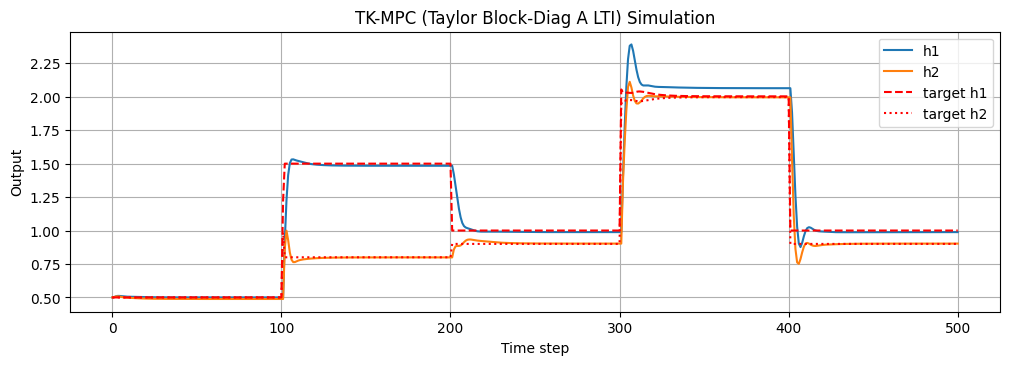

In [22]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0,0:], label='h1')
plt.plot(y_sim_descaled[1,0:], label='h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0,:], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1,:], color='red', linestyle=':', label='target h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title('TK-MPC (Taylor Block-Diag A LTI) Simulation')
plt.legend()
plt.grid(True) 

In [23]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [24]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 421


In [29]:
# Compute the closed-loop value of the objective function
Qu = loaded_setup['Qu']
objective_value = 0
sim_time = 300
for k in range(sim_time):
    y_diff = y_sim[:, k] - loaded_setup["reference"][:, k]
    u_diff = u_sim[:, k] - u_sim[:, k-1]
    objective_value += y_diff.T @ Qy @ y_diff 
    objective_value += u_diff.T @ Qu @ u_diff
    

print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 36.292231736897286


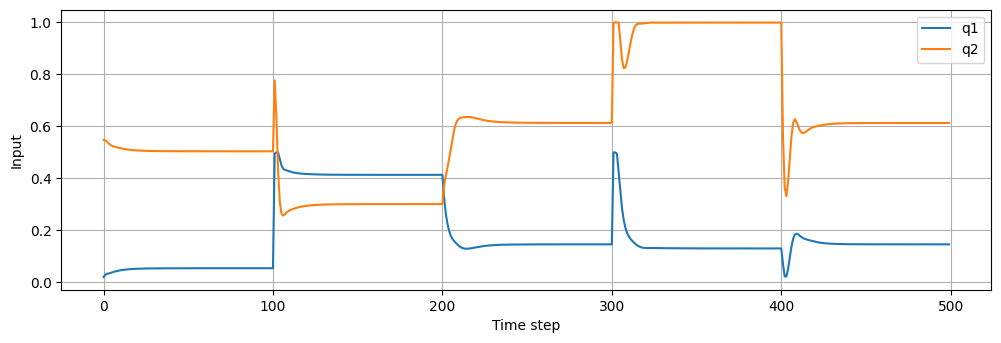

In [25]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0,0:], label='q1')
plt.plot(u_sim_descaled[1,0:], label='q2')
plt.xlabel('Time step')
plt.ylabel('Input')
plt.legend()
plt.grid(True) 

In [26]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[ 91.79369324 301.11471655]


In [27]:
u_sim_descaled[:,49]

array([0.05453768, 0.50447138])

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_41503/621697738.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


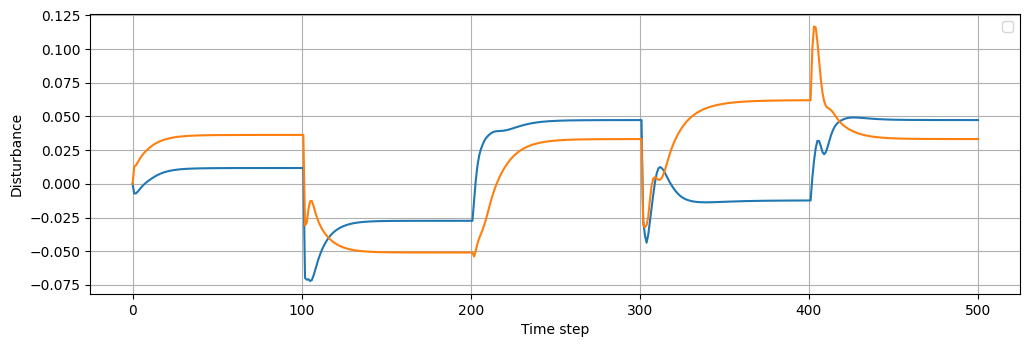

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[nz:].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_41503/4249820153.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


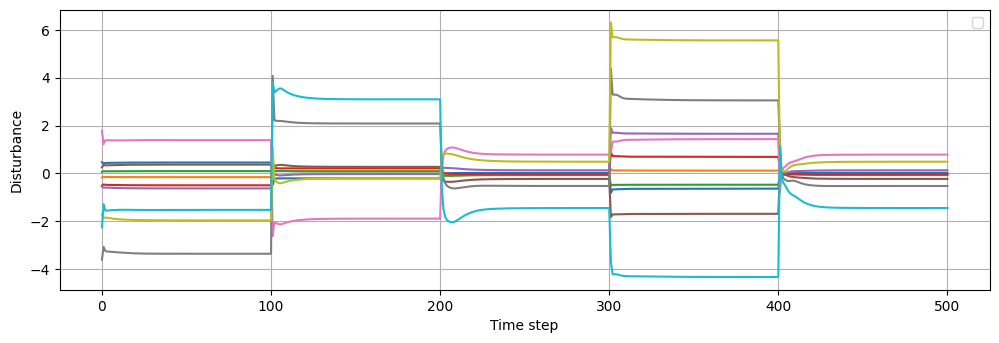

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(zs_sim[:nz].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_41503/2974051967.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


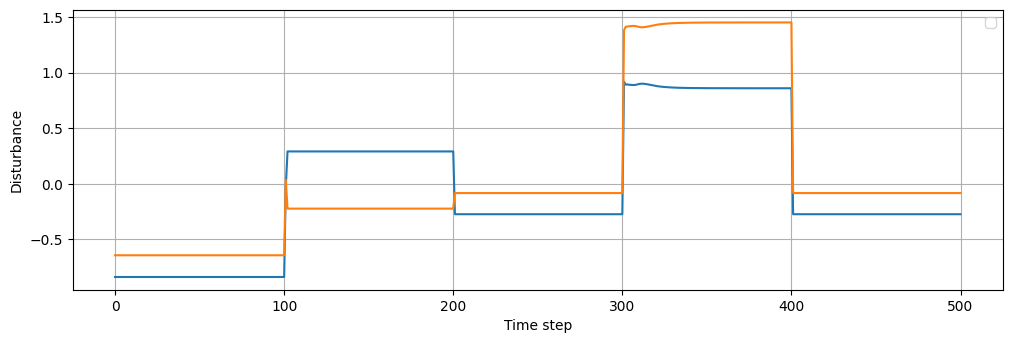

In [30]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ys_sim.T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

In [31]:
ys_sim[:,40:60]

array([[-0.83766853, -0.83766853, -0.83766853, -0.83766853, -0.83766853,
        -0.83766853, -0.83766853, -0.83766853, -0.83766853, -0.83766853,
        -0.83766853, -0.83766853, -0.83766853, -0.83766853, -0.83766853,
        -0.83766853, -0.83766853, -0.83766853, -0.83766853, -0.83766853],
       [-0.64228928, -0.64228928, -0.64228928, -0.64228928, -0.64228928,
        -0.64228928, -0.64228928, -0.64228928, -0.64228928, -0.64228928,
        -0.64228928, -0.64228928, -0.64228928, -0.64228928, -0.64228928,
        -0.64228928, -0.64228928, -0.64228928, -0.64228928, -0.64228928]])

In [32]:
T_real@z_sim

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 12 is different from 10)

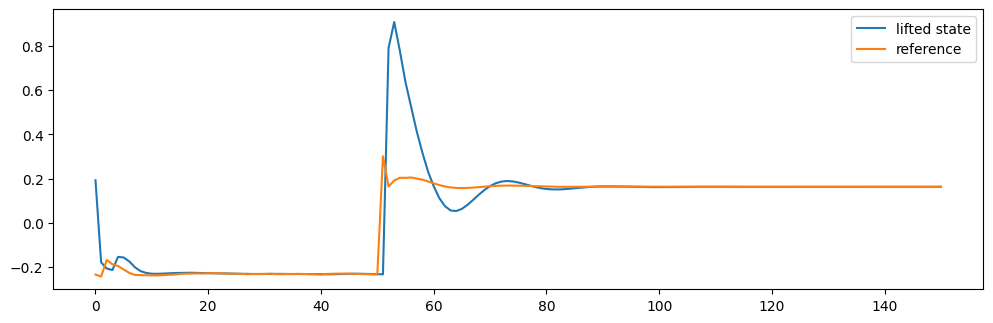

In [ ]:
lifted_state = 2
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot((T_real@z_sim[:10])[lifted_state].T, label = 'lifted state')
plt.plot((T_real@zs_sim[:10])[lifted_state].T, label = 'reference')
legend = plt.legend()


## comparison with Jackobian

In [ ]:
start = 50
end = 70

y_C = C@z_sim[:nz,start:end] + z_sim[nz:,start:end]
y_C_sp = J_k@z_sim[:nz,start:end] - J_k@z_s.value.reshape(-1,1) + get_y(z_k.value).T + z_sim[nz:,start:end]

J_k = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_sim[:nz,start]).float(),
)
y_Cstart = J_k@z_sim[:nz,start:end] - J_k@z_sim[:nz,start].reshape(-1,1) + get_y(z_sim[:nz,start]).T + z_sim[nz:,start:end]

y_Ck = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_sim[:nz,i]).float(),
    )
    y_Ck[:,i-start] = J_k@z_sim[:nz,i] - J_k@z_sim[:nz,i] + get_y(z_sim[:nz,i]) + z_sim[nz:,i]

y_Ck_sp = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(zs_sim[:nz,i]).float(),
    )
    y_Ck_sp[:,i-start] = J_k@z_sim[:nz,i] - J_k@zs_sim[:nz,i] + get_y(zs_sim[:nz,i]) + z_sim[nz:,i]

x0 = get_x(y_sim[:,start])
x_p = np.zeros((nz, (end-start)+1))
y_xh = np.zeros((ny, (end-start)))
x_p[:,0] = x0.flatten()
for i in range(start, end):
    x_p[:,i+1-start] = A @ x_p[:,i-start] + B @ u_sim[:,i]
    x0 = x_p[:,i-start]
    y_xh[:,i-start] = get_y(x_p[:,i-start]) + z_sim[nz:,i]

# descale
y_C = scaler.inverse_transform(y_C.T).T
y_C_sp = scaler.inverse_transform(y_C_sp.T).T
y_Ck = scaler.inverse_transform(y_Ck.T).T
y_Cstart = scaler.inverse_transform(y_Cstart.T).T
y_Ck_sp = scaler.inverse_transform(y_Ck_sp.T).T
descaled_sp = scaler.inverse_transform(y_setpoint.reshape(1,-1))[0]
y_xh = scaler.inverse_transform(y_xh.T).T

NameError: name 'J_k' is not defined

In [ ]:
# # find first index in ysim[0] > 1.58001
# y_sim_descaled[0] > 1.58001
# # index of true values
# # find first index in ysim[0] > 1.58001
# for i in range(len(y_sim_descaled[0])):
#     if np.all(y_sim_descaled[0][i] > 1.58001):
#         print("First convergence index:", i)
#         break
# # plot results

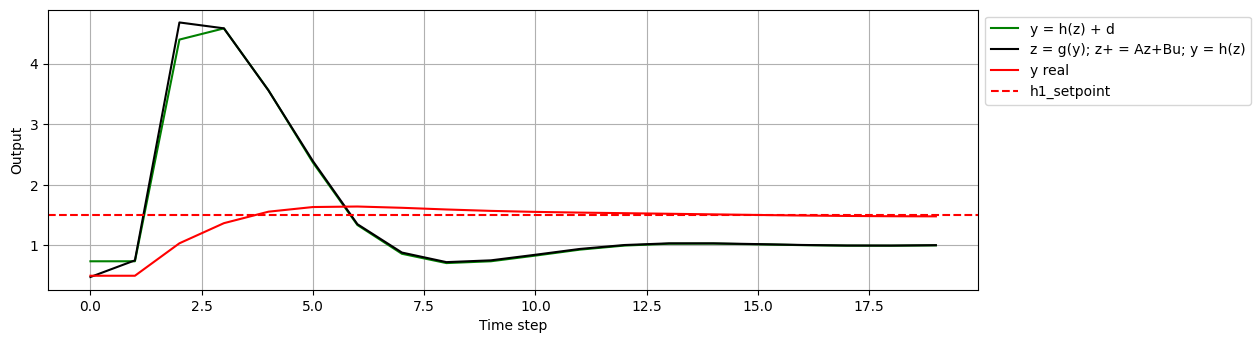

In [ ]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
#plt.plot(y_C[0], label='y = Cz + d', color='blue')
#plt.plot(y_C_sp[0], label='y = C_sp z +d', color='brown')
plt.plot(y_Ck[0], label='y = h(z) + d', color='green')
#plt.plot(y_Cstart[0], label='y = C_start z + d', color='purple')
#plt.plot(y_Ck_sp[0], label='y = C_lastsp z +d ', color='orange')
plt.plot(y_xh[0], label='z = g(y); z+ = Az+Bu; y = h(z)', color='black')

plt.plot(y_sim_descaled[0, start:end], label='y real', color='red')
# plot yref as dashed line as a horizontal line
plt.axhline(y=descaled_sp[0], color='r', linestyle='--', label='h1_setpoint')
# legend outside
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)


In [ ]:
ise_h1_y_C = trapz((y_C[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C: {ise_h1_y_C}")

ise_h1_y_C_sp = trapz((y_C_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C_sp: {ise_h1_y_C_sp}")

ise_h1_y_Ck = trapz((y_Ck[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck: {ise_h1_y_Ck}")

ise_h1_y_Cstart = trapz((y_Cstart[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Cstart: {ise_h1_y_Cstart}")

ise_h1_y_Ck_sp = trapz((y_Ck_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck_sp: {ise_h1_y_Ck_sp}")

ise_h1_y_xh = trapz((y_xh[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_xh: {ise_h1_y_xh}")

ISE for h1 y_C: 0.4071354482209629
ISE for h1 y_C_sp: 6.994188739268423
ISE for h1 y_Ck: 31.105570783538194
ISE for h1 y_Cstart: 27.44942012269375
ISE for h1 y_Ck_sp: 28.33884979457625
ISE for h1 y_xh: 32.9370929798247


# prediction

In [ ]:
A @ z_sim[:nz,i] + B @ u_sim[:,i]

array([ 0.18609477, -0.19991291,  0.16235913, -0.87077186, -0.20162347,
       -0.08289417, -1.21249001,  1.88957211, -0.04692681, -0.33288122])

In [ ]:
start = 50+3
end = 70
z_sim_copy = z_sim.copy()
for i in range(start, end):
    z_sim_copy[:nz,i+1] = A @ z_sim_copy[:nz,i] + B @ u_sim[:,i]

y_C = C@z_sim_copy[:nz,start:end] + z_sim_copy[nz:,start].reshape(-1,1)
    
y_C_sp = J_k@z_sim_copy[:nz,start:end] - J_k@z_s.value.reshape(-1,1) + get_y(z_k.value).T + z_sim_copy[nz:,start].reshape(-1,1)

J_k = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_sim_copy[:nz,start]).float(),
)
y_Cstart = J_k@z_sim_copy[:nz,start:end] - J_k@z_sim_copy[:nz,start].reshape(-1,1) + get_y(z_sim_copy[:nz,start]).T + z_sim_copy[nz:,start].reshape(-1,1)

y_Ck = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_sim_copy[:nz,i]).float(),
    )
    y_Ck[:,i-start] = J_k@z_sim_copy[:nz,i] - J_k@z_sim_copy[:nz,i] + get_y(z_sim_copy[:nz,i]) + z_sim_copy[nz:,start]

y_Ck_sp = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(zs_sim[:nz,i]).float(),
    )
    y_Ck_sp[:,i-start] = J_k@z_sim_copy[:nz,i] - J_k@zs_sim[:nz,i] + get_y(zs_sim[:nz,i]) + z_sim_copy[nz:,start]

x0 = get_x(y_sim[:,start])
x_p = np.zeros((nz, (end-start)+1))
y_xh = np.zeros((ny, (end-start)))
x_p[:,0] = x0.flatten()
for i in range(start, end):
    x_p[:,i+1-start] = A @ x_p[:,i-start] + B @ u_sim[:,i]
    x0 = x_p[:,i-start]
    y_xh[:,i-start] = get_y(x_p[:,i-start]) #+ z_sim_copy[nz:,start]

# descale
y_C = scaler.inverse_transform(y_C.T).T
y_C_sp = scaler.inverse_transform(y_C_sp.T).T
y_Ck = scaler.inverse_transform(y_Ck.T).T
y_Cstart = scaler.inverse_transform(y_Cstart.T).T
y_Ck_sp = scaler.inverse_transform(y_Ck_sp.T).T
descaled_sp = scaler.inverse_transform(y_setpoint.reshape(1,-1))[0]
y_xh = scaler.inverse_transform(y_xh.T).T

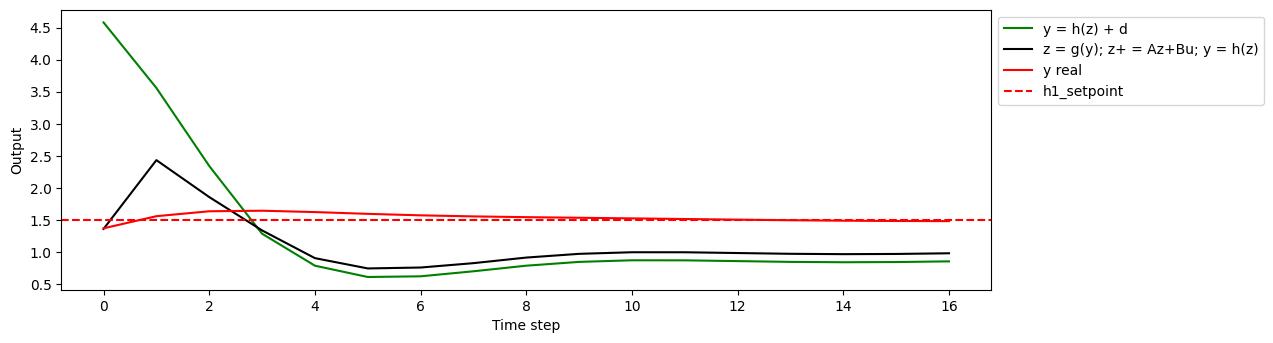

In [ ]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
#plt.plot(y_C[0], label='y = Cz + d', color='blue')
#plt.plot(y_C_sp[0], label='y = C_sp z +d', color='brown')
plt.plot(y_Ck[0], label='y = h(z) + d', color='green')
#plt.plot(y_Cstart[0], label='y = C_start z + d', color='purple')
#plt.plot(y_Ck_sp[0], label='y = C_lastsp z +d ', color='orange')
plt.plot(y_xh[0], label='z = g(y); z+ = Az+Bu; y = h(z)', color='black')

plt.plot(y_sim_descaled[0, start:end], label='y real', color='red')
# plot yref as dashed line as a horizontal line
plt.axhline(y=descaled_sp[0], color='r', linestyle='--', label='h1_setpoint')
# legend outside
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
ise_h1_y_C = trapz((y_C[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C: {ise_h1_y_C}")

ise_h1_y_C_sp = trapz((y_C_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C_sp: {ise_h1_y_C_sp}")

ise_h1_y_Ck = trapz((y_Ck[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck: {ise_h1_y_Ck}")

ise_h1_y_Cstart = trapz((y_Cstart[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Cstart: {ise_h1_y_Cstart}")

ise_h1_y_Ck_sp = trapz((y_Ck_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck_sp: {ise_h1_y_Ck_sp}")

ise_h1_y_xh = trapz((y_xh[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_xh: {ise_h1_y_xh}")

ISE for h1 y_C: 0.1704547740806916
ISE for h1 y_C_sp: 13.229035662414393
ISE for h1 y_Ck: 16.858348012112245
ISE for h1 y_Cstart: 18.4020982296728
ISE for h1 y_Ck_sp: 15.111762914138415
ISE for h1 y_xh: 5.8177033126564694


ISE for h1 y_C_sp: 0.9157052163902\
ISE for h1 y_Ck: 0.20538840598700672\
ISE for h1 y_Cstart: 6.892414715687395

In [ ]:
import numpy as np
from scipy.linalg import schur, inv

# Real Schur decomposition: A = T R T^{-1}
R, T = schur(A, output='real')

# Transform B and C
B_new = inv(T) @ B
C_new = C @ T

# R is the (block) diagonalized A
A_diag = R


In [ ]:
R

array([[ 0.18143465,  0.07945449,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07945449,  0.18143465,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.33934799,  0.31094778,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.31094778, -0.33934799,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.31733289,
         0.26976255,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.26976255,
         0.31733289,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.83486539,  0.        

In [ ]:
# Check the transformation validity
A_reconstructed = T @ R @ inv(T)
print(np.allclose(A, A_reconstructed,atol=1e-5))  # Should be True


True


In [ ]:
eigs, eigv = np.linalg.eig(A)

In [ ]:
A

array([[ 0.83486539,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.55462122,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.33934799,  0.31094778,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.31094778, -0.33934799,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.31733289,
         0.26976255,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.26976255,
         0.31733289,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.18143465,  0.07945449

In [ ]:
import numpy as np
from scipy.linalg import schur
from numpy.linalg import inv

# Your A matrix
A = np.array([
    [-1.14522003e-01,  2.03093424e-01,  6.89496323e-02, -4.37825114e-01, -8.95581692e-02,
     -2.60605991e-01, -2.18124956e-01,  2.10425913e-01,  1.20713249e-01, -1.69211611e-01],
    [-1.39853269e-01,  2.50181258e-01, -1.67046607e-01, -1.66967645e-01,  1.50321633e-01,
      2.21398529e-02, -7.03850016e-02,  9.52759609e-02, -2.88743973e-01,  1.30518183e-01],
    [ 3.17415088e-01, -6.73412830e-02,  1.28425375e-01,  1.99055180e-01,  2.79311121e-01,
      8.25060830e-02,  7.43955150e-02, -2.59516060e-01,  2.50023156e-01,  9.65642091e-03],
    [-5.53147644e-02,  3.15649688e-01, -2.03368738e-01,  7.85609335e-02,  6.97049722e-02,
      2.08954945e-01,  1.86362505e-01, -1.94696590e-01, -3.56145680e-01,  1.29450396e-01],
    [ 2.98496336e-02,  2.59809136e-01,  3.15923840e-01, -2.51136333e-01,  1.78798318e-01,
     -4.88360487e-02,  3.82526815e-02,  8.61436799e-02,  9.13691074e-02, -1.30176499e-01],
    [ 2.43743863e-02,  1.00827860e-02, -2.18770638e-01,  2.18619466e-01, -8.52346569e-02,
      2.91468680e-01,  3.76932830e-01, -1.54714316e-01, -4.19768572e-01,  7.02630877e-02],
    [ 3.49000692e-02, -7.40560740e-02,  4.87561524e-02,  2.21140414e-01, -6.27286732e-02,
     -2.75046844e-02,  4.07175511e-01, -1.55871119e-02, -1.36225998e-01, -2.22521797e-01],
    [ 1.76082075e-01,  2.25342140e-02,  1.54601812e-01,  1.96817577e-01, -1.01822556e-03,
     -1.20464794e-01,  3.39480102e-01, -2.11077198e-01,  4.07144874e-02, -7.00352490e-02],
    [ 5.28373942e-02, -7.85138160e-02, -6.79740533e-02, -1.28359303e-01,  2.88389802e-01,
     -1.17743179e-01,  6.24958463e-02,  2.38817871e-01, -1.80540234e-01, -1.08955175e-01],
    [-1.26791298e-01,  2.68203032e-04,  1.01728342e-01,  8.21731836e-02,  1.66454509e-01,
      1.54194906e-01, -1.00210495e-01, -1.35345504e-01,  1.30677089e-01,  1.62582874e-01]
], dtype=np.float32)

# Perform real Schur decomposition
R, T = schur(A, output='real')

# Reconstruct A
A_reconstructed = T @ R @ inv(T)

# Check closeness
print("Reconstruction accurate:", np.allclose(A, A_reconstructed, atol=1e-5))


Reconstruction accurate: True


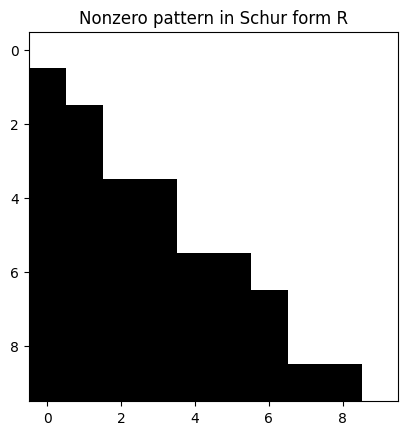

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(R) > 1e-6, cmap='gray')
plt.title("Nonzero pattern in Schur form R")
plt.show()


In [ ]:
R

array([[ 0.845091  , -0.40381598,  0.36577693,  0.25178877,  0.00530107,
        -0.17327586,  0.04618959,  0.12157419,  0.12417582,  0.12132811],
       [ 0.        , -0.33710945,  0.20575967, -0.13826679, -0.24233016,
        -0.00505477, -0.240361  , -0.11502698,  0.08808289,  0.20788014],
       [ 0.        ,  0.        , -0.15355362, -0.38140142, -0.26660293,
         0.30461884, -0.12305014, -0.00156398, -0.1841901 , -0.04006457],
       [ 0.        ,  0.        ,  0.14581741, -0.15355362, -0.02534095,
         0.59102094, -0.1467628 , -0.2269887 , -0.31378064,  0.1959983 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.31211343,
        -0.08590156,  0.01585828, -0.2706209 ,  0.09726471,  0.13656934],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.2808893 ,
         0.31211343, -0.09049682, -0.18754722, -0.08062394, -0.19573852],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.10204245, -0.17712466

In [ ]:
from numpy.linalg import eig, matrix_rank

eigvals, eigvecs = eig(A)
rank = matrix_rank(eigvecs)

if rank == A.shape[0]:
    print("A is diagonalizable")
else:
    print("A is NOT diagonalizable (defective)")


A is diagonalizable


In [ ]:
import numpy as np
from numpy.linalg import eig, inv

eigvals, eigvecs = eig(A)     


In [ ]:
import numpy as np
from numpy.linalg import eig, inv

def real_block_diagonalize(A):
    eigvals, eigvecs = eig(A)
    n = A.shape[0]

    T_real_cols = []
    block_sizes = []
    block_matrices = []

    used = set()

    for i in range(n):
        if i in used:
            continue

        λ = eigvals[i]
        v = eigvecs[:, i]

        if np.isreal(λ):
            # Real eigenvalue
            T_real_cols.append(np.real(v))
            block_sizes.append(1)
            block_matrices.append(np.array([[np.real(λ)]]))
        else:
            # Complex eigenvalue → find conjugate
            λ_conj = np.conj(λ)
            for j in range(i + 1, n):
                if j not in used and np.isclose(eigvals[j], λ_conj):
                    v_conj = eigvecs[:, j]
                    # Construct real 2D basis
                    v1 = np.real(v)
                    v2 = np.imag(v)
                    T_real_cols.append(v1)
                    T_real_cols.append(v2)

                    a = np.real(λ)
                    b = np.imag(λ)
                    block_sizes.append(2)
                    block_matrices.append(np.array([[a, b], [-b, a]]))
                    used.add(j)
                    break
        used.add(i)

    # Assemble T_real
    T_real = np.column_stack(T_real_cols)

    # Assemble A_block from blocks
    A_block = np.zeros((n, n))
    idx = 0
    for size, block in zip(block_sizes, block_matrices):
        A_block[idx:idx+size, idx:idx+size] = block
        idx += size

    return T_real, A_block


In [ ]:
T_real, A_block = real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))


Close to block diagonal? True


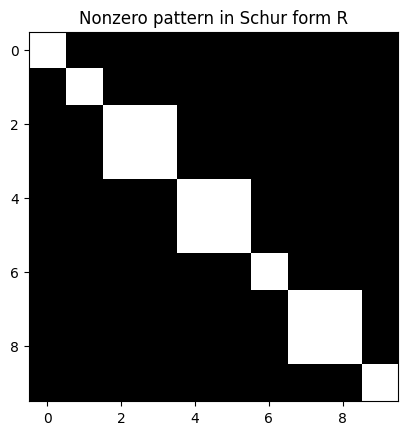

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(A_transformed) > 1e-6, cmap='gray')
plt.title("Nonzero pattern in Schur form R")
plt.show()